In [1]:
import numpy as np
import matplotlib.pyplot as plt
#import emc2
import glob
import xarray
import datetime
import calendar
from matplotlib.gridspec import GridSpec
import matplotlib.dates as mdates
import matplotlib
import pickle
import pandas as pd
import os
from scipy import ndimage
from scipy.ndimage import gaussian_filter
from scipy.interpolate import NearestNDInterpolator as nn
from scipy.interpolate import griddata as griddata
import pandas
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from matplotlib.ticker import MaxNLocator
from file_struct import file_struct as fs
from load_sonde_data import load_sonde_data
from give_me_files_and_subfolders import give_me_files_and_subfolders
from calculate_theta_and_more import calculate_theta_and_more
from scipy.signal import argrelextrema
import seaborn as sns
from dask.distributed import Client, progress, LocalCluster

In [2]:
#--------------------------------------------
# Functions
#--------------------------------------------
def toTimestamp(d):
    return calendar.timegm(d.timetuple())

def toDatetime(d):
    return datetime.datetime.utcfromtimestamp(d)

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx],idx   

# function to make serial date numbers which are the number of days that have passed
# since epoch beginning given as days.fraction_of_day
def datenum(d):
        return 366 + d.toordinal() + (d - datetime.datetime.fromordinal(d.toordinal())).total_seconds()/(24*60*60)
#--------------------------------------------

In [3]:
#--------------------------------------------
# Occurrence Frequency
#--------------------------------------------
def occur_freq(data,bins,full_length):
    tmp_hist = []
    for ii in range(len(bins)-1):
        if ii != (len(bins)-2):
            tmpid = np.where((data >= bins[ii]) & (data < bins[ii+1]))
            tmp_hist.append(np.size(tmpid)/full_length)
        elif ii == (len(bins)-2):
            tmpid = np.where((data >= bins[ii]) & (data <= bins[ii+1]))
            tmp_hist.append(np.size(tmpid)/full_length)            
    tmp_hist = np.array(tmp_hist)
    return tmp_hist,bins

In [4]:
#-----------------------
# Read in E3 Dictionary
#-----------------------
save_path = '/mnt/raid/mwstanfo/emc2/micro/'
infile = 'emc2_processed.p'
in_pkl_file = save_path+infile
e3_dict = pickle.load(open(in_pkl_file,"rb"))

In [5]:
#-------------------------------
# Define cloud properties
# from E3 dictionary
#-------------------------------
rcb = e3_dict['rcb']
precip_binary = e3_dict['precip_binary']
sfc_precip_binary = e3_dict['sfc_precip_binary']
precip_to_sfc_binary = e3_dict['precip_to_sfc_binary']
ctt = e3_dict['ctt']-273.15
cbt = e3_dict['cbt']-273.15
cth = e3_dict['cth']
cbh = e3_dict['cbh']
c_thick = e3_dict['c_thick']
cb_Ze = e3_dict['cb_Ze']
cb_clwc = e3_dict['cb_clwc']
cb_beta_att = e3_dict['cb_beta_att']
c_thick = e3_dict['c_thick']
time = e3_dict['time']
years = e3_dict['years']
months = e3_dict['months']

In [6]:
# Add month and year as independent variables to e3_dict
years = []
months = []
for ii in range(len(time)):
    years.append(time[ii].year)
    months.append(time[ii].month)
years = np.array(years)
months = np.array(months)

In [7]:
#-----------------------
# Read in MICRE Dictionary
#-----------------------
path = '/mnt/raid/mwstanfo/micre/'
infile = path+'micre_cloud_properties_dict_all_vb.p'
var_dict_cloud = pickle.load(open(infile,"rb"))
micre_precip_binary = var_dict_cloud['precip_binary']
micre_precip_to_sfc_binary = var_dict_cloud['precip_to_sfc_binary']
micre_sfc_precip_binary = var_dict_cloud['sfc_precip_binary']
micre_ref_mean_bel = var_dict_cloud['ref_mean_bel']
micre_c_thick = var_dict_cloud['c_thick']
micre_cbh = var_dict_cloud['cbh']
micre_cbt = var_dict_cloud['cbt']
micre_ctt = var_dict_cloud['ctt']
dumid = np.where( (micre_cbt > -38.) & (micre_ctt > -38.))
micre_cbt = micre_cbt[dumid]
micre_ctt = micre_ctt[dumid]
micre_c_thick = micre_c_thick[dumid]
micre_cbh = micre_cbh[dumid]
micre_ref_mean_bel = micre_ref_mean_bel[dumid]
micre_precip_binary = micre_precip_binary[dumid]
micre_precip_to_sfc_binary = micre_precip_to_sfc_binary[dumid]
micre_sfc_precip_binary = micre_sfc_precip_binary[dumid]

micre_precip_id = np.where(micre_precip_binary == 1.)
micre_supercooled_precip_id = np.where( (micre_precip_binary == 1.) & (micre_cbt < 0.) & (micre_ctt < 0.) )
micre_partially_supercooled_precip_id = np.where( (micre_precip_binary == 1.) & (micre_cbt >= 0.) & (micre_ctt < 0.) )
micre_warm_precip_id = np.where( (micre_precip_binary == 1.) & (micre_cbt >= 0.) & (micre_ctt >= 0.) )

micre_supercooled_cloud_id = np.where( (micre_precip_binary > -999.) & (micre_cbt < 0) & (micre_ctt < 0.) )
micre_partially_supercooled_cloud_id = np.where( (micre_precip_binary > -999.) & (micre_cbt >= 0) & (micre_ctt < 0.) )
micre_warm_cloud_id = np.where( (micre_precip_binary > -999.) & (micre_cbt >= 0) & (micre_ctt >= 0.) )

micre_supercooled_cloud_size = np.size(micre_supercooled_cloud_id)
micre_partially_supercooled_cloud_size = np.size(micre_partially_supercooled_cloud_id)
micre_warm_cloud_size = np.size(micre_warm_cloud_id)

micre_sfc_precip_id = np.where(micre_sfc_precip_binary == 1.)
tot_cloud_size = np.size(micre_precip_binary)

# Calculate MICRE Pcb
print('------Pcb-------')
micre_precip_size = np.size(micre_precip_id)
micre_pcb_base = micre_precip_size/tot_cloud_size*100.
print('All:',micre_pcb_base)
micre_supercooled_precip_size = np.size(micre_supercooled_precip_id)
micre_pcb_supercooled_base = micre_supercooled_precip_size/micre_supercooled_cloud_size*100.
print('Supercooled:',micre_pcb_supercooled_base)
micre_partially_supercooled_precip_size = np.size(micre_partially_supercooled_precip_id)
micre_pcb_partially_supercooled_base = micre_partially_supercooled_precip_size/micre_partially_supercooled_cloud_size*100.
print('Partially Supercooled:',micre_pcb_partially_supercooled_base)
micre_warm_precip_size = np.size(micre_warm_precip_id)
micre_pcb_warm_base = micre_warm_precip_size/micre_warm_cloud_size*100.
print('Warm:',micre_pcb_warm_base)

# Calculate MICRE Evaporated Fraction
print('------Evap Frac-------')

dum_precip_id = np.where(micre_precip_binary == 1.)
dum_cbt = micre_cbt[dum_precip_id]
dum_ctt = micre_ctt[dum_precip_id]
dum_precip_to_sfc_binary = micre_precip_to_sfc_binary[dum_precip_id]
dumid = np.where(~np.isnan(dum_precip_to_sfc_binary))
dum_ctt = dum_ctt[dumid]
dum_cbt = dum_cbt[dumid]
dum_precip_to_sfc_binary = dum_precip_to_sfc_binary[dumid]

tot_evap_cloud_size = np.size(dum_cbt)

micre_supercooled_evap_cloud_id = np.where( (dum_ctt < 0.) & (dum_cbt < 0.) )
micre_supercooled_evap_cloud_size = np.size(micre_supercooled_evap_cloud_id)
micre_partially_supercooled_evap_cloud_id = np.where( (dum_ctt < 0.) & (dum_cbt >= 0.) )
micre_partially_supercooled_evap_cloud_size = np.size(micre_partially_supercooled_evap_cloud_id)

micre_warm_evap_cloud_id = np.where( (dum_ctt >= 0.) & (dum_cbt >= 0.) )
micre_warm_evap_cloud_size = np.size(micre_warm_evap_cloud_id)

micre_evap_frac_id = np.where(dum_precip_to_sfc_binary == 0.)
micre_evap_frac_size = np.size(micre_evap_frac_id)
micre_evap_frac_base = micre_evap_frac_size/tot_evap_cloud_size*100.
print('All:',micre_evap_frac_base)
micre_supercooled_evap_frac_id = np.where( (dum_precip_to_sfc_binary == 0.) & (dum_ctt < 0.) & (dum_cbt < 0.) )
micre_supercooled_evap_frac_size = np.size(micre_supercooled_evap_frac_id)
micre_supercooled_evap_frac_base = micre_supercooled_evap_frac_size/micre_supercooled_evap_cloud_size*100.
print('Supercooled:',micre_supercooled_evap_frac_base)
micre_partially_supercooled_evap_frac_id = np.where( (dum_precip_to_sfc_binary == 0.) & (dum_ctt < 0.) & (dum_cbt >= 0.) )
micre_partially_supercooled_evap_frac_size = np.size(micre_partially_supercooled_evap_frac_id)
micre_partially_supercooled_evap_frac_base = micre_partially_supercooled_evap_frac_size/micre_partially_supercooled_evap_cloud_size*100.
print('Partially Supercooled:',micre_partially_supercooled_evap_frac_base)
micre_warm_evap_frac_id = np.where( (dum_precip_to_sfc_binary == 0.) & (dum_ctt >= 0.) & (dum_cbt >= 0.) )
micre_warm_evap_frac_size = np.size(micre_warm_evap_frac_id)
micre_warm_evap_frac_base = micre_warm_evap_frac_size/micre_warm_evap_cloud_size*100.
print('Warm:',micre_warm_evap_frac_base)


# Calculate MICRE Psfc
print('------Psfc-------')

tot_sfc_precip_size = np.size(micre_sfc_precip_binary)

micre_sfc_precip_id = np.where(micre_sfc_precip_binary == 1.)
micre_sfc_precip_size = np.size(micre_sfc_precip_id)
micre_psfc_base = micre_sfc_precip_size/tot_sfc_precip_size*100.
print('All:',micre_psfc_base)

micre_supercooled_sfc_precip_cloud_id = np.where( (micre_cbt < 0.) & (micre_ctt < 0.) )
micre_supercooled_sfc_precip_cloud_size = np.size(micre_supercooled_sfc_precip_cloud_id)

micre_partially_supercooled_sfc_precip_cloud_id = np.where( (micre_cbt >= 0.) & (micre_ctt < 0.) )
micre_partially_supercooled_sfc_precip_cloud_size = np.size(micre_partially_supercooled_sfc_precip_cloud_id)

micre_warm_sfc_precip_cloud_id = np.where( (micre_cbt >= 0.) & (micre_ctt >= 0.) )
micre_warm_sfc_precip_cloud_size = np.size(micre_warm_sfc_precip_cloud_id)

micre_supercooled_sfc_precip_id = np.where( (micre_sfc_precip_binary == 1.) & (micre_cbt < 0.) & (micre_ctt < 0.) )
micre_supercooled_sfc_precip_size = np.size(micre_supercooled_sfc_precip_id)

micre_partially_supercooled_sfc_precip_id = np.where( (micre_sfc_precip_binary == 1.) & (micre_cbt >= 0.) & (micre_ctt < 0.) )
micre_partially_supercooled_sfc_precip_size = np.size(micre_partially_supercooled_sfc_precip_id)

micre_warm_sfc_precip_id = np.where( (micre_sfc_precip_binary == 1.) & (micre_cbt >= 0.) & (micre_ctt >= 0.) )
micre_warm_sfc_precip_size = np.size(micre_warm_sfc_precip_id)

micre_psfc_supercooled_base = micre_supercooled_sfc_precip_size/micre_supercooled_sfc_precip_cloud_size*100.
micre_psfc_partially_supercooled_base = micre_partially_supercooled_sfc_precip_size/micre_partially_supercooled_sfc_precip_cloud_size*100.
micre_psfc_warm_base = micre_warm_sfc_precip_size/micre_warm_sfc_precip_cloud_size*100.

print('Supercooled:',micre_psfc_supercooled_base)
print('Partially Supercooled:',micre_psfc_partially_supercooled_base)
print('Warm:',micre_psfc_warm_base)

------Pcb-------
All: 69.22893123333854
Supercooled: 63.16584482502209
Partially Supercooled: 97.0838764108749
Warm: 65.23172885599946
------Evap Frac-------
All: 37.53892825107588
Supercooled: 48.60423289951539
Partially Supercooled: 11.989081084092366
Warm: 35.5308028446577
------Psfc-------
All: 54.16082034789267
Supercooled: 45.13704002869399
Partially Supercooled: 90.03801993477661
Warm: 52.852362747509076


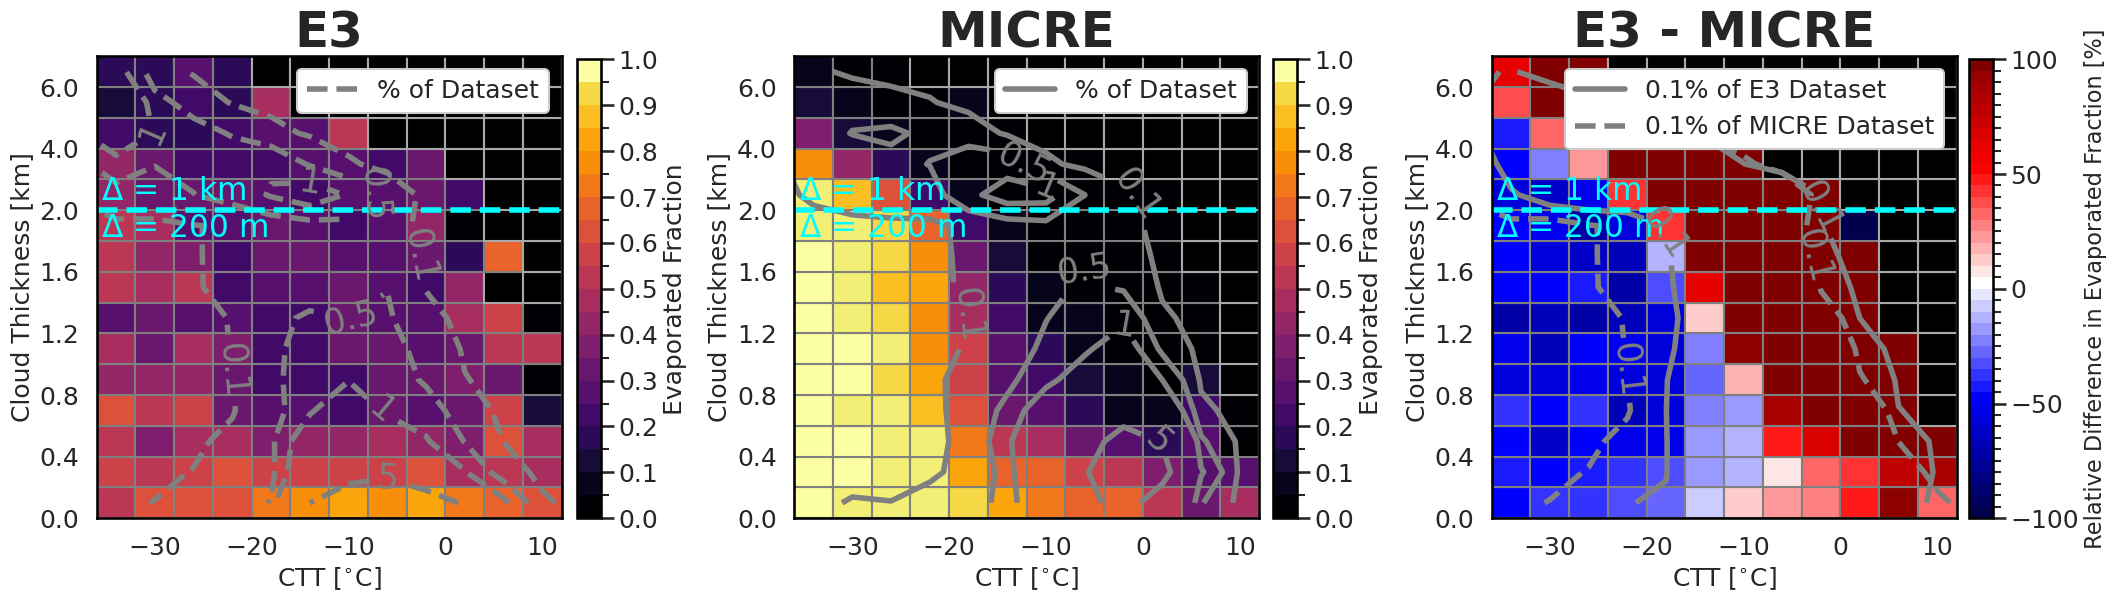

In [8]:
#---------------------------------------------------------
#---------------------------------------------------------
# Evaporated Fraction as a function of CTT and Cloud Thickness
#---------------------------------------------------------
#---------------------------------------------------------
from matplotlib import cm
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D

sns.set_style('ticks')
sns.set(rc={'axes.facecolor':'white','axes.edgecolor': 'black'})
sns.set_context('talk')

def fmt(x):
    s = f"{x:.1f}"
    if s.endswith("0"):
        s = f"{x:.0f}"
    return rf"{s}" if plt.rcParams["text.usetex"] else f"{s}"



fig = plt.figure(figsize=(24,6))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
Fontsize=18
axlist = [ax1,ax2,ax3]
for ax in axlist:
    ax.set_xlabel('CTT [$^{\circ}$C]',fontsize=Fontsize)
    ax.set_ylabel('Cloud Thickness [km]',fontsize=Fontsize)
    ax.tick_params(labelsize=Fontsize)

# Calculate precipitating fraction as a function of cloud depth and CTT
depth_bins = np.arange(0,2000,200)
depth_bins_2 = np.arange(2000,8000,1000)
depth_bins = np.concatenate((depth_bins,depth_bins_2))   
arb_bins = np.arange(0,len(depth_bins),1)

ctt_bins = np.arange(-40,24,4)
ctt_midbins = np.array([(ctt_bins[ii] + ctt_bins[ii+1])/2 for ii in range(len(ctt_bins)-1)])     
arb_midbins = np.array([(arb_bins[ii] + arb_bins[ii+1])/2 for ii in range(len(arb_bins)-1)])     

evap_frac_bins = np.arange(0,1.05,0.05)
ctt_binsize = ctt_bins[1]-ctt_bins[0]
arb_binsize=1.

nipy = cm.get_cmap('inferno',len(evap_frac_bins))
newcolors = nipy(np.linspace(0,1,len(evap_frac_bins)))   
numvec = np.zeros((len(ctt_bins)-1,len(depth_bins)-1))


#rel_diff_bins = np.arange(-50,55,5)
rel_diff_bins = np.arange(-100,105,5)
seismic = cm.get_cmap('seismic',len(rel_diff_bins))
rel_diff_binsize = rel_diff_bins[1] - rel_diff_bins[0]
rel_diff_newcolors = seismic(np.linspace(0,1,len(rel_diff_bins)-1))
rel_diff_numvec = np.zeros((len(ctt_bins)-1,len(depth_bins)-1))
#----------------------------
#----------------------------
# Joint histogram of CTT and Cloud Depth Precipitating Fraction
#----------------------------
#----------------------------

#----------------------------
# E3
#----------------------------
dum_precip_binary = precip_binary.copy()
dum_precip_to_sfc_binary = precip_to_sfc_binary.copy()
dum_ctt = ctt.copy()
dum_c_thick = c_thick.copy()
dum_cbh = cbh.copy()
dum_cb_Ze = e3_dict['cb_Ze'].copy()
dumid = np.where( (dum_precip_binary == 1.) & (dum_cb_Ze < -36.) )
dum_precip_binary[dumid] = 0.

dumid = np.where((dum_cbh > 250.) & (dum_precip_binary == 1.) )
dum_ctt = dum_ctt[dumid]
dum_c_thick = dum_c_thick[dumid]
dum_precip_to_sfc_binary = dum_precip_to_sfc_binary[dumid]


for ii in range(len(ctt_bins)-1):
    for jj in range(len(depth_bins)-1):
        tmpid = np.where( (dum_ctt >= ctt_bins[ii]) & (dum_ctt < ctt_bins[ii+1]) & (dum_c_thick >= depth_bins[jj]) & (dum_c_thick < depth_bins[jj+1]) )
        numid = np.size(tmpid)
        dumsize = numid/np.size(dum_ctt)*100.
        numvec[ii,jj] = dumsize
        if dumsize > 0.001:
            ctt_lim = dum_ctt[tmpid]
            c_thick_lim = dum_c_thick[tmpid]
            precip_to_sfc_binary_lim = dum_precip_to_sfc_binary[tmpid]
        
            precip_to_sfc_0 = np.where( precip_to_sfc_binary_lim == 0.)
            tmp_evap_frac = np.size(precip_to_sfc_0)/np.size(precip_to_sfc_binary_lim)


            col = np.max(np.where(tmp_evap_frac >= evap_frac_bins))
            tmpplot = ax1.add_patch(Rectangle((ctt_bins[ii],arb_bins[jj]),\
                                    ctt_binsize,arb_binsize,\
                                    alpha=1,edgecolor='grey',\
                                    facecolor=newcolors[col]))

        else:
            numvec[ii,jj] = 0
            tmpplot = ax1.add_patch(Rectangle((ctt_bins[ii],arb_bins[jj]),\
                                    ctt_binsize,arb_binsize,\
                                    alpha=1,edgecolor='darkgrey',\
                                   facecolor='black'))       


# Contour counts
cs = ax1.contour(ctt_midbins,arb_midbins,numvec.T,colors='grey',\
            linewidths=4,linestyles='dashed',levels=[0.1,0.5,1,5,10,50])

ax1.clabel(cs,cs.levels,inline=True,fmt=fmt,fontsize=25)
ax1.set_xlim(-36,12)   
ax1.set_ylim(0,len(depth_bins)-1) 
ax1.set_yticks(arb_bins[::2])
labels = [str(np.around(depth_bins[::2][dd]*1.e-3,1)) for dd in range(len(depth_bins[::2]))]
ax1.set_yticklabels(labels)


#----------------------------
# MICRE
#----------------------------
dum_precip_binary = micre_precip_binary.copy()
dum_precip_to_sfc_binary = micre_precip_to_sfc_binary.copy()
dum_ctt = micre_ctt.copy()
dum_c_thick = micre_c_thick.copy()
dum_ref_mean_bel = micre_ref_mean_bel.copy()
dumid = np.where( (dum_precip_binary == 1.) & (dum_ref_mean_bel < -36.) )
dum_precip_binary[dumid] = 0.

dumid = np.where(dum_precip_binary == 1.)
dum_ctt = dum_ctt[dumid]
dum_c_thick = dum_c_thick[dumid]
dum_precip_to_sfc_binary = dum_precip_to_sfc_binary[dumid]



for ii in range(len(ctt_bins)-1):
    for jj in range(len(depth_bins)-1):
        tmpid = np.where( (dum_ctt >= ctt_bins[ii]) & (dum_ctt < ctt_bins[ii+1]) & (dum_c_thick >= depth_bins[jj]) & (dum_c_thick < depth_bins[jj+1]) )
        numid = np.size(tmpid)
        dumsize = numid/np.size(dum_ctt)*100.
        numvec[ii,jj] = dumsize
        if dumsize > 0.001:
            ctt_lim = dum_ctt[tmpid]
            c_thick_lim = dum_c_thick[tmpid]
            precip_to_sfc_binary_lim = dum_precip_to_sfc_binary[tmpid]
            precip_to_sfc_0 = np.where(precip_to_sfc_binary_lim == 0.)
            tmp_evap_frac = np.size(precip_to_sfc_0)/np.size(precip_to_sfc_binary_lim)


            col = np.max(np.where(tmp_evap_frac >= evap_frac_bins))
            tmpplot = ax2.add_patch(Rectangle((ctt_bins[ii],arb_bins[jj]),\
                                    ctt_binsize,arb_binsize,\
                                    alpha=1,edgecolor='grey',\
                                    facecolor=newcolors[col]))

        else:
            numvec[ii,jj] = 0
            tmpplot = ax2.add_patch(Rectangle((ctt_bins[ii],arb_bins[jj]),\
                                    ctt_binsize,arb_binsize,\
                                    alpha=1,edgecolor='darkgrey',\
                                   facecolor='black'))       


# Contour counts
cs = ax2.contour(ctt_midbins,arb_midbins,numvec.T,colors='grey',\
            linewidths=4,levels=[0.1,0.5,1,5,10,50],linestyles='solid')

ax2.clabel(cs,cs.levels,inline=True,fmt=fmt,fontsize=25)
ax2.set_xlim(-36,12)   
ax2.set_ylim(0,len(depth_bins)-1) 
ax2.set_yticks(arb_bins[::2])
labels = [str(np.around(depth_bins[::2][dd]*1.e-3,1)) for dd in range(len(depth_bins[::2]))]
ax2.set_yticklabels(labels)


#----------------------------
# Relative Difference
#----------------------------
numvec_micre = np.zeros((len(ctt_bins)-1,len(depth_bins)-1))
numvec_e3 = np.zeros((len(ctt_bins)-1,len(depth_bins)-1))

# E3 
dum_e3_precip_binary = precip_binary.copy()
dum_e3_precip_to_sfc_binary = precip_to_sfc_binary.copy()
dum_e3_ctt = ctt.copy()
dum_e3_c_thick = c_thick.copy()
dum_e3_cbh = cbh.copy()
dum_e3_cb_Ze = e3_dict['cb_Ze'].copy()
dumid = np.where( (dum_e3_precip_binary == 1.) & (dum_e3_cb_Ze < -36.) )
dum_e3_precip_binary[dumid] = 0.

dumid = np.where( (dum_e3_cbh > 250.) & (dum_e3_precip_binary == 1.))
dum_e3_ctt = dum_e3_ctt[dumid]
dum_e3_c_thick = dum_e3_c_thick[dumid]
dum_e3_precip_to_sfc_binary = dum_e3_precip_to_sfc_binary[dumid]


# MICRE
dum_micre_precip_binary = micre_precip_binary.copy()
dum_micre_precip_to_sfc_binary = micre_precip_to_sfc_binary.copy()
dum_micre_ctt = micre_ctt.copy()
dum_micre_c_thick = micre_c_thick.copy()
dum_micre_ref_mean_bel = micre_ref_mean_bel.copy()
dumid = np.where( (dum_micre_precip_binary == 1.) & (dum_micre_ref_mean_bel < -36.) )
dum_micre_precip_binary[dumid] = 0.

dumid = np.where(dum_micre_precip_binary == 1.)
dum_micre_ctt = dum_micre_ctt[dumid]
dum_micre_c_thick = dum_micre_c_thick[dumid]
dum_micre_precip_to_sfc_binary = dum_micre_precip_to_sfc_binary[dumid]


for ii in range(len(ctt_bins)-1):
    for jj in range(len(depth_bins)-1):
        
        # E3 
        tmpid_e3 = np.where( (dum_e3_ctt >= ctt_bins[ii]) & (dum_e3_ctt < ctt_bins[ii+1]) & (dum_e3_c_thick >= depth_bins[jj]) & (dum_e3_c_thick < depth_bins[jj+1]) )
        numid_e3 = np.size(tmpid_e3)
        dumsize_e3 = numid_e3/np.size(dum_e3_ctt)*100.

        if dumsize_e3 > 0.001:
            numvec_e3[ii,jj] = dumsize_e3
            
            ctt_lim = dum_e3_ctt[tmpid_e3]
            c_thick_lim = dum_e3_c_thick[tmpid_e3]
            precip_to_sfc_binary_lim = dum_e3_precip_to_sfc_binary[tmpid_e3]
            precip_to_sfc_0 = np.where(precip_to_sfc_binary_lim == 0.)
            tmp_e3_evap_frac = np.size(precip_to_sfc_0)/np.size(precip_to_sfc_binary_lim)
        else:
            numvec_e3[ii,jj] = 0.
            tmp_e3_evap_frac = np.nan
            
        # MICRE
        tmpid_micre = np.where( (dum_micre_ctt >= ctt_bins[ii]) & (dum_micre_ctt < ctt_bins[ii+1]) & (dum_micre_c_thick >= depth_bins[jj]) & (dum_micre_c_thick < depth_bins[jj+1]) )
        numid_micre = np.size(tmpid_micre)
        dumsize_micre = numid_micre/np.size(dum_micre_precip_binary)*100.

        if dumsize_micre > 0.001:
            numvec_micre[ii,jj] = dumsize_micre
            ctt_lim = dum_micre_ctt[tmpid_micre]
            c_thick_lim = dum_micre_c_thick[tmpid_micre]
            precip_to_sfc_binary_lim = dum_micre_precip_to_sfc_binary[tmpid_micre]
            precip_to_sfc_0 = np.where( precip_to_sfc_binary_lim == 0.)
            tmp_micre_evap_frac = np.size(precip_to_sfc_0)/np.size(precip_to_sfc_binary_lim)
        else:
            numvec_micre[ii,jj] = 0.
            tmp_micre_evap_frac = np.nan

        if (~np.isnan(tmp_e3_evap_frac)) & (~np.isnan(tmp_micre_evap_frac)):
            #print(tmp_micre_evap_frac)
            diff = tmp_e3_evap_frac - tmp_micre_evap_frac
            if tmp_micre_evap_frac > 0.:
                rel_diff = diff/tmp_micre_evap_frac*100.
                if rel_diff > np.max(rel_diff_bins):
                    rel_diff = np.max(rel_diff_bins)-0.0001
                if rel_diff < np.min(rel_diff_bins):
                    rel_diff = np.min(rel_diff_bins)+0.0001
                col = np.max(np.where(rel_diff >= rel_diff_bins))
                tmpplot = ax3.add_patch(Rectangle((ctt_bins[ii],arb_bins[jj]),\
                                        ctt_binsize,arb_binsize,\
                                        alpha=1,edgecolor='grey',\
                                        facecolor=rel_diff_newcolors[col])) 
            else:
                tmpplot = ax3.add_patch(Rectangle((ctt_bins[ii],arb_bins[jj]),\
                                        ctt_binsize,arb_binsize,\
                                        alpha=1,edgecolor='darkgrey',\
                                       facecolor='black'))     
            
        else:
            tmpplot = ax3.add_patch(Rectangle((ctt_bins[ii],arb_bins[jj]),\
                                    ctt_binsize,arb_binsize,\
                                    alpha=1,edgecolor='darkgrey',\
                                   facecolor='black'))       

ax3.set_xlim(-36,12)   
ax3.set_ylim(0,len(depth_bins)-1) 
ax3.set_yticks(arb_bins[::2])
labels = [str(np.around(depth_bins[::2][dd]*1.e-3,1)) for dd in range(len(depth_bins[::2]))]
ax3.set_yticklabels(labels)



# Contour counts
cs = ax3.contour(ctt_midbins,arb_midbins,numvec_e3.T,colors='grey',\
            linewidths=4,levels=[0.1],linestyles='dashed')
ax3.clabel(cs,cs.levels,inline=True,fmt=fmt,fontsize=25)
cs2 = ax3.contour(ctt_midbins,arb_midbins,numvec_micre.T,colors='grey',linestyles='solid',\
            linewidths=4,levels=[0.1])
ax3.clabel(cs2,cs2.levels,inline=True,fmt=fmt,fontsize=25)

custom_lines = [Line2D([0], [0], color='grey',lw=4,ls='solid'),\
                Line2D([0], [0], color='grey',lw=4,ls='dashed'),\
               ]

ax3.legend(custom_lines, ['0.1% of E3 Dataset','0.1% of MICRE Dataset'],fontsize=Fontsize,loc='upper right',framealpha=1)



dumcolor='cyan'
for ax in axlist:
    ax.text(0.01,0.61,'$\\Delta$ = 200 m',fontsize=Fontsize*1.25,transform=ax.transAxes,color=dumcolor)
    ax.text(0.01,0.69,'$\\Delta$ = 1 km',fontsize=Fontsize*1.25,transform=ax.transAxes,color=dumcolor)
    ax.axhline(10,linewidth=4,c=dumcolor,ls='dashed')
    
custom_lines = [Line2D([0], [0], color='grey',lw=4,ls='dashed')]
ax1.legend(custom_lines, ['% of Dataset'],fontsize=Fontsize,loc='upper right',framealpha=1)
custom_lines = [Line2D([0], [0], color='grey',lw=4,ls='solid')]

ax2.legend(custom_lines, ['% of Dataset'],fontsize=Fontsize,loc='upper right',framealpha=1)
    
# Colorbar 1
bounds = evap_frac_bins
norm = matplotlib.colors.BoundaryNorm(bounds,nipy.N)
ax99 = fig.add_axes([0.325,0.11,0.01,0.765])
cb = matplotlib.colorbar.ColorbarBase(ax99,cmap=nipy,norm=norm,\
                                      spacing='uniform',\
                                      ticks=bounds,\
                                      boundaries=bounds,
                                      orientation='vertical')
cb.set_ticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.])
ax99.tick_params(labelsize=Fontsize)
ax99.set_ylabel('Evaporated Fraction',fontsize=Fontsize)

# Colorbar 2
bounds = evap_frac_bins
norm = matplotlib.colors.BoundaryNorm(bounds,nipy.N)
ax98 = fig.add_axes([0.615,0.11,0.01,0.765])
cb = matplotlib.colorbar.ColorbarBase(ax98,cmap=nipy,norm=norm,\
                                      spacing='uniform',\
                                      ticks=bounds,\
                                      boundaries=bounds,
                                      orientation='vertical')
cb.set_ticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.])
ax98.tick_params(labelsize=Fontsize)
ax98.set_ylabel('Evaporated Fraction',fontsize=Fontsize)

# Colorbar 3
bounds = rel_diff_bins
norm = matplotlib.colors.BoundaryNorm(bounds,seismic.N)
ax97 = fig.add_axes([0.905,0.11,0.01,0.765])
cb = matplotlib.colorbar.ColorbarBase(ax97,cmap=seismic,norm=norm,\
                                      spacing='uniform',\
                                      ticks=bounds,\
                                      boundaries=bounds,
                                      orientation='vertical')
#cb.set_ticks([-50,-25,0,25,50])
cb.set_ticks([-100,-50,0,50,100])
ax97.tick_params(labelsize=Fontsize)
ax97.set_ylabel('Relative Difference in Evaporated Fraction [%]',fontsize=Fontsize*0.9)

ax1.set_title('E3',fontsize=Fontsize*2,fontweight='bold')
ax2.set_title('MICRE',fontsize=Fontsize*2,fontweight='bold')
ax3.set_title('E3 - MICRE',fontsize=Fontsize*2,fontweight='bold')

plt.subplots_adjust(wspace=0.5)
plt.show()
plt.close()       

In [9]:
#===================================================
# MICRE Pcb and evaporated fraction as a function of Ze_min
#===================================================
Ze_min = np.arange(-55,16,1)
micre_pcb = np.zeros(len(Ze_min))
micre_pcb_supercooled = np.zeros(len(Ze_min))
micre_pcb_partially_supercooled = np.zeros(len(Ze_min))
micre_pcb_warm = np.zeros(len(Ze_min))

micre_evap_frac = np.zeros(len(Ze_min))
micre_evap_frac_supercooled = np.zeros(len(Ze_min))
micre_evap_frac_partially_supercooled = np.zeros(len(Ze_min))
micre_evap_frac_warm = np.zeros(len(Ze_min))

for ii in range(len(Ze_min)):
    
    # All Clouds
    precip_id = np.where( (micre_precip_binary == 1) & (micre_ref_mean_bel > Ze_min[ii]) & (micre_cbh > 250.) )
    cloud_id = np.where(micre_cbh > 250.)
    micre_pcb[ii] = np.size(precip_id)/np.size(cloud_id)
    micre_evap_id = np.where( (micre_precip_binary == 1.) & (micre_ref_mean_bel > Ze_min[ii]) & (micre_cbh > 250.) & (micre_precip_to_sfc_binary == 0.) )
    if np.size(micre_evap_id)/np.size(precip_id) > 0.01:
        micre_evap_frac[ii] = np.size(micre_evap_id)/np.size(precip_id)
    else:
        micre_evap_frac[ii] = np.nan    
    
    # Supercooled Clouds
    precip_id = np.where( (micre_precip_binary == 1) & (micre_ref_mean_bel > Ze_min[ii])  & (micre_cbt < 0.) & (micre_ctt < 0.) & (micre_cbh > 250.) )
    cloud_id = np.where( (micre_cbt < 0.) & (micre_ctt < 0.) & (micre_cbh > 250.) )
    micre_pcb_supercooled[ii] = np.size(precip_id)/np.size(cloud_id)  
    micre_supercooled_evap_id = np.where( (micre_precip_binary == 1.) & (micre_ref_mean_bel > Ze_min[ii]) & (micre_cbh > 250.) & (micre_precip_to_sfc_binary == 0.) & (micre_cbt < 0.) & (micre_ctt < 0.) )
    if np.size(micre_supercooled_evap_id)/np.size(precip_id) > 0.01:
        micre_evap_frac_supercooled[ii] = np.size(micre_supercooled_evap_id)/np.size(precip_id)
    else:
        micre_evap_frac_supercooled[ii] = np.nan
        
    # Partially Supercooled Clouds
    precip_id = np.where( (micre_precip_binary == 1) & (micre_ref_mean_bel > Ze_min[ii]) & (micre_cbt >= 0.) & (micre_ctt < 0.) & (micre_cbh > 250.) )
    cloud_id = np.where( (micre_cbt >= 0.) & (micre_ctt < 0.) & (micre_cbh > 250.) )
    micre_pcb_partially_supercooled[ii] = np.size(precip_id)/np.size(cloud_id) 
    micre_partially_supercooled_evap_id = np.where( (micre_precip_binary == 1.) & (micre_ref_mean_bel > Ze_min[ii]) & (micre_cbh > 250.) & (micre_precip_to_sfc_binary == 0.) & (micre_cbt >= 0.) & (micre_ctt < 0.) )
    if np.size(micre_partially_supercooled_evap_id)/np.size(precip_id) > 0.01:
        micre_evap_frac_partially_supercooled[ii] = np.size(micre_partially_supercooled_evap_id)/np.size(precip_id)
    else:
        micre_evap_frac_partially_supercooled[ii] = np.nan
        
    # Warm Clouds
    precip_id = np.where( (micre_precip_binary == 1) & (micre_ref_mean_bel > Ze_min[ii]) & (micre_cbt >= 0.) & (micre_ctt >= 0.) & (micre_cbh > 250.) )
    cloud_id = np.where( (micre_cbt >= 0.) & (micre_ctt >= 0.) & (micre_cbh > 250.) )
    micre_pcb_warm[ii] = np.size(precip_id)/np.size(cloud_id)
    micre_warm_evap_id = np.where( (micre_precip_binary == 1.) & (micre_ref_mean_bel > Ze_min[ii]) & (micre_cbh > 250.) & (micre_precip_to_sfc_binary == 0.) & (micre_cbt >= 0.) & (micre_ctt >= 0.) )
    if np.size(micre_warm_evap_id)/np.size(precip_id) > 0.01:
        micre_evap_frac_warm[ii] = np.size(micre_warm_evap_id)/np.size(precip_id)
    else:
        micre_evap_frac_warm[ii] = np.nan 
        

In [10]:
#===================================================
# E3 Pcb and evaporated fraction as a function of Ze_min
#===================================================
Ze_min = np.arange(-55,16,1)

pcb = np.zeros(len(Ze_min))
pcb_supercooled = np.zeros(len(Ze_min))
pcb_partially_supercooled = np.zeros(len(Ze_min))
pcb_warm = np.zeros(len(Ze_min))

evap_frac = np.zeros(len(Ze_min))
evap_frac_supercooled = np.zeros(len(Ze_min))
evap_frac_partially_supercooled = np.zeros(len(Ze_min))
evap_frac_warm = np.zeros(len(Ze_min))

for ii in range(len(Ze_min)):
    dum_precip_binary = precip_binary.copy()
    dum_precip_to_sfc_binary = precip_to_sfc_binary.copy()
    
    # All Clouds
    precip_id = np.where( (dum_precip_binary == 1) & (cb_Ze > Ze_min[ii]) & (cbh > 250.) )
    cloud_id = np.where(cbh > 250.)
    pcb[ii] = np.size(precip_id)/np.size(cloud_id)
    evap_id = np.where( (dum_precip_binary == 1.) & (cb_Ze > Ze_min[ii]) & (cbh > 250.) & (dum_precip_to_sfc_binary == 0.) )
    evap_frac[ii] = np.size(evap_id)/np.size(precip_id)
    if np.size(precip_id)/np.size(cloud_id) > 0.01:
        evap_frac[ii] = np.size(evap_id)/np.size(precip_id)
    else:
        evap_frac[ii] = np.nan   
        
    # Supercooled Clouds
    precip_id = np.where( (dum_precip_binary == 1) & (cb_Ze > Ze_min[ii])  & (cbt < 0.) & (ctt < 0.) & (cbh > 250.) )
    cloud_id = np.where( (cbt < 0.) & (ctt < 0.) & (cbh > 250.) )
    pcb_supercooled[ii] = np.size(precip_id)/np.size(cloud_id)  
    supercooled_evap_id = np.where( (dum_precip_binary == 1.) & (cb_Ze > Ze_min[ii]) & (cbh > 250.) & (dum_precip_to_sfc_binary == 0.) & (cbt < 0.) & (ctt < 0.) )
    if np.size(precip_id)/np.size(cloud_id) > 0.01:
        evap_frac_supercooled[ii] = np.size(supercooled_evap_id)/np.size(precip_id)
    else:
        evap_frac_supercooled[ii] = np.nan   
        
    # Partially Supercooled Clouds
    precip_id = np.where( (dum_precip_binary == 1) & (cb_Ze > Ze_min[ii]) & (cbt >= 0.) & (ctt < 0.) & (cbh > 250.) )
    cloud_id = np.where( (cbt >= 0.) & (ctt < 0.) & (cbh > 250.) )
    pcb_partially_supercooled[ii] = np.size(precip_id)/np.size(cloud_id) 
    partially_supercooled_evap_id = np.where( (dum_precip_binary == 1.) & (cb_Ze > Ze_min[ii]) & (cbh > 250.) & (dum_precip_to_sfc_binary == 0.) & (cbt >= 0.) & (ctt < 0.) )
    if np.size(precip_id)/np.size(cloud_id) > 0.01:
        evap_frac_partially_supercooled[ii] = np.size(partially_supercooled_evap_id)/np.size(precip_id)
    else:
        evap_frac_partially_supercooled[ii] = np.nan    
        
    # Warm Clouds
    precip_id = np.where( (dum_precip_binary == 1) & (cb_Ze > Ze_min[ii]) & (cbt >= 0.) & (ctt >= 0.) & (cbh > 250.) )
    cloud_id = np.where( (cbt >= 0.) & (ctt >= 0.) & (cbh > 250.) )
    pcb_warm[ii] = np.size(precip_id)/np.size(cloud_id)
    warm_evap_id = np.where( (dum_precip_binary == 1.) & (cb_Ze > Ze_min[ii]) & (cbh > 250.) & (dum_precip_to_sfc_binary == 0.) & (cbt >= 0.) & (ctt >= 0.) )
    if np.size(precip_id)/np.size(cloud_id) > 0.01:
        evap_frac_warm[ii] = np.size(warm_evap_id)/np.size(precip_id)
    else:
        evap_frac_warm[ii] = np.nan     

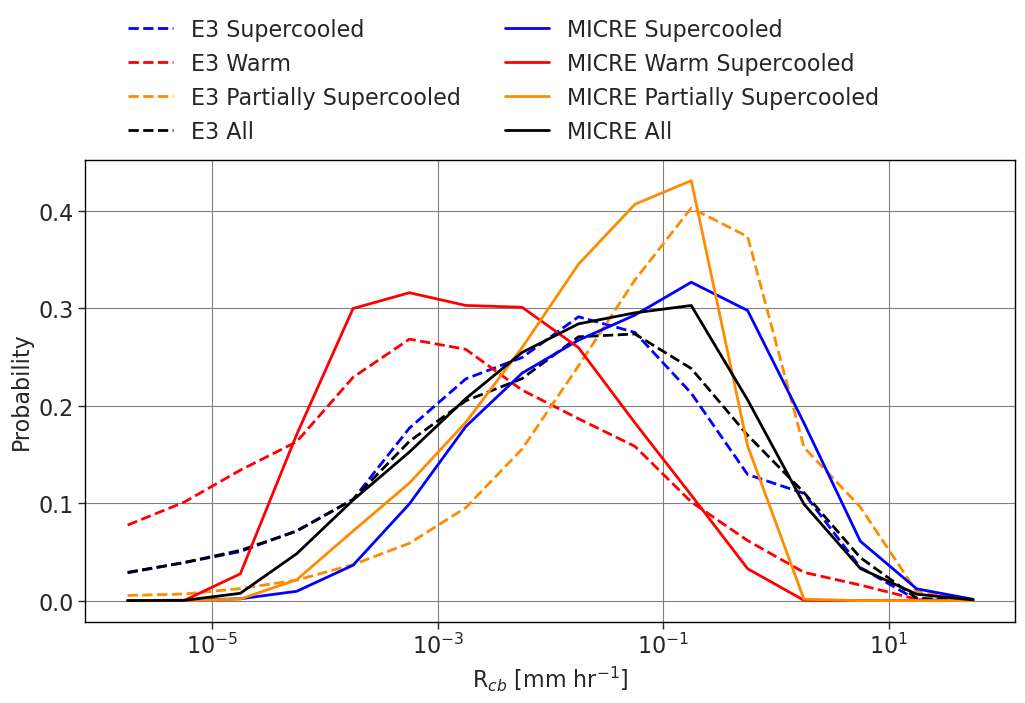

done


In [11]:
#----------------------------------------------------
#----------------------------------------------------
#----------------------------------------------------
# Rcb PDFs
#----------------------------------------------------
#----------------------------------------------------
#----------------------------------------------------

# Read in observational Rcb PDF
path = '/mnt/raid/mwstanfo/micre/'
infile = path+'micre_rcb_pdf_dict.p'
rcb_pdf_dict = pickle.load(open(infile,"rb"))


##sns.set_style('darkgrid',{"axes.facecolor": "grey"})
sns.set_theme()
sns.set_style('ticks')
#sns.set_style('darkgrid')
sns.set(rc={'axes.facecolor':'white','axes.edgecolor': 'black'})
sns.set_context('paper')

#matplotlib.rcParams.update(matplotlib.rcParamsDefault)
dumlw=2
Fontsize=16
fig = plt.figure(figsize=(12,6))
ax0 = fig.add_subplot(111)      

ax0.grid(which='both',ls='solid',color='grey')
ax0.tick_params(labelsize=Fontsize)
ax0.set_xlabel('R$_{cb}$ [mm hr$^{-1}$]',fontsize=Fontsize)
ax0.set_ylabel('Probability',fontsize=Fontsize)
ax0.set_xscale('log')


R_bins = np.arange(-6.,2.5,0.5)
midbins = np.array([(R_bins[ii]+R_bins[ii+1])/2. for ii in range(len(R_bins)-1)])


#------------------------------------
# Overarching distributions
#------------------------------------
dum_precip_binary = e3_dict['precip_binary'].copy()
dum_ctt = e3_dict['ctt'].copy()-273.15
dum_cbt = e3_dict['cbt'].copy()-273.15
dum_cth = e3_dict['cth'].copy()
dum_cbh = e3_dict['cbh'].copy()
dum_c_thick = e3_dict['c_thick'].copy()
dum_rcb = e3_dict['rcb'].copy()

precip_id = np.where((dum_precip_binary == 1.) & (dum_cbh > 250.) )

dum_rcb = dum_rcb[precip_id]
dum_ctt = dum_ctt[precip_id]
dum_cbt = dum_cbt[precip_id]
dum_cbh = dum_cbh[precip_id]
dum_c_thick = dum_c_thick[precip_id]
dum_precip_binary = dum_precip_binary[precip_id]


ice_id = np.where( (dum_precip_binary == 1.) &
                   (dum_ctt < 0.) &
                   (dum_cbt < 0.) &
                   (dum_cbh > 250.))


IWflx_lim = dum_rcb[ice_id]

liq_id = np.where( (dum_precip_binary == 1.) &
                   (dum_ctt >= 0.) &
                   (dum_cbt >= 0.) &
                   (dum_cbh > 250.))

LWflx_lim = dum_rcb[liq_id]

cold_id = np.where( (dum_precip_binary == 1.) &
                   (dum_ctt < 0.) &
                   (dum_cbt >= 0.) &
                   (dum_cbh > 250.))

LWflx_coldctt_lim = dum_rcb[cold_id]


dum_rcb = np.concatenate((IWflx_lim,LWflx_lim,LWflx_coldctt_lim))

# Ice
a,bin_edges = np.histogram(np.log10(IWflx_lim),bins=R_bins,density=True)
samp_size = np.size(IWflx_lim)
samp_size_perc = np.around(samp_size/np.size(precip_id)*100.,2)
ax0.plot(10.**(midbins),a,lw=dumlw,c='blue',label='E3 Supercooled',ls='dashed')


# Liquid
a,bin_edges = np.histogram(np.log10(LWflx_lim),bins=R_bins,density=True)
samp_size = np.size(LWflx_lim)
samp_size_perc = np.around(samp_size/np.size(precip_id)*100.,2)
ax0.plot(10.**(midbins),a,lw=dumlw,c='red',label='E3 Warm',ls='dashed')

# Liquid with cold CTTs
samp_size = np.size(LWflx_coldctt_lim)
samp_size_perc = np.around(samp_size/np.size(precip_id)*100.,2)
a,bin_edges = np.histogram(np.log10(LWflx_coldctt_lim),bins=R_bins,density=True)
ax0.plot(10.**(midbins),a,lw=dumlw,c='darkorange',label='E3 Partially Supercooled',ls='dashed')

#All
a,bin_edges = np.histogram(np.log10(dum_rcb),bins=R_bins,density=True)
samp_size = np.size(dum_rcb)
ax0.plot(10.**(midbins),a,lw=dumlw,c='black',label='E3 All',ls='dashed')

# Plot observed
ax0.plot(10.**(midbins),rcb_pdf_dict['supercooled'],lw=2,c='blue',ls='solid',label='MICRE Supercooled')
ax0.plot(10.**(midbins),rcb_pdf_dict['warm'],lw=2,c='red',ls='solid',label='MICRE Warm Supercooled')
ax0.plot(10.**(midbins),rcb_pdf_dict['partially_supercooled'],lw=2,c='darkorange',ls='solid',label='MICRE Partially Supercooled')
ax0.plot(10.**(midbins),rcb_pdf_dict['all'],lw=2,c='black',ls='solid',label='MICRE All')


ax0.legend(fontsize=Fontsize,loc='upper center',bbox_to_anchor=(0.45,1.35),ncol=2,framealpha=0)

ax0.xaxis.tick_bottom()
ax0.yaxis.tick_left()

plt.show()
plt.close()
print('done')

In [54]:
rcb_pdf_dict.keys()

dict_keys(['supercooled', 'supercooled_samp_size_perc', 'supercooled_samp_size', 'warm', 'warm_samp_size_perc', 'warm_samp_size', 'partially_supercooled', 'partially_supercooled_samp_size_perc', 'partially_supercooled_samp_size', 'all', 'all_samp_size'])

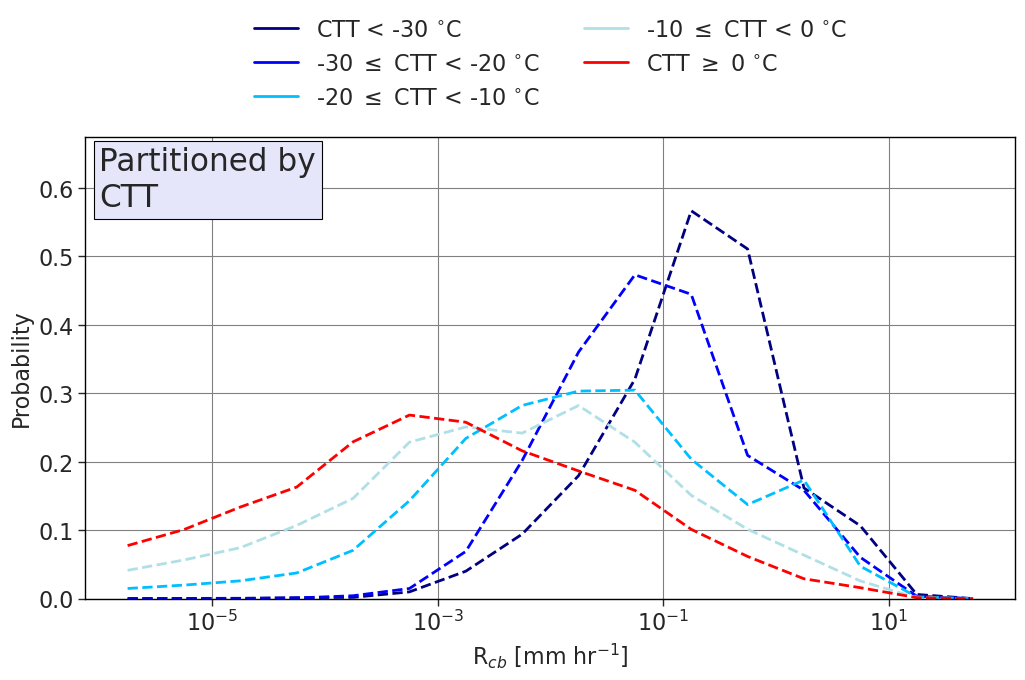

done


In [63]:
#----------------------------------------------------
#----------------------------------------------------
#----------------------------------------------------
# Rcb PDFs
#----------------------------------------------------
#----------------------------------------------------
#----------------------------------------------------

# Read in observational Rcb PDF
path = '/mnt/raid/mwstanfo/micre/'
infile = path+'micre_rcb_pdf_dict.p'
rcb_pdf_dict = pickle.load(open(infile,"rb"))


##sns.set_style('darkgrid',{"axes.facecolor": "grey"})
sns.set_theme()
sns.set_style('ticks')
#sns.set_style('darkgrid')
sns.set(rc={'axes.facecolor':'white','axes.edgecolor': 'black'})
sns.set_context('paper')

#matplotlib.rcParams.update(matplotlib.rcParamsDefault)
dumlw=2
Fontsize=16
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(111)      

ax1.grid(which='both',ls='solid',color='grey')
ax1.tick_params(labelsize=Fontsize)
ax1.set_xlabel('R$_{cb}$ [mm hr$^{-1}$]',fontsize=Fontsize)
ax1.set_ylabel('Probability',fontsize=Fontsize)
ax1.set_xscale('log')


R_bins = np.arange(-6.,2.5,0.5)
midbins = np.array([(R_bins[ii]+R_bins[ii+1])/2. for ii in range(len(R_bins)-1)])


#------------------------------------
# Partitioned by CTT
#------------------------------------
dum_precip_binary = e3_dict['precip_binary'].copy()
dum_ctt = e3_dict['ctt'].copy()-273.15
dum_cbt = e3_dict['cbt'].copy()-273.15
dum_cth = e3_dict['cth'].copy()
dum_cbh = e3_dict['cbh'].copy()
dum_c_thick = e3_dict['c_thick'].copy()
dum_rcb = e3_dict['rcb'].copy()

precip_id = np.where((dum_precip_binary == 1.)  & (dum_cbh > 250.))

dum_rcb = dum_rcb[precip_id]
dum_ctt = dum_ctt[precip_id]
dum_cbt = dum_cbt[precip_id]
dum_c_thick = dum_c_thick[precip_id]
dum_precip_binary = dum_precip_binary[precip_id]
dum_cbh = dum_cbh[precip_id]

ice_id = np.where((dum_precip_binary == 1.) &
                  (dum_ctt < 0.) &
                  (dum_cbt < 0.) &
                  (dum_cbh > 250.))


IWflx_lim = dum_rcb[ice_id]
ctt_super = dum_ctt[ice_id]

liq_id = np.where((dum_precip_binary == 1.) &
                  (dum_ctt >= 0.) &
                  (dum_cbt >= 0.) &
                  (dum_cbh > 250.))

LWflx_lim = dum_rcb[liq_id]
ctt_warm = dum_ctt[liq_id]

cold_id = np.where((dum_precip_binary == 1.) &
                  (dum_ctt < 0.) &
                  (dum_cbh > 250.) &
                  (dum_cbt >= 0.))

LWflx_coldctt_lim = dum_rcb[cold_id]
ctt_cold = dum_ctt[cold_id]

dum_rcb = np.concatenate((IWflx_lim,LWflx_lim,LWflx_coldctt_lim))
tmp_ctt = np.concatenate((ctt_super,ctt_warm,ctt_cold))

tmpid = np.where(tmp_ctt < -30.)
rcb_lt30 = dum_rcb[tmpid]
tmpid = np.where((tmp_ctt >= -30.) & (tmp_ctt < -20.))
rcb_30to20 = dum_rcb[tmpid]
tmpid = np.where((tmp_ctt >= -20.) & (tmp_ctt <-10.))
rcb_20to10 = dum_rcb[tmpid]
tmpid = np.where((tmp_ctt >= -10.) & (tmp_ctt < 0.))
rcb_10to0 = dum_rcb[tmpid]
tmpid = np.where(tmp_ctt > 0.)
rcb_gt0 = dum_rcb[tmpid]

rcb_lt30 = rcb_lt30[rcb_lt30 > 0.]
rcb_30to20 = rcb_30to20[rcb_30to20 > 0.]
rcb_20to10 = rcb_20to10[rcb_20to10 > 0.]
rcb_10to0 = rcb_10to0[rcb_10to0 > 0.]
rcb_gt0 = rcb_gt0[rcb_gt0 > 0.]


R_bins = np.arange(-6.,2.5,0.5)
midbins = np.array([(R_bins[ii]+R_bins[ii+1])/2. for ii in range(len(R_bins)-1)])



# lt -30
a,bin_edges = np.histogram(np.log10(rcb_lt30),bins=R_bins,density=True)
samp_size = np.size(rcb_lt30)
ax1.plot(10.**(midbins),a,lw=dumlw,c='navy',label='CTT < -30 $^{\\circ}$C',ls='dashed')

# -30 to -20
a,bin_edges = np.histogram(np.log10(rcb_30to20),bins=R_bins,density=True)
samp_size = np.size(rcb_30to20)
ax1.plot(10.**(midbins),a,lw=dumlw,c='blue',label='-30 $\leq$ CTT < -20 $^{\\circ}$C',ls='dashed')

# -20 to -10
a,bin_edges = np.histogram(np.log10(rcb_20to10),bins=R_bins,density=True)
samp_size = np.size(rcb_20to10)
ax1.plot(10.**(midbins),a,lw=dumlw,c='deepskyblue',label='-20 $\leq$ CTT < -10$^{\\circ}$C',ls='dashed')

# -10 to -0
a,bin_edges = np.histogram(np.log10(rcb_10to0),bins=R_bins,density=True)
samp_size = np.size(rcb_10to0)
ax1.plot(10.**(midbins),a,lw=dumlw,c='powderblue',label='-10 $\leq$ CTT < 0$^{\\circ}$C',ls='dashed')

# gt 0
a,bin_edges = np.histogram(np.log10(rcb_gt0),bins=R_bins,density=True)
samp_size = np.size(rcb_gt0)
ax1.plot(10.**(midbins),a,lw=dumlw,c='red',label='CTT $\geq$ 0$^{\\circ}$C',ls='dashed')


dum1=ax1.text(0.015,0.85,'Partitioned by\nCTT',fontsize=Fontsize*1.4,transform=ax1.transAxes)
dum1.set_bbox(dict(facecolor='lavender', alpha=1, edgecolor='black'))

# Read in observational Rcb PDF
path = '/mnt/raid/mwstanfo/micre/'
infile = path+'micre_rcb_pdf_dict_ctt.p'
rcb_pdf_dict_ctt = pickle.load(open(infile,"rb"))
# Plot observed
#ax1.plot(10.**(midbins),rcb_pdf_dict_ctt['-30'],lw=2,c='navy')
#ax1.plot(10.**(midbins),rcb_pdf_dict_ctt['-20'],lw=2,c='blue')
#ax1.plot(10.**(midbins),rcb_pdf_dict_ctt['-10'],lw=2,c='deepskyblue')
#ax1.plot(10.**(midbins),rcb_pdf_dict_ctt['0'],lw=2,c='powderblue')
#ax1.plot(10.**(midbins),rcb_pdf_dict_ctt['gt0'],lw=2,c='red')

#ax1.legend(fontsize=Fontsize,bbox_to_anchor=(0.5,1.3),ncol=2,loc='upper center',framealpha=0)

legend_elements = [Line2D([0], [0], label='CTT < -30 $^{\\circ}$C',lw=2,c='navy',ls='solid'),\
                   Line2D([0], [0], label='-30 $\leq$ CTT < -20 $^{\\circ}$C',lw=2,c='blue',ls='solid'),\
                   Line2D([0], [0], label='-20 $\leq$ CTT < -10 $^{\\circ}$C',lw=2,c='deepskyblue',ls='solid'),\
                   Line2D([0], [0], label='-10 $\leq$ CTT < 0 $^{\\circ}$C',lw=2,c='powderblue',ls='solid'),\
                   Line2D([0], [0], label='CTT $\geq$ 0 $^{\\circ}$C',lw=2,c='red',ls='solid'),\
                  ]

lgnd2 = ax1.legend(handles=legend_elements,fontsize=Fontsize,loc='upper center',framealpha=0,bbox_to_anchor=(0.5,1.3),ncol=2)

ax1.xaxis.tick_bottom()
ax1.yaxis.tick_left()
ax1.set_ylim(0,0.675)

plt.show()
plt.close()
print('done')

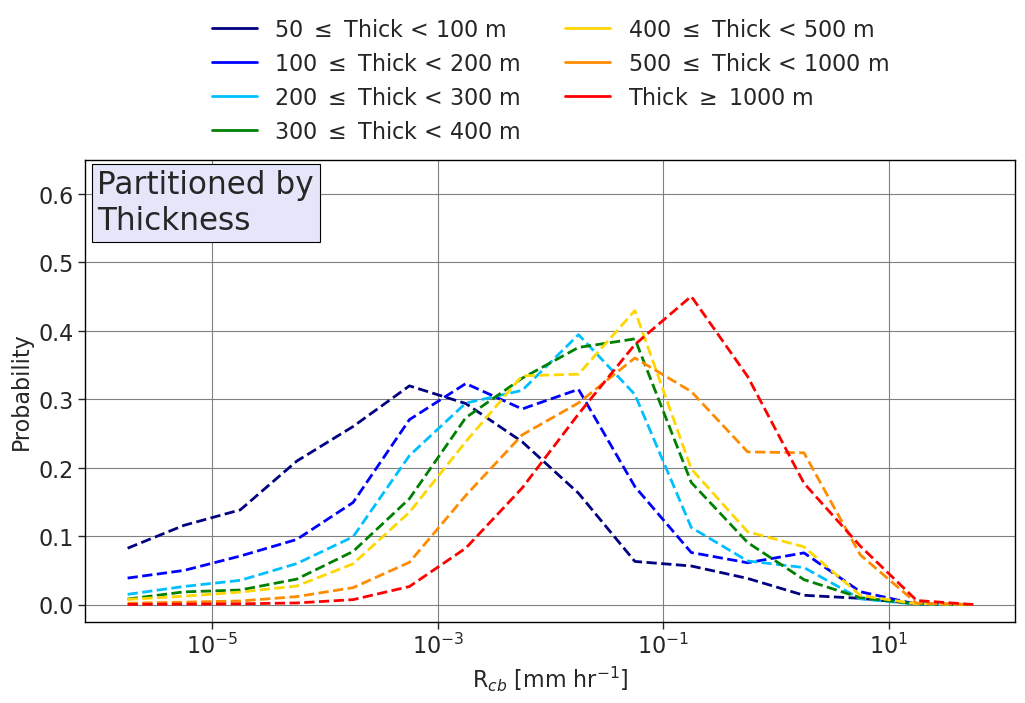

done


In [65]:
#----------------------------------------------------
#----------------------------------------------------
#----------------------------------------------------
# Rcb PDFs
#----------------------------------------------------
#----------------------------------------------------
#----------------------------------------------------

# Read in observational Rcb PDF
path = '/mnt/raid/mwstanfo/micre/'
infile = path+'micre_rcb_pdf_dict.p'
rcb_pdf_dict = pickle.load(open(infile,"rb"))


##sns.set_style('darkgrid',{"axes.facecolor": "grey"})
sns.set_theme()
sns.set_style('ticks')
#sns.set_style('darkgrid')
sns.set(rc={'axes.facecolor':'white','axes.edgecolor': 'black'})
sns.set_context('paper')

#matplotlib.rcParams.update(matplotlib.rcParamsDefault)
dumlw=2
Fontsize=16
fig = plt.figure(figsize=(12,6))
ax2 = fig.add_subplot(111)      

ax2.grid(which='both',ls='solid',color='grey')
ax2.tick_params(labelsize=Fontsize)
ax2.set_xlabel('R$_{cb}$ [mm hr$^{-1}$]',fontsize=Fontsize)
ax2.set_ylabel('Probability',fontsize=Fontsize)
ax2.set_xscale('log')


R_bins = np.arange(-6.,2.5,0.5)
midbins = np.array([(R_bins[ii]+R_bins[ii+1])/2. for ii in range(len(R_bins)-1)])


dum_thresh = 6*60.*60.
#------------------------------------
# Partitioned by c_thick
#------------------------------------
dum_precip_binary = e3_dict['precip_binary'].copy()
dum_ctt = e3_dict['ctt'].copy()-273.15
dum_cbt = e3_dict['cbt'].copy()-273.15
dum_cth = e3_dict['cth'].copy()
dum_cbh = e3_dict['cbh'].copy()
dum_c_thick = e3_dict['c_thick'].copy()
dum_rcb = e3_dict['rcb'].copy()

precip_id = np.where((dum_precip_binary == 1.) & (dum_cbh > 250.) )

dum_rcb = dum_rcb[precip_id]
dum_ctt = dum_ctt[precip_id]
dum_cbt = dum_cbt[precip_id]
dum_cbh = dum_cbh[precip_id]
dum_c_thick = dum_c_thick[precip_id]
dum_precip_binary = dum_precip_binary[precip_id]





tmpid = np.where((dum_c_thick >= 50.) & (dum_c_thick < 100))
rcb_50to100 = dum_rcb[tmpid]
tmpid = np.where((dum_c_thick >= 100) & (dum_c_thick < 200))
rcb_100to200 = dum_rcb[tmpid]
tmpid = np.where((dum_c_thick >= 200) & (dum_c_thick < 300))
rcb_200to300 = dum_rcb[tmpid]
tmpid = np.where((dum_c_thick >= 300) & (dum_c_thick < 400))
rcb_300to400 = dum_rcb[tmpid]
tmpid = np.where((dum_c_thick >= 400) & (dum_c_thick < 500))
rcb_400to500 = dum_rcb[tmpid]    
tmpid = np.where((dum_c_thick >= 500) & (dum_c_thick < 1000))
rcb_500to1000 = dum_rcb[tmpid]     
tmpid = np.where((dum_c_thick > 1000))
rcb_gt1000 = dum_rcb[tmpid]      


rcb_50to100 = rcb_50to100[rcb_50to100 > 0.]
rcb_100to200 = rcb_100to200[rcb_100to200 > 0.]
rcb_200to300 = rcb_200to300[rcb_200to300 > 0.]
rcb_300to400 = rcb_300to400[rcb_300to400 > 0.]
rcb_400to500 = rcb_400to500[rcb_400to500 > 0.]
rcb_500to1000 = rcb_500to1000[rcb_500to1000 > 0.]


# 50 < thick < 100
a,bin_edges = np.histogram(np.log10(rcb_50to100),bins=R_bins,density=True)
samp_size = np.size(rcb_50to100)
ax2.plot(10.**(midbins),a,lw=dumlw,c='navy',label='50 $\leq$ Thick < 100 m',ls='dashed')

# 100 < thick < 200
a,bin_edges = np.histogram(np.log10(rcb_100to200),bins=R_bins,density=True)
samp_size = np.size(rcb_100to200)
ax2.plot(10.**(midbins),a,lw=dumlw,c='blue',label='100 $\leq$ Thick < 200 m',ls='dashed')

# 200 < thick < 300
a,bin_edges = np.histogram(np.log10(rcb_200to300),bins=R_bins,density=True)
samp_size = np.size(rcb_200to300)
ax2.plot(10.**(midbins),a,lw=dumlw,c='deepskyblue',label='200 $\leq$ Thick < 300 m',ls='dashed')

# 300 < thick < 400
a,bin_edges = np.histogram(np.log10(rcb_300to400),bins=R_bins,density=True)
samp_size = np.size(rcb_300to400)
ax2.plot(10.**(midbins),a,lw=dumlw,c='green',label='300 $\leq$ Thick < 400 m',ls='dashed')

# 400 < thick < 500
a,bin_edges = np.histogram(np.log10(rcb_400to500),bins=R_bins,density=True)
samp_size = np.size(rcb_400to500)
ax2.plot(10.**(midbins),a,lw=dumlw,c='gold',label='400 $\leq$ Thick < 500 m',ls='dashed')

# 500 < thick < 1000
a,bin_edges = np.histogram(np.log10(rcb_500to1000),bins=R_bins,density=True)
samp_size = np.size(rcb_500to1000)
ax2.plot(10.**(midbins),a,lw=dumlw,c='darkorange',label='500 $\leq$ Thick < 1000 m',ls='dashed') 

# thick > 1000
a,bin_edges = np.histogram(np.log10(rcb_gt1000),bins=R_bins,density=True)
samp_size = np.size(rcb_gt1000)
ax2.plot(10.**(midbins),a,lw=dumlw,c='red',label='Thick $\geq$ 1000 m',ls='dashed')



dum2=ax2.text(0.013,0.85,'Partitioned by\nThickness',fontsize=Fontsize*1.4,transform=ax2.transAxes)

dum2.set_bbox(dict(facecolor='lavender', alpha=1, edgecolor='black'))


ax2.legend(fontsize=Fontsize,bbox_to_anchor=(0.51,1.35),ncol=2,loc='upper center',framealpha=0,columnspacing=0.5)

ax2.xaxis.tick_bottom()
ax2.yaxis.tick_left()

ax2.set_ylim(-0.025,0.65)

# Read in observational Rcb PDF
path = '/mnt/raid/mwstanfo/micre/'
infile = path+'micre_rcb_pdf_dict_cthick.p'
rcb_pdf_dict_cthick = pickle.load(open(infile,"rb"))
# Plot observed
#ax2.plot(10.**(midbins),rcb_pdf_dict_cthick['50_to_100'],lw=2,c='navy')
#ax2.plot(10.**(midbins),rcb_pdf_dict_cthick['100_to_200'],lw=2,c='blue')
#ax2.plot(10.**(midbins),rcb_pdf_dict_cthick['200_to_300'],lw=2,c='deepskyblue')
#ax2.plot(10.**(midbins),rcb_pdf_dict_cthick['300_to_400'],lw=2,c='green')
#ax2.plot(10.**(midbins),rcb_pdf_dict_cthick['400_to_500'],lw=2,c='gold')
#ax2.plot(10.**(midbins),rcb_pdf_dict_cthick['500_to_1000'],lw=2,c='darkorange')
#ax2.plot(10.**(midbins),rcb_pdf_dict_cthick['gt1000'],lw=2,c='red')

#ax1.legend(fontsize=Fontsize,bbox_to_anchor=(0.5,1.3),ncol=2,loc='upper center',framealpha=0)

legend_elements = [Line2D([0], [0], label='50 $\leq$ Thick < 100 m',lw=2,c='navy',ls='solid'),\
                   Line2D([0], [0], label='100 $\leq$ Thick < 200 m',lw=2,c='blue',ls='solid'),\
                   Line2D([0], [0], label='200 $\leq$ Thick < 300 m',lw=2,c='deepskyblue',ls='solid'),\
                   Line2D([0], [0], label='300 $\leq$ Thick < 400 m',lw=2,c='green',ls='solid'),\
                   Line2D([0], [0], label='400 $\leq$ Thick < 500 m',lw=2,c='gold',ls='solid'),\
                   Line2D([0], [0], label='500 $\leq$ Thick < 1000 m',lw=2,c='darkorange',ls='solid'),\
                   Line2D([0], [0], label='Thick $\geq$ 1000 m',lw=2,c='red',ls='solid'),\
                  ]

lgnd2 = ax2.legend(handles=legend_elements,fontsize=Fontsize,loc='upper center',framealpha=0,bbox_to_anchor=(0.5,1.35),ncol=2)

plt.show()
plt.close()
print('done')

In [12]:
#----------------------------------------------------
#----------------------------------------------------
#----------------------------------------------------
# Rcb PDFs
#----------------------------------------------------
#----------------------------------------------------
#----------------------------------------------------

# Read in observational Rcb PDF
path = '/mnt/raid/mwstanfo/micre/'
infile = path+'micre_rcb_pdf_dict.p'
rcb_pdf_dict = pickle.load(open(infile,"rb"))


##sns.set_style('darkgrid',{"axes.facecolor": "grey"})
sns.set_theme()
sns.set_style('ticks')
#sns.set_style('darkgrid')
sns.set(rc={'axes.facecolor':'white','axes.edgecolor': 'black'})
sns.set_context('paper')

#matplotlib.rcParams.update(matplotlib.rcParamsDefault)
dumlw=2
Fontsize=16
fig = plt.figure(figsize=(12,10))
gs=GridSpec(2,6) # 2 rows, 6 columns
ax0 = fig.add_subplot(gs[0,1:5])
ax1 = fig.add_subplot(gs[1,0:3])       
ax2 = fig.add_subplot(gs[1,3:6])       

ax0.grid(which='both',ls='solid',color='grey')
ax1.grid(which='both',ls='solid',color='grey')
ax2.grid(which='both',ls='solid',color='grey')
ax0.tick_params(labelsize=Fontsize)
ax1.tick_params(labelsize=Fontsize)
ax2.tick_params(labelsize=Fontsize)
ax0.set_xlabel('R$_{cb}$ [mm hr$^{-1}$]',fontsize=Fontsize)
ax1.set_xlabel('R$_{cb}$ [mm hr$^{-1}$]',fontsize=Fontsize)
ax2.set_xlabel('R$_{cb}$ [mm hr$^{-1}$]',fontsize=Fontsize)
ax0.set_ylabel('Probability',fontsize=Fontsize)
ax1.set_ylabel('Probability',fontsize=Fontsize)
ax2.set_ylabel('Probability',fontsize=Fontsize)
ax0.set_xscale('log')
ax1.set_xscale('log')
ax2.set_xscale('log')


R_bins = np.arange(-6.,2.5,0.5)
midbins = np.array([(R_bins[ii]+R_bins[ii+1])/2. for ii in range(len(R_bins)-1)])


#------------------------------------
# Overarching distributions
#------------------------------------
dum_precip_binary = e3_dict['precip_binary'].copy()
dum_ctt = e3_dict['ctt'].copy()-273.15
dum_cbt = e3_dict['cbt'].copy()-273.15
dum_cth = e3_dict['cth'].copy()
dum_cbh = e3_dict['cbh'].copy()
dum_c_thick = e3_dict['c_thick'].copy()
dum_rcb = e3_dict['rcb'].copy()

precip_id = np.where((dum_precip_binary == 1.) & (dum_cbh > 250.) )

dum_rcb = dum_rcb[precip_id]
dum_ctt = dum_ctt[precip_id]
dum_cbt = dum_cbt[precip_id]
dum_cbh = dum_cbh[precip_id]
dum_c_thick = dum_c_thick[precip_id]
dum_precip_binary = dum_precip_binary[precip_id]


ice_id = np.where( (dum_precip_binary == 1.) &
                   (dum_ctt < 0.) &
                   (dum_cbt < 0.) &
                   (dum_cbh > 250.))


IWflx_lim = dum_rcb[ice_id]

liq_id = np.where( (dum_precip_binary == 1.) &
                   (dum_ctt >= 0.) &
                   (dum_cbt >= 0.) &
                   (dum_cbh > 250.))

LWflx_lim = dum_rcb[liq_id]

cold_id = np.where( (dum_precip_binary == 1.) &
                   (dum_ctt < 0.) &
                   (dum_cbt >= 0.) &
                   (dum_cbh > 250.))

LWflx_coldctt_lim = dum_rcb[cold_id]


dum_rcb = np.concatenate((IWflx_lim,LWflx_lim,LWflx_coldctt_lim))

# Ice
a,bin_edges = np.histogram(np.log10(IWflx_lim),bins=R_bins,density=True)
samp_size = np.size(IWflx_lim)
samp_size_perc = np.around(samp_size/np.size(precip_id)*100.,2)
#ax0.plot(10.**(midbins),a,lw=3,c='blue',ls='dashed',label='E3 Supercooled, N={} ({}%)'.format(samp_size,samp_size_perc))
ax0.plot(10.**(midbins),a,lw=dumlw,c='blue',label='E3 Supercooled',ls='dashed')


# Liquid
a,bin_edges = np.histogram(np.log10(LWflx_lim),bins=R_bins,density=True)
samp_size = np.size(LWflx_lim)
samp_size_perc = np.around(samp_size/np.size(precip_id)*100.,2)
#ax0.plot(10.**(midbins),a,lw=3,c='red',ls='dashed',label='E3 Warm, N={} ({}%)'.format(samp_size,samp_size_perc))
ax0.plot(10.**(midbins),a,lw=dumlw,c='red',label='E3 Warm',ls='dashed')

# Liquid with cold CTTs
samp_size = np.size(LWflx_coldctt_lim)
samp_size_perc = np.around(samp_size/np.size(precip_id)*100.,2)
a,bin_edges = np.histogram(np.log10(LWflx_coldctt_lim),bins=R_bins,density=True)
#ax0.plot(10.**(midbins),a,lw=3,c='darkorange',ls='dashed',label='E3 Partially Supercooled, N={} ({}%)'.format(samp_size,samp_size_perc))
ax0.plot(10.**(midbins),a,lw=dumlw,c='darkorange',label='E3 Partially Supercooled',ls='dashed')

#All
a,bin_edges = np.histogram(np.log10(dum_rcb),bins=R_bins,density=True)
samp_size = np.size(dum_rcb)
#ax0.plot(10.**(midbins),a,lw=3,c='black',ls='dashed',label='E3 All, N={}'.format(samp_size))
ax0.plot(10.**(midbins),a,lw=dumlw,c='black',label='E3 All',ls='dashed')

# Plot observed
ax0.plot(10.**(midbins),rcb_pdf_dict['supercooled'],lw=2,c='blue',ls='solid',label='MICRE Supercooled')
ax0.plot(10.**(midbins),rcb_pdf_dict['warm'],lw=2,c='red',ls='solid',label='MICRE Warm Supercooled')
ax0.plot(10.**(midbins),rcb_pdf_dict['partially_supercooled'],lw=2,c='darkorange',ls='solid',label='MICRE Partially Supercooled')
ax0.plot(10.**(midbins),rcb_pdf_dict['all'],lw=2,c='black',ls='solid',label='MICRE All')


#------------------------------------
# Partitioned by CTT
#------------------------------------
dum_precip_binary = e3_dict['precip_binary'].copy()
dum_ctt = e3_dict['ctt'].copy()-273.15
dum_cbt = e3_dict['cbt'].copy()-273.15
dum_cth = e3_dict['cth'].copy()
dum_cbh = e3_dict['cbh'].copy()
dum_c_thick = e3_dict['c_thick'].copy()
dum_rcb = e3_dict['rcb'].copy()

precip_id = np.where((dum_precip_binary == 1.)  & (dum_cbh > 250.))

dum_rcb = dum_rcb[precip_id]
dum_ctt = dum_ctt[precip_id]
dum_cbt = dum_cbt[precip_id]
dum_c_thick = dum_c_thick[precip_id]
dum_precip_binary = dum_precip_binary[precip_id]
dum_cbh = dum_cbh[precip_id]

ice_id = np.where((dum_precip_binary == 1.) &
                  (dum_ctt < 0.) &
                  (dum_cbt < 0.) &
                  (dum_cbh > 250.))


IWflx_lim = dum_rcb[ice_id]
ctt_super = dum_ctt[ice_id]

liq_id = np.where((dum_precip_binary == 1.) &
                  (dum_ctt >= 0.) &
                  (dum_cbt >= 0.) &
                  (dum_cbh > 250.))

LWflx_lim = dum_rcb[liq_id]
ctt_warm = dum_ctt[liq_id]

cold_id = np.where((dum_precip_binary == 1.) &
                  (dum_ctt < 0.) &
                  (dum_cbh > 250.) &
                  (dum_cbt >= 0.))

LWflx_coldctt_lim = dum_rcb[cold_id]
ctt_cold = dum_ctt[cold_id]

dum_rcb = np.concatenate((IWflx_lim,LWflx_lim,LWflx_coldctt_lim))
tmp_ctt = np.concatenate((ctt_super,ctt_warm,ctt_cold))

tmpid = np.where(tmp_ctt < -30.)
rcb_lt30 = dum_rcb[tmpid]
tmpid = np.where((tmp_ctt >= -30.) & (tmp_ctt < -20.))
rcb_30to20 = dum_rcb[tmpid]
tmpid = np.where((tmp_ctt >= -20.) & (tmp_ctt <-10.))
rcb_20to10 = dum_rcb[tmpid]
tmpid = np.where((tmp_ctt >= -10.) & (tmp_ctt < 0.))
rcb_10to0 = dum_rcb[tmpid]
tmpid = np.where(tmp_ctt > 0.)
rcb_gt0 = dum_rcb[tmpid]

rcb_lt30 = rcb_lt30[rcb_lt30 > 0.]
rcb_30to20 = rcb_30to20[rcb_30to20 > 0.]
rcb_20to10 = rcb_20to10[rcb_20to10 > 0.]
rcb_10to0 = rcb_10to0[rcb_10to0 > 0.]
rcb_gt0 = rcb_gt0[rcb_gt0 > 0.]


R_bins = np.arange(-6.,2.5,0.5)
midbins = np.array([(R_bins[ii]+R_bins[ii+1])/2. for ii in range(len(R_bins)-1)])




# lt -30
a,bin_edges = np.histogram(np.log10(rcb_lt30),bins=R_bins,density=True)
samp_size = np.size(rcb_lt30)
#ax1.plot(10.**(midbins),a,lw=3,c='navy',label='CTT < -30 $^{\\circ}$C, N='+str(samp_size))
ax1.plot(10.**(midbins),a,lw=dumlw,c='navy',label='CTT < -30 $^{\\circ}$C',ls='dashed')

# -30 to -20
a,bin_edges = np.histogram(np.log10(rcb_30to20),bins=R_bins,density=True)
samp_size = np.size(rcb_30to20)
#ax1.plot(10.**(midbins),a,lw=3,c='blue',label='-30 $\leq$ CTT < -20 $^{\\circ}$C, N='+str(samp_size))
ax1.plot(10.**(midbins),a,lw=dumlw,c='blue',label='-30 $\leq$ CTT < -20 $^{\\circ}$C',ls='dashed')

# -20 to -10
a,bin_edges = np.histogram(np.log10(rcb_20to10),bins=R_bins,density=True)
samp_size = np.size(rcb_20to10)
#ax1.plot(10.**(midbins),a,lw=3,c='deepskyblue',label='-20 $\leq$ CTT < -10$^{\\circ}$C, N='+str(samp_size))
ax1.plot(10.**(midbins),a,lw=dumlw,c='deepskyblue',label='-20 $\leq$ CTT < -10$^{\\circ}$C',ls='dashed')

# -10 to -0
a,bin_edges = np.histogram(np.log10(rcb_10to0),bins=R_bins,density=True)
samp_size = np.size(rcb_10to0)
#ax1.plot(10.**(midbins),a,lw=3,c='powderblue',label='-10 $\leq$ CTT < 0$^{\\circ}$C, N='+str(samp_size))
ax1.plot(10.**(midbins),a,lw=dumlw,c='powderblue',label='-10 $\leq$ CTT < 0$^{\\circ}$C',ls='dashed')

# gt 0
a,bin_edges = np.histogram(np.log10(rcb_gt0),bins=R_bins,density=True)
samp_size = np.size(rcb_gt0)
#ax1.plot(10.**(midbins),a,lw=3,c='red',label='CTT > 0$^{\\circ}$C, N='+str(samp_size))
ax1.plot(10.**(midbins),a,lw=dumlw,c='red',label='CTT $\geq$ 0$^{\\circ}$C',ls='dashed')




dum_thresh = 6*60.*60.
#------------------------------------
# Partitioned by c_thick
#------------------------------------
dum_precip_binary = e3_dict['precip_binary'].copy()
dum_ctt = e3_dict['ctt'].copy()-273.15
dum_cbt = e3_dict['cbt'].copy()-273.15
dum_cth = e3_dict['cth'].copy()
dum_cbh = e3_dict['cbh'].copy()
dum_c_thick = e3_dict['c_thick'].copy()
dum_rcb = e3_dict['rcb'].copy()

precip_id = np.where((dum_precip_binary == 1.) & (dum_cbh > 250.) )

dum_rcb = dum_rcb[precip_id]
dum_ctt = dum_ctt[precip_id]
dum_cbt = dum_cbt[precip_id]
dum_cbh = dum_cbh[precip_id]
dum_c_thick = dum_c_thick[precip_id]
dum_precip_binary = dum_precip_binary[precip_id]





tmpid = np.where((dum_c_thick >= 50.) & (dum_c_thick < 100))
rcb_50to100 = dum_rcb[tmpid]
tmpid = np.where((dum_c_thick >= 100) & (dum_c_thick < 200))
rcb_100to200 = dum_rcb[tmpid]
tmpid = np.where((dum_c_thick >= 200) & (dum_c_thick < 300))
rcb_200to300 = dum_rcb[tmpid]
tmpid = np.where((dum_c_thick >= 300) & (dum_c_thick < 400))
rcb_300to400 = dum_rcb[tmpid]
tmpid = np.where((dum_c_thick >= 400) & (dum_c_thick < 500))
rcb_400to500 = dum_rcb[tmpid]    
tmpid = np.where((dum_c_thick >= 500) & (dum_c_thick < 1000))
rcb_500to1000 = dum_rcb[tmpid]     
tmpid = np.where((dum_c_thick > 1000))
rcb_gt1000 = dum_rcb[tmpid]      


rcb_50to100 = rcb_50to100[rcb_50to100 > 0.]
rcb_100to200 = rcb_100to200[rcb_100to200 > 0.]
rcb_200to300 = rcb_200to300[rcb_200to300 > 0.]
rcb_300to400 = rcb_300to400[rcb_300to400 > 0.]
rcb_400to500 = rcb_400to500[rcb_400to500 > 0.]
rcb_500to1000 = rcb_500to1000[rcb_500to1000 > 0.]


# 50 < thick < 100
a,bin_edges = np.histogram(np.log10(rcb_50to100),bins=R_bins,density=True)
samp_size = np.size(rcb_50to100)
#ax2.plot(10.**(midbins),a,lw=3,c='navy',label='50 $\leq$ Thick < 100 m, N='+str(samp_size))
ax2.plot(10.**(midbins),a,lw=dumlw,c='navy',label='50 $\leq$ Thick < 100 m',ls='dashed')

# 100 < thick < 200
a,bin_edges = np.histogram(np.log10(rcb_100to200),bins=R_bins,density=True)
samp_size = np.size(rcb_100to200)
#ax2.plot(10.**(midbins),a,lw=3,c='blue',label='100 $\leq$ Thick < 200 m, N='+str(samp_size))
ax2.plot(10.**(midbins),a,lw=dumlw,c='blue',label='100 $\leq$ Thick < 200 m',ls='dashed')

# 200 < thick < 300
a,bin_edges = np.histogram(np.log10(rcb_200to300),bins=R_bins,density=True)
samp_size = np.size(rcb_200to300)
#ax2.plot(10.**(midbins),a,lw=3,c='deepskyblue',label='200 $\leq$ Thick < 300 m, N='+str(samp_size))
ax2.plot(10.**(midbins),a,lw=dumlw,c='deepskyblue',label='200 $\leq$ Thick < 300 m',ls='dashed')

# 300 < thick < 400
a,bin_edges = np.histogram(np.log10(rcb_300to400),bins=R_bins,density=True)
samp_size = np.size(rcb_300to400)
#ax2.plot(10.**(midbins),a,lw=3,c='green',label='300 $\leq$ Thick < 400 m, N='+str(samp_size))
ax2.plot(10.**(midbins),a,lw=dumlw,c='green',label='300 $\leq$ Thick < 400 m',ls='dashed')

# 400 < thick < 500
a,bin_edges = np.histogram(np.log10(rcb_400to500),bins=R_bins,density=True)
samp_size = np.size(rcb_400to500)
#ax2.plot(10.**(midbins),a,lw=3,c='gold',label='400 $\leq$ Thick < 500 m, N='+str(samp_size))
ax2.plot(10.**(midbins),a,lw=dumlw,c='gold',label='400 $\leq$ Thick < 500 m',ls='dashed')

# 500 < thick < 1000
a,bin_edges = np.histogram(np.log10(rcb_500to1000),bins=R_bins,density=True)
samp_size = np.size(rcb_500to1000)
#ax2.plot(10.**(midbins),a,lw=3,c='darkorange',label='500 $\leq$ Thick < 1000 m, N='+str(samp_size)) 
ax2.plot(10.**(midbins),a,lw=dumlw,c='darkorange',label='500 $\leq$ Thick < 1000 m',ls='dashed') 

# thick > 1000
a,bin_edges = np.histogram(np.log10(rcb_gt1000),bins=R_bins,density=True)
samp_size = np.size(rcb_gt1000)
a#x2.plot(10.**(midbins),a,lw=3,c='red',label='Thick > 1000 m, N='+str(samp_size))
ax2.plot(10.**(midbins),a,lw=dumlw,c='red',label='Thick $\geq$ 1000 m',ls='dashed')


ax0.text(-0.125,1.05,'(a)',fontsize=Fontsize*2.5,transform=ax0.transAxes)
ax1.text(-0.15,1.05,'(b)',fontsize=Fontsize*2.5,transform=ax1.transAxes)
ax2.text(-0.17,1.05,'(c)',fontsize=Fontsize*2.5,transform=ax2.transAxes)

dum1=ax1.text(0.015,0.765,'Partitioned by\nCTT',fontsize=Fontsize*1.4,transform=ax1.transAxes)
dum2=ax2.text(0.013,0.765,'Partitioned by\nThickness',fontsize=Fontsize*1.4,transform=ax2.transAxes)

dum1.set_bbox(dict(facecolor='lavender', alpha=1, edgecolor='black'))
dum2.set_bbox(dict(facecolor='lavender', alpha=1, edgecolor='black'))

#ax0.legend(fontsize=Fontsize*0.9,loc='upper center',bbox_to_anchor=(0.55,1.4),ncol=2,framealpha=0)
#ax1.legend(fontsize=Fontsize*0.75,bbox_to_anchor=(0.5,1.4),ncol=2,loc='upper center',framealpha=0)
#ax2.legend(fontsize=Fontsize*0.75,bbox_to_anchor=(0.525,1.4),ncol=2,loc='upper center',framealpha=0,columnspacing=0.5)
ax0.legend(fontsize=Fontsize*0.65,loc='upper center',bbox_to_anchor=(0.45,1.35),ncol=2,framealpha=0)
ax1.legend(fontsize=Fontsize*0.65,bbox_to_anchor=(0.5,1.3),ncol=2,loc='upper center',framealpha=0)
ax2.legend(fontsize=Fontsize*0.65,bbox_to_anchor=(0.51,1.35),ncol=2,loc='upper center',framealpha=0,columnspacing=0.5)

plt.subplots_adjust(wspace=0.9,hspace=0.6)
ax0.xaxis.tick_bottom()
ax0.yaxis.tick_left()
ax1.xaxis.tick_bottom()
ax1.yaxis.tick_left()
ax2.xaxis.tick_bottom()
ax2.yaxis.tick_left()

ax1.set_ylim(-0.025,0.65)
ax2.set_ylim(-0.025,0.65)

fig_path = '/home/mwstanfo/figures/micre_paper/'
outfile = 'fig_11.png'
#outfile = 'fig_12.eps'
#plt.show()
plt.savefig(fig_path+outfile,dpi=200,bbox_inches='tight')
plt.close()
print('done')

done


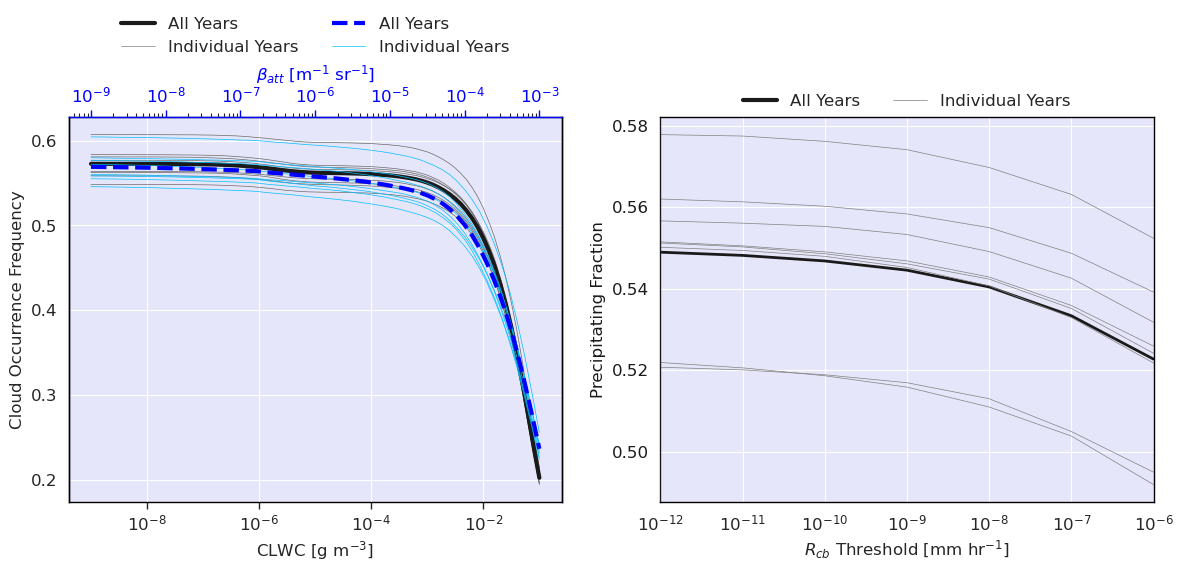

done


In [15]:
#=========================================
# E3 Cloud and Precipitation Sensitivities
# for talk, including year-to-year
# variability
#=========================================
sns.set_theme()
sns.set_style('ticks')
sns.set(rc={'axes.facecolor':'lavender','axes.edgecolor': 'black'})
sns.set_context('paper')
fig = plt.figure(figsize=(14,5))
ax1 = fig.add_subplot(121)
ax3 = fig.add_subplot(122)
Fontsize=12


#---------------------------------------------
#---------------------------------------------
# Cloud Occurrence Frequency
#---------------------------------------------
#---------------------------------------------
ax1.tick_params(labelsize=Fontsize)
ax1.set_ylabel('Cloud Occurrence Frequency',fontsize=Fontsize)
#---------------------------------------------
# CLWC Threshes
#---------------------------------------------
ax1.set_xlabel('CLWC [g m$^{-3}$]',fontsize=Fontsize)
year_size = 365*8.*8.
clwc_threshes = np.arange(-9,-0.9,0.1)
cloud_fraction = np.zeros(len(clwc_threshes))
cloud_fraction_years = np.zeros((len(clwc_threshes),8))
year_list = [2013,2014,2015,2016,2017,2018,2019,2020]
tot_size = np.size(e3_dict['tot_time'])
dumi=0
year_size = 48.*365.*8
for clwc_thresh in clwc_threshes:
    cloud_id = np.where(e3_dict['cbh'] > 0.)
    dumid = np.where(e3_dict['cb_clwc'][cloud_id]*1.e3 > 10.**(clwc_thresh)) 
    if np.size(dumid) > 0.:
        cloud_fraction[dumi] = np.size(dumid)/tot_size
        
    for jj in range(8):
        cloud_id = np.where((e3_dict['cbh'] > 0.) & (e3_dict['years'] == year_list[jj]) )
        cloud_id = np.squeeze(cloud_id)
        dumid = np.where(e3_dict['cb_clwc'][cloud_id]*1.e3 > 10.**(clwc_thresh))
        #tot_size2 = np.size(e3_dict['months'][e3_dict['years'] == year_list[jj]])
        if np.size(dumid) > 0.:
            cloud_fraction_years[dumi,jj] = np.size(dumid)/year_size
        
    dumi+=1
x = clwc_threshes
y = cloud_fraction

for jj in range(8):
    ax1.plot(10.**x,cloud_fraction_years[:,jj],lw=0.5,c='dimgrey')
    


ax1.set_xscale('log')
ax1.plot(10.**x,y,lw=3,c='k')
#---------------------------------------------
# Beta_att thresh
#---------------------------------------------
ax2 = ax1.twiny()
ax2.set_xlabel('$\\beta_{att}$ [m$^{-1}$ sr$^{-1}$]',fontsize=Fontsize,c='blue')
ax2.grid(False)
# deal with axis colors
ax2.spines['top'].set_color('blue')
ax2.xaxis.label.set_color('blue')
ax2.tick_params(axis='x', colors='blue',labelsize=Fontsize)
ax2.spines['bottom'].set_visible(False)

beta_att_threshes = np.arange(-9,-2.9,0.1)
cloud_fraction = np.zeros(len(beta_att_threshes))
cloud_fraction_years = np.zeros((len(beta_att_threshes),8))
tot_size = np.size(e3_dict['tot_time'])
dumi=0
for beta_att_thresh in beta_att_threshes:
    cloud_id = np.where(e3_dict['cbh'] > 0.)
    dumid = np.where((e3_dict['cb_beta_att'][cloud_id] > 10.**(beta_att_thresh)) )
    if np.size(dumid) > 0.:
        cloud_fraction[dumi] = np.size(dumid)/tot_size
        
    for jj in range(8):
        cloud_id = np.where((e3_dict['cbh'] > 0) & (e3_dict['years'] == year_list[jj]) )
        cloud_id = np.squeeze(cloud_id)
        dumid = np.where(e3_dict['cb_beta_att'][cloud_id] > 10.**(beta_att_thresh))
        if np.size(dumid) > 0.:
            cloud_fraction_years[dumi,jj] = np.size(dumid)/year_size            
    dumi+=1
    
x = beta_att_threshes
y = cloud_fraction

for jj in range(8):
    ax2.plot(10.**x,cloud_fraction_years[:,jj],lw=0.5,c='deepskyblue')
    

ax2.set_xscale('log')
ax2.plot(10.**x,y,lw=3,c='blue',ls='dashed')


#-----------------------------------------
# Precipitation Occurrence Frequency
#-----------------------------------------
thresh_arr = np.arange(-12,-5)
thresh_arr = 10.**thresh_arr
frac_of_dataset = np.zeros(len(thresh_arr))
precip_fracx = np.zeros(len(thresh_arr))
precip_fracx_years = np.zeros((len(thresh_arr),8))
for ii in range(len(thresh_arr)):
    
    # All Years
    dum_precip_binary = e3_dict['precip_binary'].copy()
    dum_rcb = e3_dict['rcb'].copy()
    dum_cbh = e3_dict['cbh'].copy()
    dum_years = e3_dict['years'].copy()
    
    dumid = np.where( (dum_cbh > 250.) & (~np.isnan(dum_precip_binary)))
    dum_precip_binary = dum_precip_binary[dumid]
    dum_rcb = dum_rcb[dumid]
    dum_cbh = dum_cbh[dumid]

    dumid = np.where( (dum_rcb < thresh_arr[ii]) & (dum_precip_binary == 1.))
    dum_precip_binary[dumid] = 0.
    
    precip_id = np.where(dum_precip_binary == 1.)
    tmp_precip_frac = np.size(precip_id)/np.size(dum_precip_binary)
    precip_fracx[ii] = tmp_precip_frac

    tmp_frac_of_dataset = np.size(dumid)/np.size(dum_precip_binary)
    frac_of_dataset[ii] = tmp_frac_of_dataset
    
    
    # Yearly    
    for jj in range(8):
        dum_precip_binary = e3_dict['precip_binary'].copy()
        dum_rcb = e3_dict['rcb'].copy()
        dum_cbh = e3_dict['cbh'].copy()
        dum_years = e3_dict['years'].copy()
        
        dumid = np.where( (dum_cbh > 250.) & (~np.isnan(dum_precip_binary)) & (dum_years == year_list[jj]) )
        dum_precip_binary = dum_precip_binary[dumid]
        dum_rcb = dum_rcb[dumid]
        dum_cbh = dum_cbh[dumid]        
        
        dumid = np.where( (dum_rcb < thresh_arr[ii]) & (dum_precip_binary == 1.))
        dum_precip_binary[dumid] = 0.

        precip_id = np.where(dum_precip_binary == 1.)
        tmp_precip_frac = np.size(precip_id)/np.size(dum_precip_binary)
        precip_fracx_years[ii,jj] = tmp_precip_frac     
    


#ax3a = ax3.twinx()
ax3.tick_params(labelsize=Fontsize,color='k')
#ax3a.tick_params(labelsize=Fontsize,color='blue')
#ax3a.spines['right'].set_color('blue')
ax3.spines['left'].set_color('k')
#ax3a.spines['left'].set_visible(False)
#ax3a.tick_params(axis='y', which='both',colors='blue')
ax3.tick_params(axis='y', which='both',colors='k')

ax3.set_ylabel('Precipitating Fraction',fontsize=Fontsize,c='k')
#ax3a.set_ylabel('Fraction of Precipitating Clouds',fontsize=Fontsize,c='blue')
ax3.set_xlabel('$R_{cb}$ Threshold [mm hr$^{-1}$]',fontsize=Fontsize)
ax3.set_xscale('log')
ax3.set_xlim(np.min(thresh_arr),np.max(thresh_arr))
ax3.plot(thresh_arr,precip_fracx,lw=2,c='k')
for jj in range(8):
    ax3.plot(thresh_arr,precip_fracx_years[:,jj],lw=0.5,c='grey')
#ax3a.plot(thresh_arr,frac_of_dataset,lw=2,c='blue',ls='dashed')
#ax3a.grid(False)

#ax1.text(-0.1,1.05,'(a)',fontsize=Fontsize*2.5,transform=ax1.transAxes)
#ax3.text(-0.1,1.05,'(b)',fontsize=Fontsize*2.5,transform=ax3.transAxes)

legend_elements = [Line2D([0], [0], label='All Years',lw=3,c='k',ls='solid'),\
                   Line2D([0], [0], label='Individual Years',lw=0.5,c='grey',ls='solid'),\
                   Line2D([0], [0], label='All Years',lw=3,c='blue',ls='dashed'),\
                   Line2D([0], [0], label='Individual Years',lw=0.5,c='deepskyblue',ls='solid'),\
                  ]

lgnd = ax1.legend(handles=legend_elements,fontsize=Fontsize,loc='upper center',framealpha=0,bbox_to_anchor=(0.5,1.3),ncol=2)

legend_elements = [Line2D([0], [0], label='All Years',lw=3,c='k',ls='solid'),\
                   Line2D([0], [0], label='Individual Years',lw=0.5,c='grey',ls='solid'),\
                  ]

lgnd2 = ax3.legend(handles=legend_elements,fontsize=Fontsize,loc='upper center',framealpha=0,bbox_to_anchor=(0.5,1.1),ncol=2)

fig_path = '/home/mwstanfo/figures/micre_paper/'
outfile = 'fig_g1.png'
#outfile = 'fig_g1.eps'
plt.show()
#plt.savefig(fig_path+outfile,dpi=200,bbox_inches='tight')
plt.close()
print('done')

In [28]:
np.min(ctt)

-37.999838256835915

array([-33.88053352, -27.89950064, -32.69158387, ..., -42.88483967,
       -54.11060373, -67.33449145])

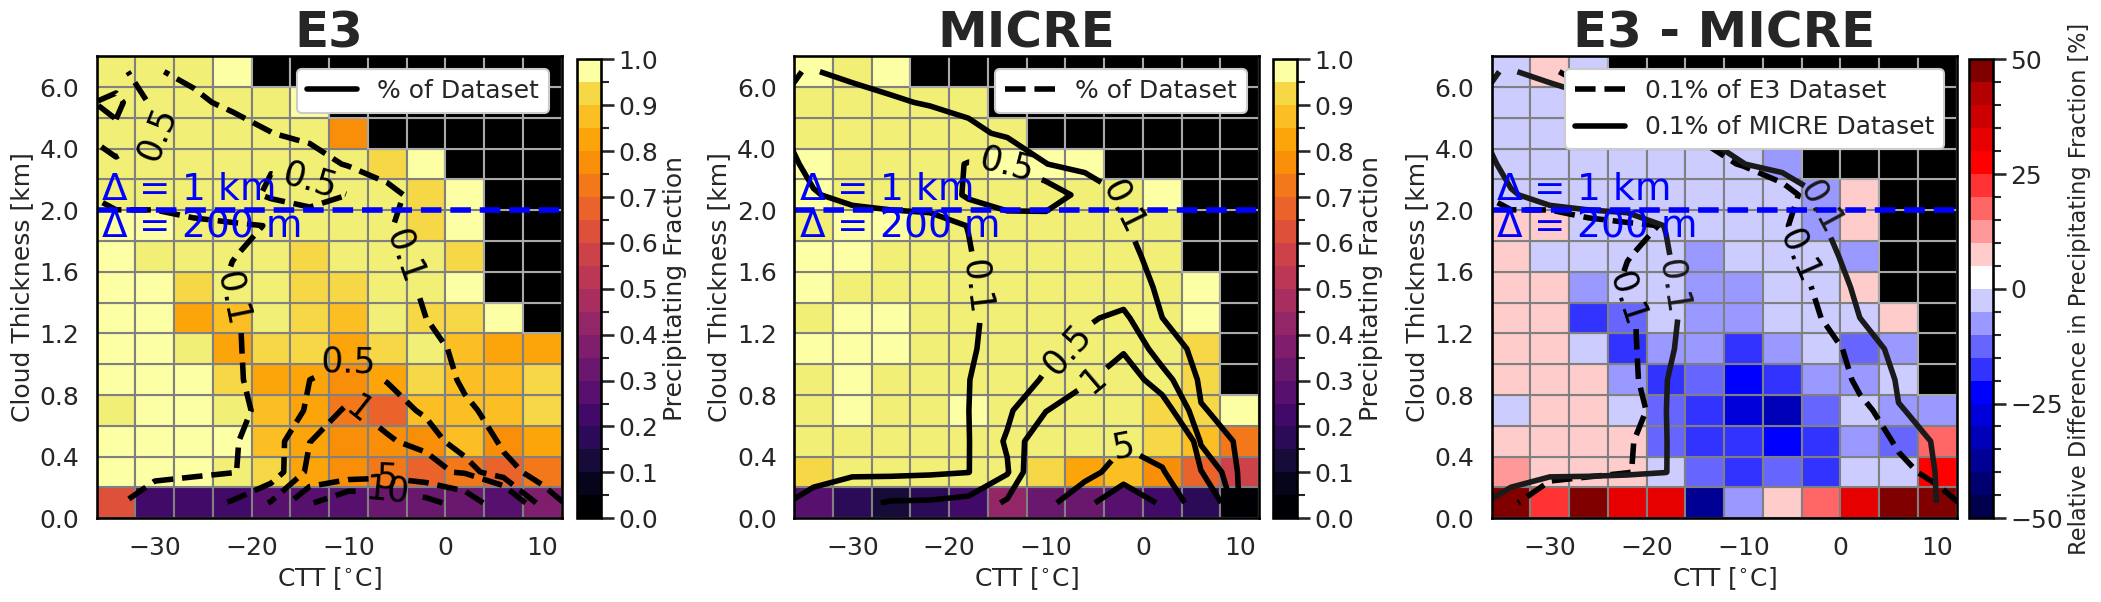

In [13]:
#---------------------------------------------------------
#---------------------------------------------------------
# Precipitating Fraction as a function of CTT and Cloud Thickness
#---------------------------------------------------------
#---------------------------------------------------------
from matplotlib import cm
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D

sns.set_style('ticks')
sns.set(rc={'axes.facecolor':'white','axes.edgecolor': 'black'})
sns.set_context('talk')

def fmt(x):
    s = f"{x:.1f}"
    if s.endswith("0"):
        s = f"{x:.0f}"
    return rf"{s}" if plt.rcParams["text.usetex"] else f"{s}"



fig = plt.figure(figsize=(24,6))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
Fontsize=18
axlist = [ax1,ax2,ax3]
for ax in axlist:
    ax.set_xlabel('CTT [$^{\circ}$C]',fontsize=Fontsize)
    ax.set_ylabel('Cloud Thickness [km]',fontsize=Fontsize)
    ax.tick_params(labelsize=Fontsize)

# Calculate precipitating fraction as a function of cloud depth and CTT
depth_bins = np.arange(0,2000,200)
depth_bins_2 = np.arange(2000,8000,1000)
depth_bins = np.concatenate((depth_bins,depth_bins_2))   
arb_bins = np.arange(0,len(depth_bins),1)

ctt_bins = np.arange(-40,24,4)
ctt_midbins = np.array([(ctt_bins[ii] + ctt_bins[ii+1])/2 for ii in range(len(ctt_bins)-1)])     
arb_midbins = np.array([(arb_bins[ii] + arb_bins[ii+1])/2 for ii in range(len(arb_bins)-1)])     

precip_frac_bins = np.arange(0,1.05,0.05)
ctt_binsize = ctt_bins[1]-ctt_bins[0]
arb_binsize=1.

nipy = cm.get_cmap('inferno',len(precip_frac_bins))
newcolors = nipy(np.linspace(0,1,len(precip_frac_bins)))   
numvec = np.zeros((len(ctt_bins)-1,len(depth_bins)-1))


rel_diff_bins = np.arange(-50,55,5)
seismic = cm.get_cmap('seismic',len(rel_diff_bins))
rel_diff_binsize = rel_diff_bins[1] - rel_diff_bins[0]
rel_diff_newcolors = seismic(np.linspace(0,1,len(rel_diff_bins)-1))
rel_diff_numvec = np.zeros((len(ctt_bins)-1,len(depth_bins)-1))
#----------------------------
#----------------------------
# Joint histogram of CTT and Cloud Depth Precipitating Fraction
#----------------------------
#----------------------------

#----------------------------
# E3
#----------------------------
dum_precip_binary = precip_binary.copy()
dum_ctt = ctt.copy()
dum_c_thick = c_thick.copy()
dum_cbh = cbh.copy()
dum_cb_Ze = e3_dict['cb_Ze'].copy()
dumid = np.where( (dum_precip_binary == 1.) & (dum_cb_Ze < -36.) )
dum_precip_binary[dumid] = 0.

dumid = np.where(dum_cbh > 250.)
dum_ctt = dum_ctt[dumid]
dum_c_thick = dum_c_thick[dumid]
dum_precip_binary = dum_precip_binary[dumid]


for ii in range(len(ctt_bins)-1):
    for jj in range(len(depth_bins)-1):
        tmpid = np.where( (dum_ctt >= ctt_bins[ii]) & (dum_ctt < ctt_bins[ii+1]) & (dum_c_thick >= depth_bins[jj]) & (dum_c_thick < depth_bins[jj+1]) )
        numid = np.size(tmpid)
        dumsize = numid/np.size(dum_precip_binary)*100.
        numvec[ii,jj] = dumsize
        if dumsize > 0.001:
            ctt_lim = dum_ctt[tmpid]
            c_thick_lim = dum_c_thick[tmpid]
            precip_binary_lim = dum_precip_binary[tmpid]
            precip_0 = np.where(precip_binary_lim == 0)
            precip_1 = np.where(precip_binary_lim == 1)

            
            tmp_precip_frac = np.size(precip_binary_lim[precip_1])/np.size(precip_binary_lim)


            col = np.max(np.where(tmp_precip_frac >= precip_frac_bins))
            tmpplot = ax1.add_patch(Rectangle((ctt_bins[ii],arb_bins[jj]),\
                                    ctt_binsize,arb_binsize,\
                                    alpha=1,edgecolor='grey',\
                                    facecolor=newcolors[col]))

        else:
            numvec[ii,jj] = 0
            tmpplot = ax1.add_patch(Rectangle((ctt_bins[ii],arb_bins[jj]),\
                                    ctt_binsize,arb_binsize,\
                                    alpha=1,edgecolor='darkgrey',\
                                   facecolor='black'))       


# Contour counts
cs = ax1.contour(ctt_midbins,arb_midbins,numvec.T,colors='black',\
            linewidths=4,levels=[0.1,0.5,1,5,10,50],linestyles='dashed')

ax1.clabel(cs,cs.levels,inline=True,fmt=fmt,fontsize=25)
ax1.set_xlim(-36,12)   
ax1.set_ylim(0,len(depth_bins)-1) 
ax1.set_yticks(arb_bins[::2])
labels = [str(np.around(depth_bins[::2][dd]*1.e-3,1)) for dd in range(len(depth_bins[::2]))]
ax1.set_yticklabels(labels)


#----------------------------
# MICRE
#----------------------------
dum_precip_binary = micre_precip_binary.copy()
dum_ctt = micre_ctt.copy()
dum_c_thick = micre_c_thick.copy()
dum_ref_mean_bel = micre_ref_mean_bel.copy()
dumid = np.where( (dum_precip_binary == 1.) & (dum_ref_mean_bel < -36.) )
dum_precip_binary[dumid] = 0.



for ii in range(len(ctt_bins)-1):
    for jj in range(len(depth_bins)-1):
        tmpid = np.where( (dum_ctt >= ctt_bins[ii]) & (dum_ctt < ctt_bins[ii+1]) & (dum_c_thick >= depth_bins[jj]) & (dum_c_thick < depth_bins[jj+1]) )
        numid = np.size(tmpid)
        dumsize = numid/np.size(dum_precip_binary)*100.
        numvec[ii,jj] = dumsize
        if dumsize > 0.001:
            ctt_lim = dum_ctt[tmpid]
            c_thick_lim = dum_c_thick[tmpid]
            precip_binary_lim = dum_precip_binary[tmpid]
            precip_0 = np.where(precip_binary_lim == 0)
            precip_1 = np.where(precip_binary_lim == 1)

            
            tmp_precip_frac = np.size(precip_binary_lim[precip_1])/np.size(precip_binary_lim)


            col = np.max(np.where(tmp_precip_frac >= precip_frac_bins))
            tmpplot = ax2.add_patch(Rectangle((ctt_bins[ii],arb_bins[jj]),\
                                    ctt_binsize,arb_binsize,\
                                    alpha=1,edgecolor='grey',\
                                    facecolor=newcolors[col]))

        else:
            numvec[ii,jj] = 0
            tmpplot = ax2.add_patch(Rectangle((ctt_bins[ii],arb_bins[jj]),\
                                    ctt_binsize,arb_binsize,\
                                    alpha=1,edgecolor='darkgrey',\
                                   facecolor='black'))       


# Contour counts
cs = ax2.contour(ctt_midbins,arb_midbins,numvec.T,colors='black',\
            linewidths=4,levels=[0.1,0.5,1,5,10,50],linestyles='solid')

ax2.clabel(cs,cs.levels,inline=True,fmt=fmt,fontsize=25)
ax2.set_xlim(-36,12)   
ax2.set_ylim(0,len(depth_bins)-1) 
ax2.set_yticks(arb_bins[::2])
labels = [str(np.around(depth_bins[::2][dd]*1.e-3,1)) for dd in range(len(depth_bins[::2]))]
ax2.set_yticklabels(labels)


#----------------------------
# Relative Difference
#----------------------------
numvec_micre = np.zeros((len(ctt_bins)-1,len(depth_bins)-1))
numvec_e3 = np.zeros((len(ctt_bins)-1,len(depth_bins)-1))

# E3 
dum_e3_precip_binary = precip_binary.copy()
dum_e3_ctt = ctt.copy()
dum_e3_c_thick = c_thick.copy()
dum_e3_cbh = cbh.copy()
dum_e3_cb_Ze = e3_dict['cb_Ze'].copy()
dumid = np.where( (dum_e3_precip_binary == 1.) & (dum_e3_cb_Ze < -36.) )
dum_e3_precip_binary[dumid] = 0.
dumid = np.where(dum_e3_cbh > 250.)
dum_e3_ctt = dum_e3_ctt[dumid]
dum_e3_c_thick = dum_e3_c_thick[dumid]
dum_e3_precip_binary = dum_e3_precip_binary[dumid]
# MICRE
dum_micre_precip_binary = micre_precip_binary.copy()
dum_micre_ctt = micre_ctt.copy()
dum_micre_c_thick = micre_c_thick.copy()
dum_micre_ref_mean_bel = micre_ref_mean_bel.copy()
dumid = np.where( (dum_micre_precip_binary == 1.) & (dum_micre_ref_mean_bel < -36.) )
dum_micre_precip_binary[dumid] = 0.


for ii in range(len(ctt_bins)-1):
    for jj in range(len(depth_bins)-1):
        
        # E3 
        tmpid_e3 = np.where( (dum_e3_ctt >= ctt_bins[ii]) & (dum_e3_ctt < ctt_bins[ii+1]) & (dum_e3_c_thick >= depth_bins[jj]) & (dum_e3_c_thick < depth_bins[jj+1]) )
        numid_e3 = np.size(tmpid_e3)
        dumsize_e3 = numid_e3/np.size(dum_e3_precip_binary)*100.

        if dumsize_e3 > 0.001:
            numvec_e3[ii,jj] = dumsize_e3
            
            ctt_lim = dum_e3_ctt[tmpid_e3]
            c_thick_lim = dum_e3_c_thick[tmpid_e3]
            precip_binary_lim = dum_e3_precip_binary[tmpid_e3]
            precip_0 = np.where(precip_binary_lim == 0)
            precip_1 = np.where(precip_binary_lim == 1)
            tmp_e3_precip_frac = np.size(precip_binary_lim[precip_1])/np.size(precip_binary_lim)
        else:
            numvec_e3[ii,jj] = 0.
            tmp_e3_precip_frac = np.nan
            
        # MICRE
        tmpid_micre = np.where( (dum_micre_ctt >= ctt_bins[ii]) & (dum_micre_ctt < ctt_bins[ii+1]) & (dum_micre_c_thick >= depth_bins[jj]) & (dum_micre_c_thick < depth_bins[jj+1]) )
        numid_micre = np.size(tmpid_micre)
        dumsize_micre = numid_micre/np.size(dum_micre_precip_binary)*100.

        if dumsize_micre > 0.001:
            numvec_micre[ii,jj] = dumsize_micre
            ctt_lim = dum_micre_ctt[tmpid_micre]
            c_thick_lim = dum_micre_c_thick[tmpid_micre]
            precip_binary_lim = dum_micre_precip_binary[tmpid_micre]
            precip_0 = np.where(precip_binary_lim == 0)
            precip_1 = np.where(precip_binary_lim == 1)
            tmp_micre_precip_frac = np.size(precip_binary_lim[precip_1])/np.size(precip_binary_lim)
        else:
            numvec_micre[ii,jj] = 0.
            tmp_micre_precip_frac = np.nan

        if (~np.isnan(tmp_e3_precip_frac)) & (~np.isnan(tmp_micre_precip_frac)):
            diff = tmp_e3_precip_frac - tmp_micre_precip_frac
            rel_diff = diff/tmp_micre_precip_frac*100.
            if rel_diff > np.max(rel_diff_bins):
                rel_diff = np.max(rel_diff_bins)-0.0001
            if rel_diff < np.min(rel_diff_bins):
                rel_diff = np.min(rel_diff_bins)+0.0001
            col = np.max(np.where(rel_diff >= rel_diff_bins))
            tmpplot = ax3.add_patch(Rectangle((ctt_bins[ii],arb_bins[jj]),\
                                    ctt_binsize,arb_binsize,\
                                    alpha=1,edgecolor='grey',\
                                    facecolor=rel_diff_newcolors[col]))           
            
        else:
            tmpplot = ax3.add_patch(Rectangle((ctt_bins[ii],arb_bins[jj]),\
                                    ctt_binsize,arb_binsize,\
                                    alpha=1,edgecolor='darkgrey',\
                                   facecolor='black'))       

ax3.set_xlim(-36,12)   
ax3.set_ylim(0,len(depth_bins)-1) 
ax3.set_yticks(arb_bins[::2])
labels = [str(np.around(depth_bins[::2][dd]*1.e-3,1)) for dd in range(len(depth_bins[::2]))]
ax3.set_yticklabels(labels)



# Contour counts
cs = ax3.contour(ctt_midbins,arb_midbins,numvec_e3.T,colors='black',\
            linewidths=4,levels=[0.1],linestyles='dashed')
ax3.clabel(cs,cs.levels,inline=True,fmt=fmt,fontsize=25)
cs2 = ax3.contour(ctt_midbins,arb_midbins,numvec_micre.T,colors='k',linestyles='solid',\
            linewidths=4,levels=[0.1])
ax3.clabel(cs2,cs2.levels,inline=True,fmt=fmt,fontsize=25)

custom_lines = [Line2D([0], [0], color='black',lw=4,ls='dashed'),\
                Line2D([0], [0], color='black',lw=4,ls='solid'),\
               ]

ax3.legend(custom_lines, ['0.1% of E3 Dataset','0.1% of MICRE Dataset'],fontsize=Fontsize,loc='upper right',framealpha=1)



custom_lines = [Line2D([0], [0], color='black',lw=4)]
for ax in axlist:
    ax.text(0.01,0.61,'$\\Delta$ = 200 m',fontsize=Fontsize*1.5,transform=ax.transAxes,color='blue')
    ax.text(0.01,0.69,'$\\Delta$ = 1 km',fontsize=Fontsize*1.5,transform=ax.transAxes,color='blue')
    ax.axhline(10,linewidth=4,c='blue',ls='dashed')
custom_lines = [Line2D([0], [0], color='black',lw=4,ls='solid')]
ax1.legend(custom_lines, ['% of Dataset'],fontsize=Fontsize,loc='upper right',framealpha=1)
custom_lines = [Line2D([0], [0], color='black',lw=4,ls='dashed')]
ax2.legend(custom_lines, ['% of Dataset'],fontsize=Fontsize,loc='upper right',framealpha=1)
    
# Colorbar 1
bounds = precip_frac_bins
norm = matplotlib.colors.BoundaryNorm(bounds,nipy.N)
ax99 = fig.add_axes([0.325,0.11,0.01,0.765])
cb = matplotlib.colorbar.ColorbarBase(ax99,cmap=nipy,norm=norm,\
                                      spacing='uniform',\
                                      ticks=bounds,\
                                      boundaries=bounds,
                                      orientation='vertical')
cb.set_ticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.])
ax99.tick_params(labelsize=Fontsize)
ax99.set_ylabel('Precipitating Fraction',fontsize=Fontsize)

# Colorbar 2
bounds = precip_frac_bins
norm = matplotlib.colors.BoundaryNorm(bounds,nipy.N)
ax98 = fig.add_axes([0.615,0.11,0.01,0.765])
cb = matplotlib.colorbar.ColorbarBase(ax98,cmap=nipy,norm=norm,\
                                      spacing='uniform',\
                                      ticks=bounds,\
                                      boundaries=bounds,
                                      orientation='vertical')
cb.set_ticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.])
ax98.tick_params(labelsize=Fontsize)
ax98.set_ylabel('Precipitating Fraction',fontsize=Fontsize)

# Colorbar 3
bounds = rel_diff_bins
norm = matplotlib.colors.BoundaryNorm(bounds,seismic.N)
ax97 = fig.add_axes([0.905,0.11,0.01,0.765])
cb = matplotlib.colorbar.ColorbarBase(ax97,cmap=seismic,norm=norm,\
                                      spacing='uniform',\
                                      ticks=bounds,\
                                      boundaries=bounds,
                                      orientation='vertical')
cb.set_ticks([-50,-25,0,25,50])
ax97.tick_params(labelsize=Fontsize)
ax97.set_ylabel('Relative Difference in Precipitating Fraction [%]',fontsize=Fontsize*0.9)

ax1.set_title('E3',fontsize=Fontsize*2,fontweight='bold')
ax2.set_title('MICRE',fontsize=Fontsize*2,fontweight='bold')
ax3.set_title('E3 - MICRE',fontsize=Fontsize*2,fontweight='bold')

plt.subplots_adjust(wspace=0.5)
plt.show()
plt.close()       

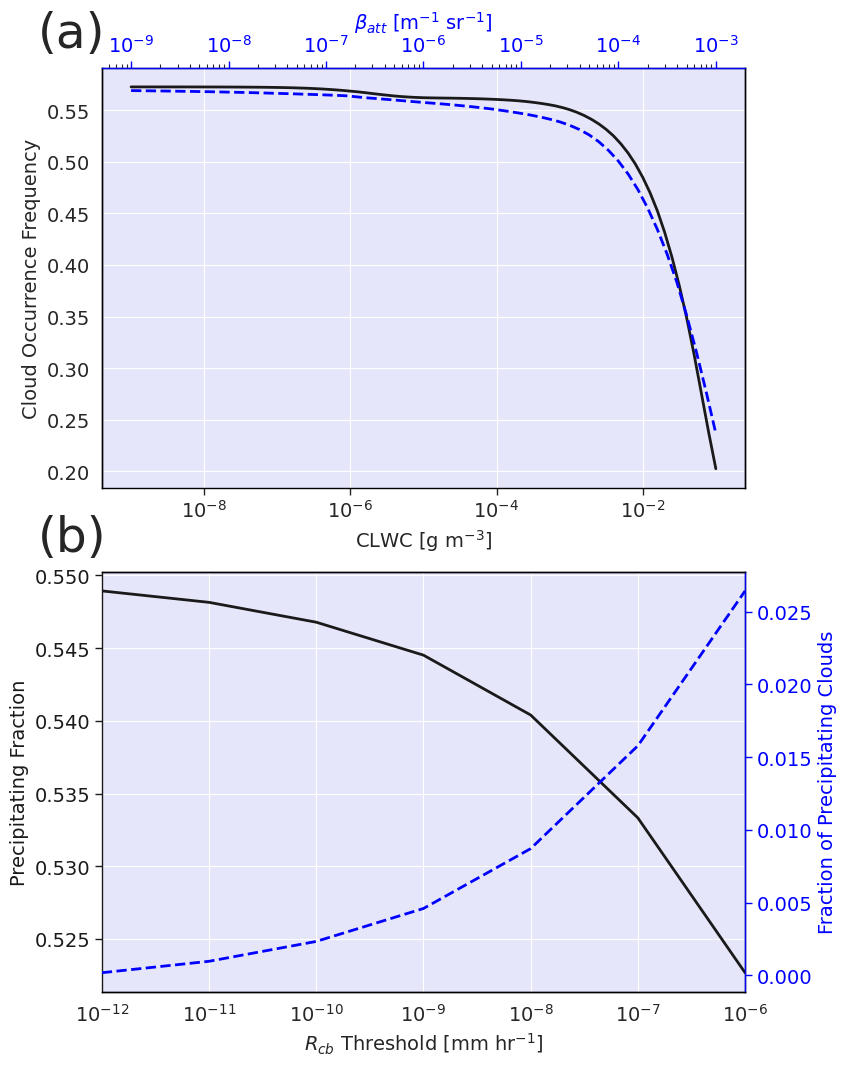

done


In [11]:
#=========================================
# E3 Cloud and Precipitation Sensitivities
#=========================================
sns.set_theme()
sns.set_style('ticks')
sns.set(rc={'axes.facecolor':'lavender','axes.edgecolor': 'black'})
sns.set_context('paper')
fig = plt.figure(figsize=(8.3,12))
ax1 = fig.add_subplot(211)
ax3 = fig.add_subplot(212)
Fontsize=14


#---------------------------------------------
#---------------------------------------------
# Cloud Occurrence Frequency
#---------------------------------------------
#---------------------------------------------
ax1.tick_params(labelsize=Fontsize)
ax1.set_ylabel('Cloud Occurrence Frequency',fontsize=Fontsize)
#---------------------------------------------
# CLWC Threshes
#---------------------------------------------
ax1.set_xlabel('CLWC [g m$^{-3}$]',fontsize=Fontsize)
clwc_threshes = np.arange(-9,-0.9,0.1)
cloud_fraction = np.zeros(len(clwc_threshes))
tot_size = np.size(e3_dict['tot_time'])
dumi=0
for clwc_thresh in clwc_threshes:
    cloud_id = np.where(e3_dict['cbh'] > 0.)
    dumid = np.where((e3_dict['cb_clwc'][cloud_id]*1.e3 > 10.**(clwc_thresh)) )
    if np.size(dumid) > 0.:
        cloud_fraction[dumi] = np.size(dumid)/tot_size
            
    dumi+=1
x = clwc_threshes
y = cloud_fraction
ax1.set_xscale('log')
ax1.plot(10.**x,y,lw=2,c='k')
#---------------------------------------------
# Beta_att thresh
#---------------------------------------------
ax2 = ax1.twiny()
ax2.set_xlabel('$\\beta_{att}$ [m$^{-1}$ sr$^{-1}$]',fontsize=Fontsize,c='blue')
ax2.grid(False)
# deal with axis colors
ax2.spines['top'].set_color('blue')
ax2.xaxis.label.set_color('blue')
ax2.tick_params(axis='x', colors='blue',labelsize=Fontsize)
ax2.spines['bottom'].set_visible(False)

beta_att_threshes = np.arange(-9,-2.9,0.1)
cloud_fraction = np.zeros(len(beta_att_threshes))
tot_size = np.size(e3_dict['tot_time'])
dumi=0
for beta_att_thresh in beta_att_threshes:
    cloud_id = np.where(e3_dict['cbh'] > 0.)
    dumid = np.where((e3_dict['cb_beta_att'][cloud_id] > 10.**(beta_att_thresh)) )
    if np.size(dumid) > 0.:
        cloud_fraction[dumi] = np.size(dumid)/tot_size
            
    dumi+=1
    
x = beta_att_threshes
y = cloud_fraction
ax2.set_xscale('log')
ax2.plot(10.**x,y,lw=2,c='blue',ls='dashed')


#-----------------------------------------
# Precipitation Occurrence Frequency
#-----------------------------------------
thresh_arr = np.arange(-12,-5)
thresh_arr = 10.**thresh_arr
frac_of_dataset = []
precip_fracx = []
for ii in range(len(thresh_arr)):
    dum_precip_binary = e3_dict['precip_binary'].copy()
    dum_rcb = e3_dict['rcb'].copy()
    dum_cbh = e3_dict['cbh'].copy()
    
    dumid = np.where( (dum_cbh > 250.) & (~np.isnan(dum_precip_binary)))
    dum_precip_binary = dum_precip_binary[dumid]
    dum_rcb = dum_rcb[dumid]
    dum_cbh = dum_cbh[dumid]

    dumid = np.where( (dum_rcb < thresh_arr[ii]) & (dum_precip_binary == 1.))
    dum_precip_binary[dumid] = 0.
    
    precip_id = np.where(dum_precip_binary == 1.)
    tmp_precip_frac = np.size(precip_id)/np.size(dum_precip_binary)
    precip_fracx.append(tmp_precip_frac)    

    tmp_frac_of_dataset = np.size(dumid)/np.size(dum_precip_binary)
    frac_of_dataset.append(tmp_frac_of_dataset)
    #frac_of_dataset.append(np.size(dumid)/np.size(dum_precip_binary[dum_precip_binary == 1.]))
    
precip_fracx = np.array(precip_fracx)
frac_of_dataset = np.array(frac_of_dataset)

ax3a = ax3.twinx()
ax3.tick_params(labelsize=Fontsize,color='k')
ax3a.tick_params(labelsize=Fontsize,color='blue')
ax3a.spines['right'].set_color('blue')
ax3.spines['left'].set_color('k')
ax3a.spines['left'].set_visible(False)
ax3a.tick_params(axis='y', which='both',colors='blue')
ax3.tick_params(axis='y', which='both',colors='k')

ax3.set_ylabel('Precipitating Fraction',fontsize=Fontsize,c='k')
ax3a.set_ylabel('Fraction of Precipitating Clouds',fontsize=Fontsize,c='blue')
ax3.set_xlabel('$R_{cb}$ Threshold [mm hr$^{-1}$]',fontsize=Fontsize)
ax3.set_xscale('log')
ax3.set_xlim(np.min(thresh_arr),np.max(thresh_arr))
ax3.plot(thresh_arr,precip_fracx,lw=2,c='k')
ax3a.plot(thresh_arr,frac_of_dataset,lw=2,c='blue',ls='dashed')
ax3a.grid(False)

ax1.text(-0.1,1.05,'(a)',fontsize=Fontsize*2.5,transform=ax1.transAxes)
ax3.text(-0.1,1.05,'(b)',fontsize=Fontsize*2.5,transform=ax3.transAxes)

fig_path = '/home/mwstanfo/figures/micre_paper/'
outfile = 'fig_g1.png'
#outfile = 'fig_g1.eps'
plt.show()
#plt.savefig(fig_path+outfile,dpi=200,bbox_inches='tight')
plt.close()
print('done')

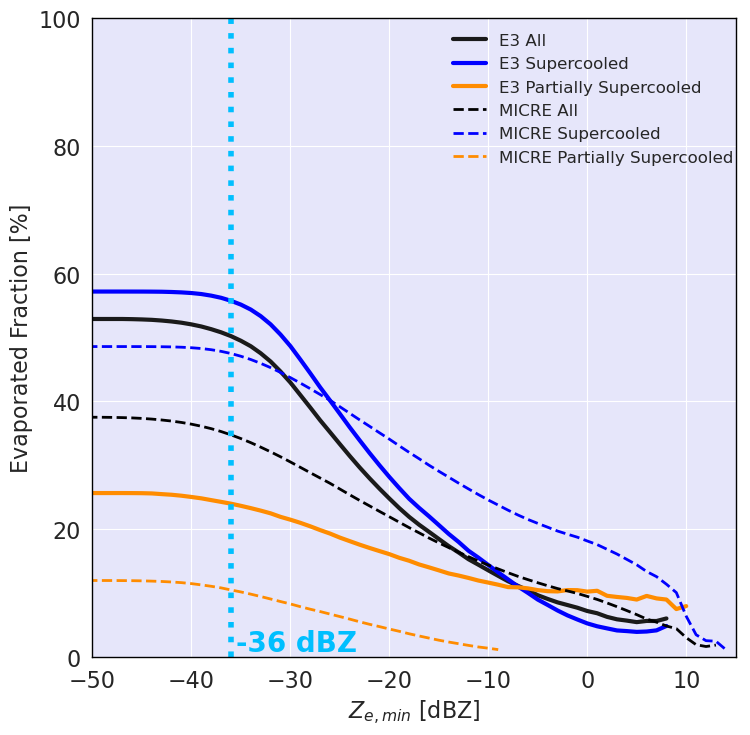

done


In [204]:
#=====================================
# Plot Evaporated Fraction as a function
# of minimum Ze
#=====================================
sns.set_theme()
sns.set_style('ticks')
sns.set(rc={'axes.facecolor':'lavender','axes.edgecolor': 'black'})
sns.set_context('paper')
fig = plt.figure(figsize=(8.3,8.3))
ax1 = fig.add_subplot(111)
Fontsize=16
ax1.tick_params(labelsize=Fontsize)
ax1.set_ylabel('Evaporated Fraction [%]',fontsize=Fontsize)
ax1.set_xlabel('$Z_{e,min}$ [dBZ]',fontsize=Fontsize)


# E3

ax1.plot(Ze_min,evap_frac*100.,lw=3,c='k',label='E3 All')
ax1.plot(Ze_min,evap_frac_supercooled*100.,lw=3,c='blue',label='E3 Supercooled')
ax1.plot(Ze_min,evap_frac_partially_supercooled*100.,lw=3,c='darkorange',label='E3 Partially Supercooled')
#ax1.plot(Ze_min,evap_frac_warm*100.,lw=3,c='red',label='E3 Warm')


# MICRE
ax1.plot(Ze_min,micre_evap_frac*100.,lw=2,c='black',ls='dashed',label='MICRE All')
ax1.plot(Ze_min,micre_evap_frac_supercooled*100.,lw=2,c='blue',ls='dashed',label='MICRE Supercooled')
ax1.plot(Ze_min,micre_evap_frac_partially_supercooled*100.,lw=2,c='darkorange',ls='dashed',label='MICRE Partially Supercooled')
#ax1.plot(Ze_min,micre_evap_frac_warm*100.,lw=2,c='red',ls='dashed',label='MICRE Warm')

ax1.set_ylim(0,100)
ax1.set_xlim(-50,15)

ax1.legend(loc='upper right',bbox_to_anchor=(1.02,1),framealpha=False,fontsize=Fontsize*0.75,ncol=1)
ax1.axvline(-36.,lw=4,c='deepskyblue',ls='dotted')
ax1.text(-35.5,0,'-36 dBZ',fontweight='bold',fontsize=Fontsize*1.25,ha='left',va='bottom',c='deepskyblue')

fig_path = '/home/mwstanfo/figures/micre_paper/'
outfile = 'fig_g2.png'
#outfile = 'fig_g2.eps'
plt.show()
#plt.savefig(fig_path+outfile,dpi=200,bbox_inches='tight')
plt.close()
print('done')

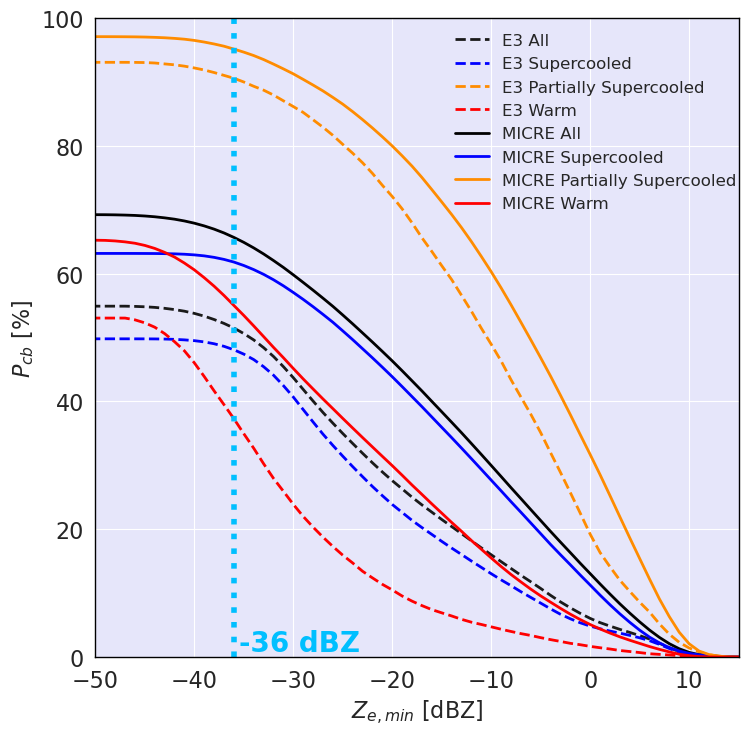

done


In [14]:
#=====================================
# Plot Pcb as a function
# of minimum Ze
#=====================================
sns.set_theme()
sns.set_style('ticks')
sns.set(rc={'axes.facecolor':'lavender','axes.edgecolor': 'black'})
sns.set_context('paper')
fig = plt.figure(figsize=(8.3,8.3))
ax1 = fig.add_subplot(111)
Fontsize=16
ax1.tick_params(labelsize=Fontsize)
ax1.set_ylabel('$P_{cb}$ [%]',fontsize=Fontsize)
ax1.set_xlabel('$Z_{e,min}$ [dBZ]',fontsize=Fontsize)

ax1.plot(Ze_min,pcb*100.,lw=2,c='k',label='E3 All',ls='dashed')
ax1.plot(Ze_min,pcb_supercooled*100.,lw=2,c='blue',label='E3 Supercooled',ls='dashed')
ax1.plot(Ze_min,pcb_partially_supercooled*100.,lw=2,c='darkorange',label='E3 Partially Supercooled',ls='dashed')
ax1.plot(Ze_min,pcb_warm*100.,lw=2,c='red',label='E3 Warm',ls='dashed')


# MICRE
ax1.plot(Ze_min,micre_pcb*100.,lw=2,c='black',ls='solid',label='MICRE All')
ax1.plot(Ze_min,micre_pcb_supercooled*100.,lw=2,c='blue',ls='solid',label='MICRE Supercooled')
ax1.plot(Ze_min,micre_pcb_partially_supercooled*100.,lw=2,c='darkorange',ls='solid',label='MICRE Partially Supercooled')
ax1.plot(Ze_min,micre_pcb_warm*100.,lw=2,c='red',ls='solid',label='MICRE Warm')


ax1.set_ylim(0,100)
ax1.set_xlim(-50,15)

ax1.legend(loc='upper right',bbox_to_anchor=(1.02,1),framealpha=False,fontsize=Fontsize*0.75,ncol=1)
ax1.axvline(-36.,lw=4,c='deepskyblue',ls='dotted')
ax1.text(-35.5,0,'-36 dBZ',fontweight='bold',fontsize=Fontsize*1.25,ha='left',va='bottom',c='deepskyblue')

fig_path = '/home/mwstanfo/figures/micre_paper/'
outfile = 'fig_11.png'
#outfile = 'fig_11.eps'
plt.show()
#plt.savefig(fig_path+outfile,dpi=200,bbox_inches='tight')
plt.close()
print('done')

In [133]:
def filter_data(precip_binary,cbt,ctt,in_var,filter_type):
    dumid = np.where(in_var > -999.)
    in_var = in_var[dumid]
    cbt = cbt[dumid]
    ctt = ctt[dumid]
    precip_binary = precip_binary[dumid]
    
    dumid = np.where(ctt > -999.)
    in_var = in_var[dumid]
    cbt = cbt[dumid]
    ctt = ctt[dumid]
    precip_binary = precip_binary[dumid]
    
    dumid = np.where(cbt > -999.)
    in_var = in_var[dumid]
    cbt = cbt[dumid]
    ctt = ctt[dumid]
    precip_binary = precip_binary[dumid]
    
    if filter_type == 'supercooled':
        precip_0 = np.where((precip_binary == 0.) & (cbt < 0.) & (ctt < 0.))
        precip_1 = np.where((precip_binary == 1.) & (cbt < 0.) & (ctt < 0.))
        all_id = np.where((precip_binary > -999.) & (cbt < 0.) & (ctt < 0.))
        #all_id = np.where((cbt < 0.) & (ctt < 0.))
    elif filter_type == 'partially_supercooled':
        precip_0 = np.where((precip_binary == 0.) & (cbt >= 0.) & (ctt < 0.))
        precip_1 = np.where((precip_binary == 1.) & (cbt >= 0.) & (ctt < 0.))
        all_id = np.where((precip_binary > -999.) & (cbt >= 0.) & (ctt < 0.))
        #all_id = np.where((cbt >= 0.) & (ctt < 0.))
    elif filter_type == 'warm':
        precip_0 = np.where((precip_binary == 0.) & (cbt >= 0.) & (ctt >= 0.))
        precip_1 = np.where((precip_binary == 1.) & (cbt >= 0.) & (ctt >= 0.))
        all_id = np.where((precip_binary > -999.) & (cbt >= 0.) & (ctt >= 0.))
        #all_id = np.where((cbt >= 0.) & (ctt >= 0.))
    elif filter_type == 'all':
        precip_0 = np.where((precip_binary == 0.))
        precip_1 = np.where((precip_binary == 1.))
        all_id = np.where((precip_binary > -999.))
        #all_id = np.where((precip_binary == 0. ) | (precip_binary == 1.) | (np.isnan(precip_binary)))
    else:
        raise RuntimeError('Do better.')
        
    var_precip = in_var[precip_1]
    var_nonprecip = in_var[precip_0]
    var_all = in_var[all_id]
    return var_precip, var_nonprecip, var_all

In [134]:
#--------------------------------------------
# Occurrence Frequency
#--------------------------------------------
def occur_freq(data,bins,full_length):
    tmp_hist = []
    for ii in range(len(bins)-1):
        if ii != (len(bins)-2):
            tmpid = np.where((data >= bins[ii]) & (data < bins[ii+1]))
            tmp_hist.append(np.size(tmpid)/full_length)
        elif ii == (len(bins)-2):
            tmpid = np.where((data >= bins[ii]) & (data <= bins[ii+1]))
            tmp_hist.append(np.size(tmpid)/full_length)            
    tmp_hist = np.array(tmp_hist)
    return tmp_hist,bins

In [135]:
#--------------------------------------------
# Function to calculate precipitating fraction
#--------------------------------------------
def precip_frac(data1,data2,bins):
    #data1 = data1[~np.isnan(data1)]
    data1 = data1[data1 > -999.]
    #data2 = data2[~np.isnan(data2)]
    data2 = data2[data2 > -999.]
    thresh_frac = 0.005
    pf = []
    for ii in range(len(bins)-1):
        if ii != (len(bins)-2):
            tmpid1 = np.where((data1 >= bins[ii]) & (data1 < bins[ii+1]))
            tmpid2 = np.where((data2 >= bins[ii]) & (data2 < bins[ii+1]))
            if (np.size(tmpid2)/np.size(data2)) < thresh_frac:
                pf.append(np.nan)
            else:
                pf.append(np.size(tmpid1)/np.size(tmpid2))
        elif ii == (len(bins)-2):
            tmpid1 = np.where((data1 >= bins[ii]) & (data1 <= bins[ii+1]))
            tmpid2 = np.where((data2 >= bins[ii]) & (data2 <= bins[ii+1]))
            if (np.size(tmpid2)/np.size(data2)) < thresh_frac:
                pf.append(np.nan)
            else:
                pf.append(np.size(tmpid1)/np.size(tmpid2))
    pf = np.array(pf)
    return pf

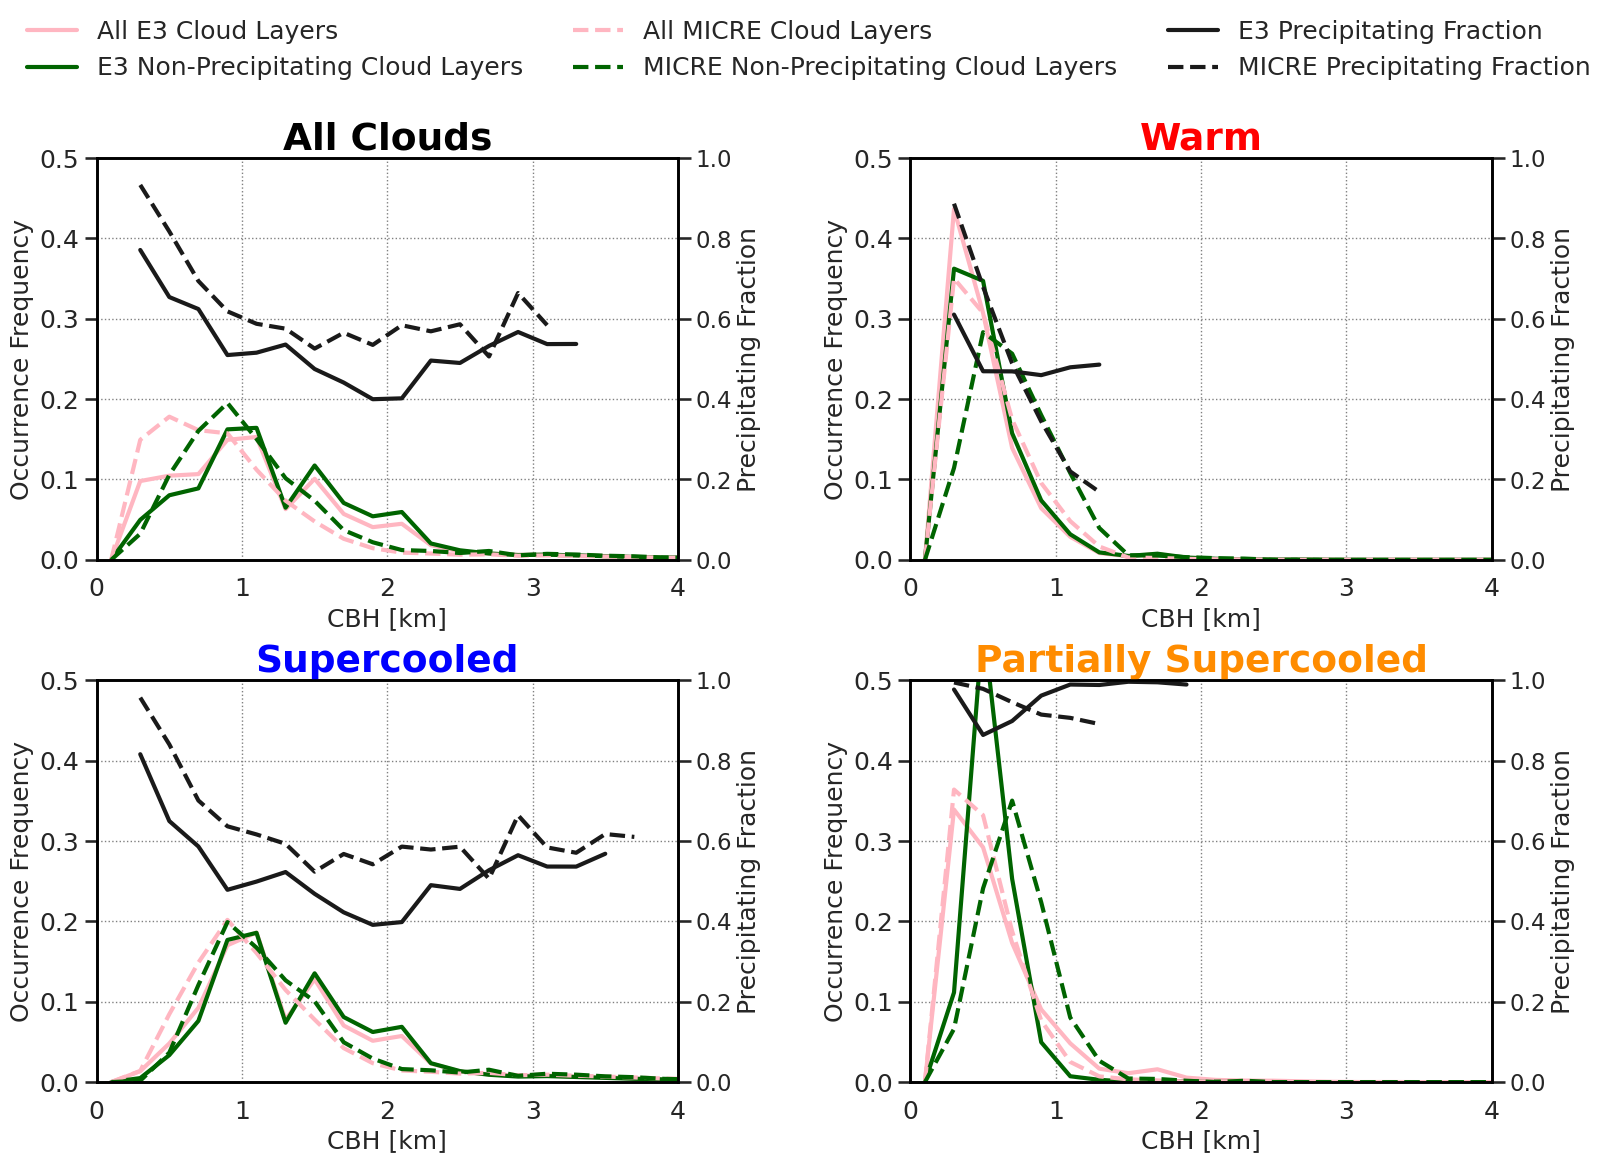

In [145]:
#----------------------------------------------------
#----------------------------------------------------
# Histograms of CBH
#----------------------------------------------------
#----------------------------------------------------

sns.set_style('ticks')
sns.set(rc={'axes.facecolor':'white','axes.edgecolor': 'black'})
sns.set_context('talk')
Fontsize=18
fig = plt.figure(figsize=(18,12))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)


    
filter_type_list = ['all','warm','supercooled','partially_supercooled']
label_list  = ['All Clouds','Warm','Supercooled','Partially Supercooled']
colors_list = ['black','red','blue','darkorange']

axlist = [ax1,ax2,ax3,ax4]

ii=0
for ax in axlist:
    ax.tick_params(labelsize=Fontsize)
    ax.set_xlabel('CBH [km]',fontsize=Fontsize)
    ax.grid(which='both',c='grey',ls='dotted',lw=1)
    ax.set_ylabel('Occurrence Frequency',fontsize=Fontsize)
    ax.set_title(label_list[ii],c=colors_list[ii],fontsize=Fontsize*1.5,fontweight='bold')
    ax.set_ylim(0,0.5)
    ii+=1

cbh_bins = np.arange(0,8200,200)
cbh_midbins = np.array([(cbh_bins[ii] + cbh_bins[ii+1])/2 for ii in range(len(cbh_bins)-1)])
dum_cbh_bins = np.arange(0,len(cbh_bins))
dum_cbh_midbins = np.array([(dum_cbh_bins[ii] + dum_cbh_bins[ii+1])/2 for ii in range(len(dum_cbh_bins)-1)])    
    


pink_color = 'lightpink'
pink_edgecolor = 'black'
pink_alpha = 1
green_color = 'darkgreen'
green_edgecolor = 'black'
green_alpha = 0.6


dumthick=0.8
#---------------------------
# Loop through fitlerings
#---------------------------

ii = 0
for ax in axlist:
    filter_type = filter_type_list[ii]
    ax = axlist[ii]
    axa = ax.twinx()
    axa.grid(visible=None)
    axa.set_ylim(0,1)
    axa.set_ylabel('Precipitating Fraction',fontsize=Fontsize)
    
    
    # E3
    dumid = np.where(cbh > 250.)
    var_precip, var_nonprecip, var_all = filter_data(precip_binary[dumid],cbt[dumid],ctt[dumid],cbh[dumid],filter_type)       
    # All clouds
    samp_size_all = np.size(var_all)
    occur_freq_all,dumbins = occur_freq(var_all,cbh_bins,samp_size_all)
    ax.plot(cbh_midbins*1.e-3,occur_freq_all,c=pink_color,ls='solid',lw=3)
    # Non-precipitating clouds
    samp_size_nonprecip = np.size(var_nonprecip)
    occur_freq_nonprecip,dumbins = occur_freq(var_nonprecip,cbh_bins,samp_size_nonprecip)
    ax.plot(cbh_midbins*1.e-3,occur_freq_nonprecip,c=green_color,ls='solid',lw=3)
    # Precipitating clouds
    #samp_size_precip = np.size(var_precip)
    #occur_freq_precip,dumbins = occur_freq(var_precip,cbh_bins,samp_size_precip)
    #ax.plot(cbh_midbins*1.e-3,occur_freq_precip,c=green_color,ls='solid',lw=3)    
    # Precipitating Fraction
    pf = precip_frac(var_precip,var_all,cbh_bins)
    pf[pf == 0.] = np.nan
    axa.plot(cbh_midbins*1.e-3,pf,lw=3,c='k',ls='solid')
    
    # MICRE
    var_precip, var_nonprecip, var_all = filter_data(micre_precip_binary,micre_cbt,micre_ctt,micre_cbh,filter_type)       
    # All clouds
    samp_size_all = np.size(var_all)
    occur_freq_all,dumbins = occur_freq(var_all,cbh_bins,samp_size_all)
    ax.plot(cbh_midbins*1.e-3,occur_freq_all,c=pink_color,ls='dashed',lw=3)
    # Non-precipitating clouds
    samp_size_nonprecip = np.size(var_nonprecip)
    occur_freq_nonprecip,dumbins = occur_freq(var_nonprecip,cbh_bins,samp_size_nonprecip)
    ax.plot(cbh_midbins*1.e-3,occur_freq_nonprecip,c=green_color,ls='dashed',lw=3)
    # Precipitating clouds
    #samp_size_precip = np.size(var_precip)
    #occur_freq_precip,dumbins = occur_freq(var_precip,cbh_bins,samp_size_precip)
    #ax.plot(cbh_midbins*1.e-3,occur_freq_precip,c=green_color,ls='dashed',lw=3)
    # Precipitating Fraction
    pf = precip_frac(var_precip,var_all,cbh_bins)
    pf[pf == 0.] = np.nan
    axa.plot(cbh_midbins*1.e-3,pf,lw=3,c='k',ls='dashed')   
    
    ax.set_xlim(0,4)
    #ax.set_xscale('log')
    #x.set_xlim(0.025,4)
    
    ii+=1
legend_elements = [Line2D([0], [0], label='All E3 Cloud Layers',lw=3,c=pink_color,ls='solid'),\
                   Line2D([0], [0], label='E3 Non-Precipitating Cloud Layers',lw=3,c=green_color,ls='solid'),\
                   Line2D([0], [0], label='All MICRE Cloud Layers',lw=3,c=pink_color,ls='dashed'),\
                   Line2D([0], [0], label='MICRE Non-Precipitating Cloud Layers',lw=3,c=green_color,ls='dashed'),\
                   Line2D([0], [0], label='E3 Precipitating Fraction',lw=3,c='k',ls='solid'),\
                   Line2D([0], [0], label='MICRE Precipitating Fraction',lw=3,c='k',ls='dashed'),\
                  ]

lgnd = ax1.legend(handles=legend_elements,fontsize=Fontsize,loc='upper center',framealpha=0,bbox_to_anchor=(1.225,1.4),ncol=3)

plt.subplots_adjust(hspace=0.3,wspace=0.4)
plt.show()
plt.close()

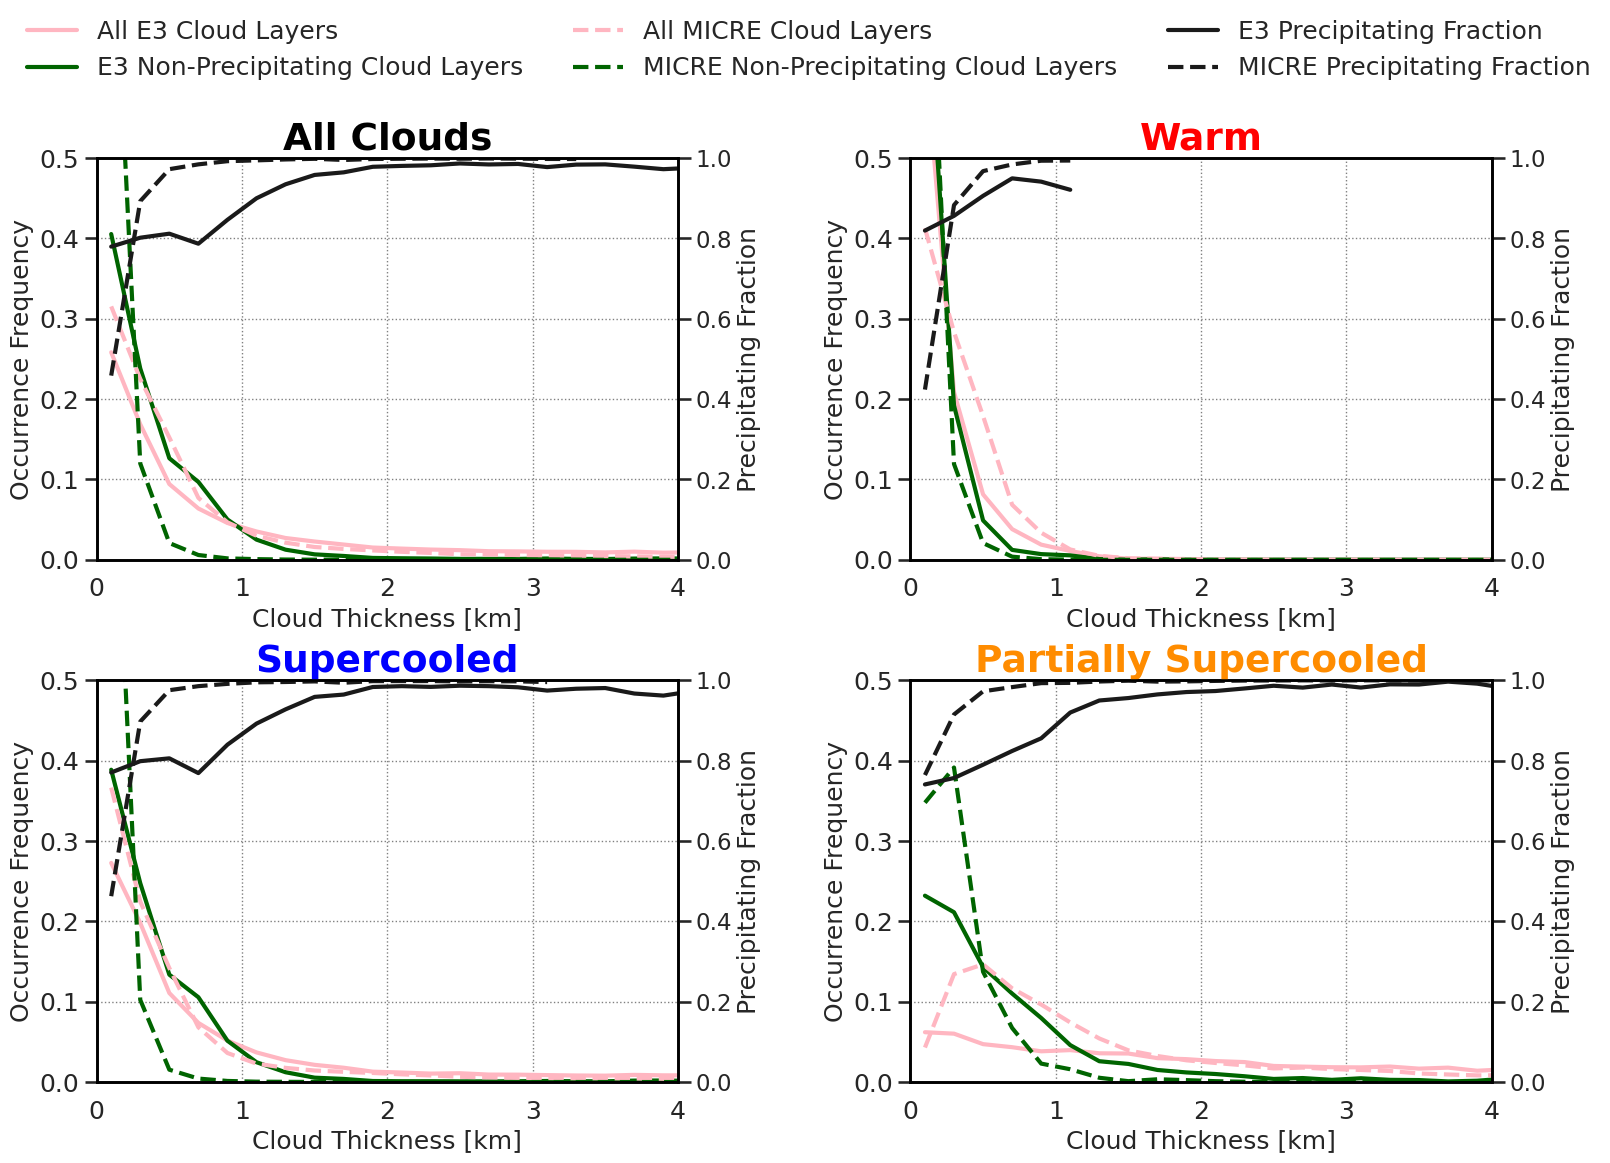

In [ ]:
#----------------------------------------------------
#----------------------------------------------------
# Histograms of Cloud Thickness
#----------------------------------------------------
#----------------------------------------------------

sns.set_style('ticks')
sns.set(rc={'axes.facecolor':'white','axes.edgecolor': 'black'})
sns.set_context('talk')
Fontsize=18
fig = plt.figure(figsize=(18,12))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)


    
filter_type_list = ['all','warm','supercooled','partially_supercooled']
label_list  = ['All Clouds','Warm','Supercooled','Partially Supercooled']
colors_list = ['black','red','blue','darkorange']

axlist = [ax1,ax2,ax3,ax4]

ii=0
for ax in axlist:
    ax.tick_params(labelsize=Fontsize)
    ax.set_xlabel('Cloud Thickness [km]',fontsize=Fontsize)
    ax.grid(which='both',c='grey',ls='dotted',lw=1)
    ax.set_ylabel('Occurrence Frequency',fontsize=Fontsize)
    ax.set_title(label_list[ii],c=colors_list[ii],fontsize=Fontsize*1.5,fontweight='bold')
    ax.set_ylim(0,0.5)
    ii+=1

depth_bins = np.arange(0,8200,200)
depth_midbins = np.array([(depth_bins[ii] + depth_bins[ii+1])/2 for ii in range(len(depth_bins)-1)])
dum_depth_bins = np.arange(0,len(depth_bins))
dum_depth_midbins = np.array([(dum_depth_bins[ii] + dum_depth_bins[ii+1])/2 for ii in range(len(dum_depth_bins)-1)])    
    


pink_color = 'lightpink'
pink_edgecolor = 'black'
pink_alpha = 1
green_color = 'darkgreen'
green_edgecolor = 'black'
green_alpha = 0.6


dumthick=0.8
#---------------------------
# Loop through fitlerings
#---------------------------

ii = 0
for ax in axlist:
    filter_type = filter_type_list[ii]
    ax = axlist[ii]
    dumid = np.where((c_thick > 0.) & (cbh > 250.))
    axa = ax.twinx()
    axa.grid(visible=None)
    axa.set_ylim(0,1)
    axa.set_ylabel('Precipitating Fraction',fontsize=Fontsize)
    
    
    # E3
    var_precip, var_nonprecip, var_all = filter_data(precip_binary[dumid],cbt[dumid],ctt[dumid],c_thick[dumid],filter_type)       
    # All clouds
    samp_size_all = np.size(var_all)
    occur_freq_all,dumbins = occur_freq(var_all,depth_bins,samp_size_all)
    ax.plot(depth_midbins*1.e-3,occur_freq_all,c=pink_color,ls='solid',lw=3)
    # Non-precipitating clouds
    samp_size_nonprecip = np.size(var_nonprecip)
    occur_freq_nonprecip,dumbins = occur_freq(var_nonprecip,depth_bins,samp_size_nonprecip)
    ax.plot(depth_midbins*1.e-3,occur_freq_nonprecip,c=green_color,ls='solid',lw=3)
    # Precipitating clouds
    #samp_size_precip = np.size(var_precip)
    #occur_freq_precip,dumbins = occur_freq(var_precip,depth_bins,samp_size_precip)
    #ax.plot(depth_midbins*1.e-3,occur_freq_precip,c=pink_color,ls='solid',lw=3)    
    # Precipitating Fraction
    pf = precip_frac(var_precip,var_all,depth_bins)
    pf[pf == 0.] = np.nan
    axa.plot(depth_midbins*1.e-3,pf,lw=3,c='k',ls='solid')
    
    # MICRE
    dumid = np.where(micre_c_thick > 0.)
    var_precip, var_nonprecip, var_all = filter_data(micre_precip_binary[dumid],micre_cbt[dumid],micre_ctt[dumid],micre_c_thick[dumid],filter_type)       
    # All clouds
    samp_size_all = np.size(var_all)
    occur_freq_all,dumbins = occur_freq(var_all,depth_bins,samp_size_all)
    ax.plot(depth_midbins*1.e-3,occur_freq_all,c=pink_color,ls='dashed',lw=3)
    # Non-precipitating clouds
    samp_size_nonprecip = np.size(var_nonprecip)
    occur_freq_nonprecip,dumbins = occur_freq(var_nonprecip,depth_bins,samp_size_nonprecip)
    ax.plot(depth_midbins*1.e-3,occur_freq_nonprecip,c=green_color,ls='dashed',lw=3)
    # Precipitating clouds
    #samp_size_precip = np.size(var_precip)
    #occur_freq_precip,dumbins = occur_freq(var_precip,depth_bins,samp_size_precip)
    #ax.plot(depth_midbins*1.e-3,occur_freq_precip,c=pink_color,ls='dashed',lw=3)
    # Precipitating Fraction
    pf = precip_frac(var_precip,var_all,depth_bins)
    pf[pf == 0.] = np.nan
    axa.plot(depth_midbins*1.e-3,pf,lw=3,c='k',ls='dashed')   
    

    ax.set_xlim(0,4)
    #ax.set_xscale('log')
    
    
    ii+=1
legend_elements = [Line2D([0], [0], label='All E3 Cloud Layers',lw=3,c=pink_color,ls='solid'),\
                   Line2D([0], [0], label='E3 Non-Precipitating Cloud Layers',lw=3,c=green_color,ls='solid'),\
                   Line2D([0], [0], label='All MICRE Cloud Layers',lw=3,c=pink_color,ls='dashed'),\
                   Line2D([0], [0], label='MICRE Non-Precipitating Cloud Layers',lw=3,c=green_color,ls='dashed'),\
                   Line2D([0], [0], label='E3 Precipitating Fraction',lw=3,c='k',ls='solid'),\
                   Line2D([0], [0], label='MICRE Precipitating Fraction',lw=3,c='k',ls='dashed'),\
                  ]

lgnd = ax1.legend(handles=legend_elements,fontsize=Fontsize,loc='upper center',framealpha=0,bbox_to_anchor=(1.225,1.4),ncol=3)

plt.subplots_adjust(hspace=0.3,wspace=0.4)
plt.show()
plt.close()

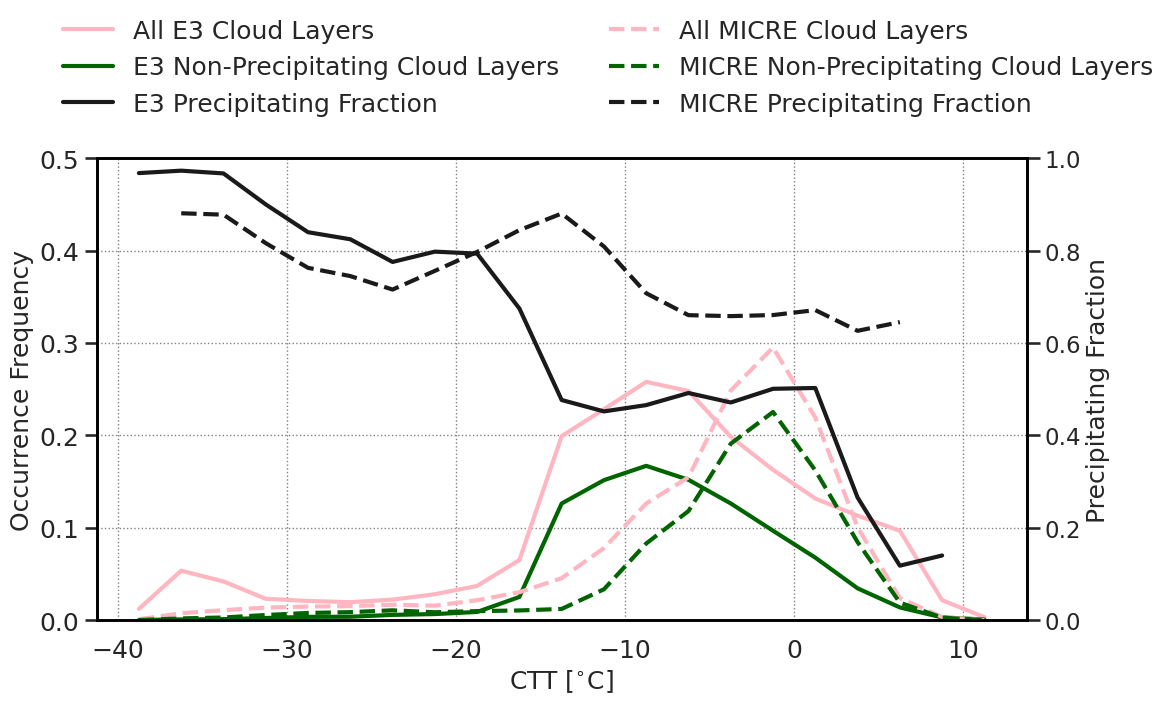

In [140]:
#----------------------------------------------------
#----------------------------------------------------
# Histogram of CTT
#----------------------------------------------------
#----------------------------------------------------

sns.set_style('ticks')
sns.set(rc={'axes.facecolor':'white','axes.edgecolor': 'black'})
sns.set_context('talk')
Fontsize=18
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)



ax.tick_params(labelsize=Fontsize)
ax.set_xlabel('CTT [$^{\\circ}$C]',fontsize=Fontsize)
ax.grid(which='both',c='grey',ls='dotted',lw=1)
ax.set_ylabel('Occurrence Frequency',fontsize=Fontsize)
ax.set_ylim(0,0.5)


axa = ax.twinx()
axa.grid(visible=None)
axa.set_ylim(0,1)
axa.set_ylabel('Precipitating Fraction',fontsize=Fontsize)

pink_color = 'lightpink'
green_color = 'darkgreen'

ctt_bins = np.arange(-40,15,2.5)
ctt_midbins = np.array([(ctt_bins[ii] + ctt_bins[ii+1])/2 for ii in range(len(ctt_bins)-1)])  
  
dumthick=2.

# E3
precip_0 = np.where((precip_binary == 0.) & (cbh > 250.))
precip_1 = np.where((precip_binary == 1.) & (cbh > 250.))
all_id = np.where((precip_binary == 0.) | (precip_binary == 1.) & (cbh > 250.))
ctt_precip = ctt[precip_1]
ctt_nonprecip = ctt[precip_0]
ctt_all = ctt[all_id]
samp_size = np.size(precip_1)
# All
occur_freq_all,dumbins = occur_freq(ctt_all,ctt_bins,samp_size) 
dumx = np.arange(1,len(ctt_midbins)+1,1)
ax.plot(ctt_midbins,occur_freq_all,c=pink_color,lw=3)
#Non-precipitating
samp_size = np.size(precip_0)
occur_freq_nonprecip,dumbins = occur_freq(ctt_nonprecip,ctt_bins,samp_size)
ax.plot(ctt_midbins,occur_freq_nonprecip,c=green_color,lw=3)
# Precipitating Fraction
pf = precip_frac(ctt_precip,ctt_all,ctt_bins)
pf[pf == 0.] = np.nan
axa.plot(ctt_midbins[:-1],pf[:-1],lw=3,c='k')


# MICRE
precip_0 = np.where(micre_precip_binary == 0.)
precip_1 = np.where(micre_precip_binary == 1.)
all_id = np.where((micre_precip_binary == 0.) | (micre_precip_binary == 1.))
ctt_precip = micre_ctt[precip_1]
ctt_nonprecip = micre_ctt[precip_0]
ctt_all = micre_ctt[all_id]
samp_size = np.size(precip_1)
# All
occur_freq_all,dumbins = occur_freq(ctt_all,ctt_bins,samp_size) 
dumx = np.arange(1,len(ctt_midbins)+1,1)
ax.plot(ctt_midbins,occur_freq_all,c=pink_color,lw=3,ls='dashed')
#Non-precipitating
samp_size = np.size(precip_0)
occur_freq_nonprecip,dumbins = occur_freq(ctt_nonprecip,ctt_bins,samp_size)
ax.plot(ctt_midbins,occur_freq_nonprecip,c=green_color,lw=3,ls='dashed')
# Precipitating Fraction
pf = precip_frac(ctt_precip,ctt_all,ctt_bins)
pf[pf == 0.] = np.nan
axa.plot(ctt_midbins[:-1],pf[:-1],lw=3,c='k',ls='dashed')


legend_elements = [Line2D([0], [0], label='All E3 Cloud Layers',lw=3,c=pink_color,ls='solid'),\
                   Line2D([0], [0], label='E3 Non-Precipitating Cloud Layers',lw=3,c=green_color,ls='solid'),\
                   Line2D([0], [0], label='E3 Precipitating Fraction',lw=3,c='k',ls='solid'),\
                   Line2D([0], [0], label='All MICRE Cloud Layers',lw=3,c=pink_color,ls='dashed'),\
                   Line2D([0], [0], label='MICRE Non-Precipitating Cloud Layers',lw=3,c=green_color,ls='dashed'),\
                   Line2D([0], [0], label='MICRE Precipitating Fraction',lw=3,c='k',ls='dashed'),\
                  ]

lgnd = ax.legend(handles=legend_elements,fontsize=Fontsize,loc='upper center',framealpha=0,bbox_to_anchor=(0.55,1.35),ncol=2)

plt.subplots_adjust(hspace=0.3,wspace=0.4)
plt.show()
plt.close()

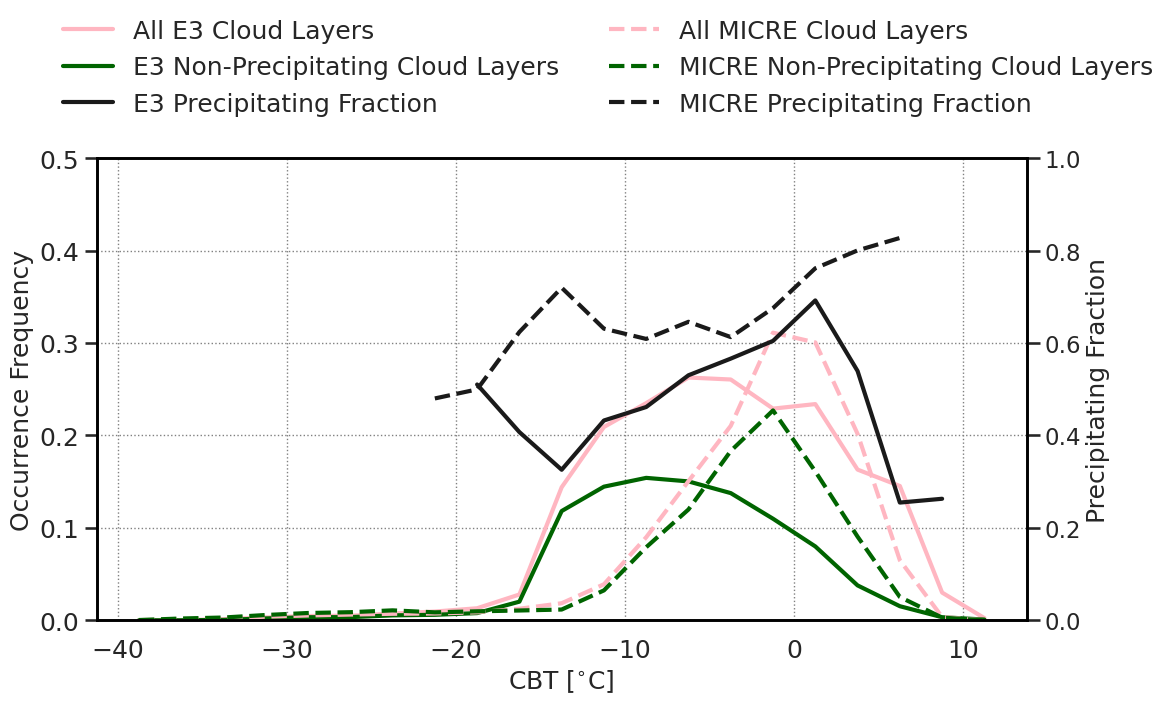

In [141]:
#----------------------------------------------------
#----------------------------------------------------
# Histogram of CBT
#----------------------------------------------------
#----------------------------------------------------

sns.set_style('ticks')
sns.set(rc={'axes.facecolor':'white','axes.edgecolor': 'black'})
sns.set_context('talk')
Fontsize=18
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)



ax.tick_params(labelsize=Fontsize)
ax.set_xlabel('CBT [$^{\\circ}$C]',fontsize=Fontsize)
ax.grid(which='both',c='grey',ls='dotted',lw=1)
ax.set_ylabel('Occurrence Frequency',fontsize=Fontsize)
ax.set_ylim(0,0.5)


axa = ax.twinx()
axa.grid(visible=None)
axa.set_ylim(0,1)
axa.set_ylabel('Precipitating Fraction',fontsize=Fontsize)

pink_color = 'lightpink'
green_color = 'darkgreen'

cbt_bins = np.arange(-40,15,2.5)
cbt_midbins = np.array([(cbt_bins[ii] + cbt_bins[ii+1])/2 for ii in range(len(cbt_bins)-1)])  
  
dumthick=2.

# E3
precip_0 = np.where((precip_binary == 0.) & (cbh > 250.))
precip_1 = np.where((precip_binary == 1.) & (cbh > 250.))
all_id = np.where((precip_binary == 0.) | (precip_binary == 1.) & (cbh > 250.))
cbt_precip = cbt[precip_1]
cbt_nonprecip = cbt[precip_0]
cbt_all = cbt[all_id]
samp_size = np.size(precip_1)
# All
occur_freq_all,dumbins = occur_freq(cbt_all,cbt_bins,samp_size) 
dumx = np.arange(1,len(cbt_midbins)+1,1)
ax.plot(cbt_midbins,occur_freq_all,c=pink_color,lw=3)
#Non-precipitating
samp_size = np.size(precip_0)
occur_freq_nonprecip,dumbins = occur_freq(cbt_nonprecip,cbt_bins,samp_size)
ax.plot(cbt_midbins,occur_freq_nonprecip,c=green_color,lw=3)
# Precipitating Fraction
pf = precip_frac(cbt_precip,cbt_all,cbt_bins)
pf[pf == 0.] = np.nan
axa.plot(cbt_midbins[:-1],pf[:-1],lw=3,c='k')


# MICRE
precip_0 = np.where(micre_precip_binary == 0.)
precip_1 = np.where(micre_precip_binary == 1.)
all_id = np.where((micre_precip_binary == 0.) | (micre_precip_binary == 1.))
cbt_precip = micre_cbt[precip_1]
cbt_nonprecip = micre_cbt[precip_0]
cbt_all = micre_cbt[all_id]
samp_size = np.size(precip_1)
# All
occur_freq_all,dumbins = occur_freq(cbt_all,cbt_bins,samp_size) 
dumx = np.arange(1,len(cbt_midbins)+1,1)
ax.plot(cbt_midbins,occur_freq_all,c=pink_color,lw=3,ls='dashed')
#Non-precipitating
samp_size = np.size(precip_0)
occur_freq_nonprecip,dumbins = occur_freq(cbt_nonprecip,cbt_bins,samp_size)
ax.plot(cbt_midbins,occur_freq_nonprecip,c=green_color,lw=3,ls='dashed')
# Precipitating Fraction
pf = precip_frac(cbt_precip,cbt_all,cbt_bins)
pf[pf == 0.] = np.nan
axa.plot(cbt_midbins[:-1],pf[:-1],lw=3,c='k',ls='dashed')


legend_elements = [Line2D([0], [0], label='All E3 Cloud Layers',lw=3,c=pink_color,ls='solid'),\
                   Line2D([0], [0], label='E3 Non-Precipitating Cloud Layers',lw=3,c=green_color,ls='solid'),\
                   Line2D([0], [0], label='E3 Precipitating Fraction',lw=3,c='k',ls='solid'),\
                   Line2D([0], [0], label='All MICRE Cloud Layers',lw=3,c=pink_color,ls='dashed'),\
                   Line2D([0], [0], label='MICRE Non-Precipitating Cloud Layers',lw=3,c=green_color,ls='dashed'),\
                   Line2D([0], [0], label='MICRE Precipitating Fraction',lw=3,c='k',ls='dashed'),\
                  ]

lgnd = ax.legend(handles=legend_elements,fontsize=Fontsize,loc='upper center',framealpha=0,bbox_to_anchor=(0.55,1.35),ncol=2)

plt.subplots_adjust(hspace=0.3,wspace=0.4)
plt.show()
plt.close()

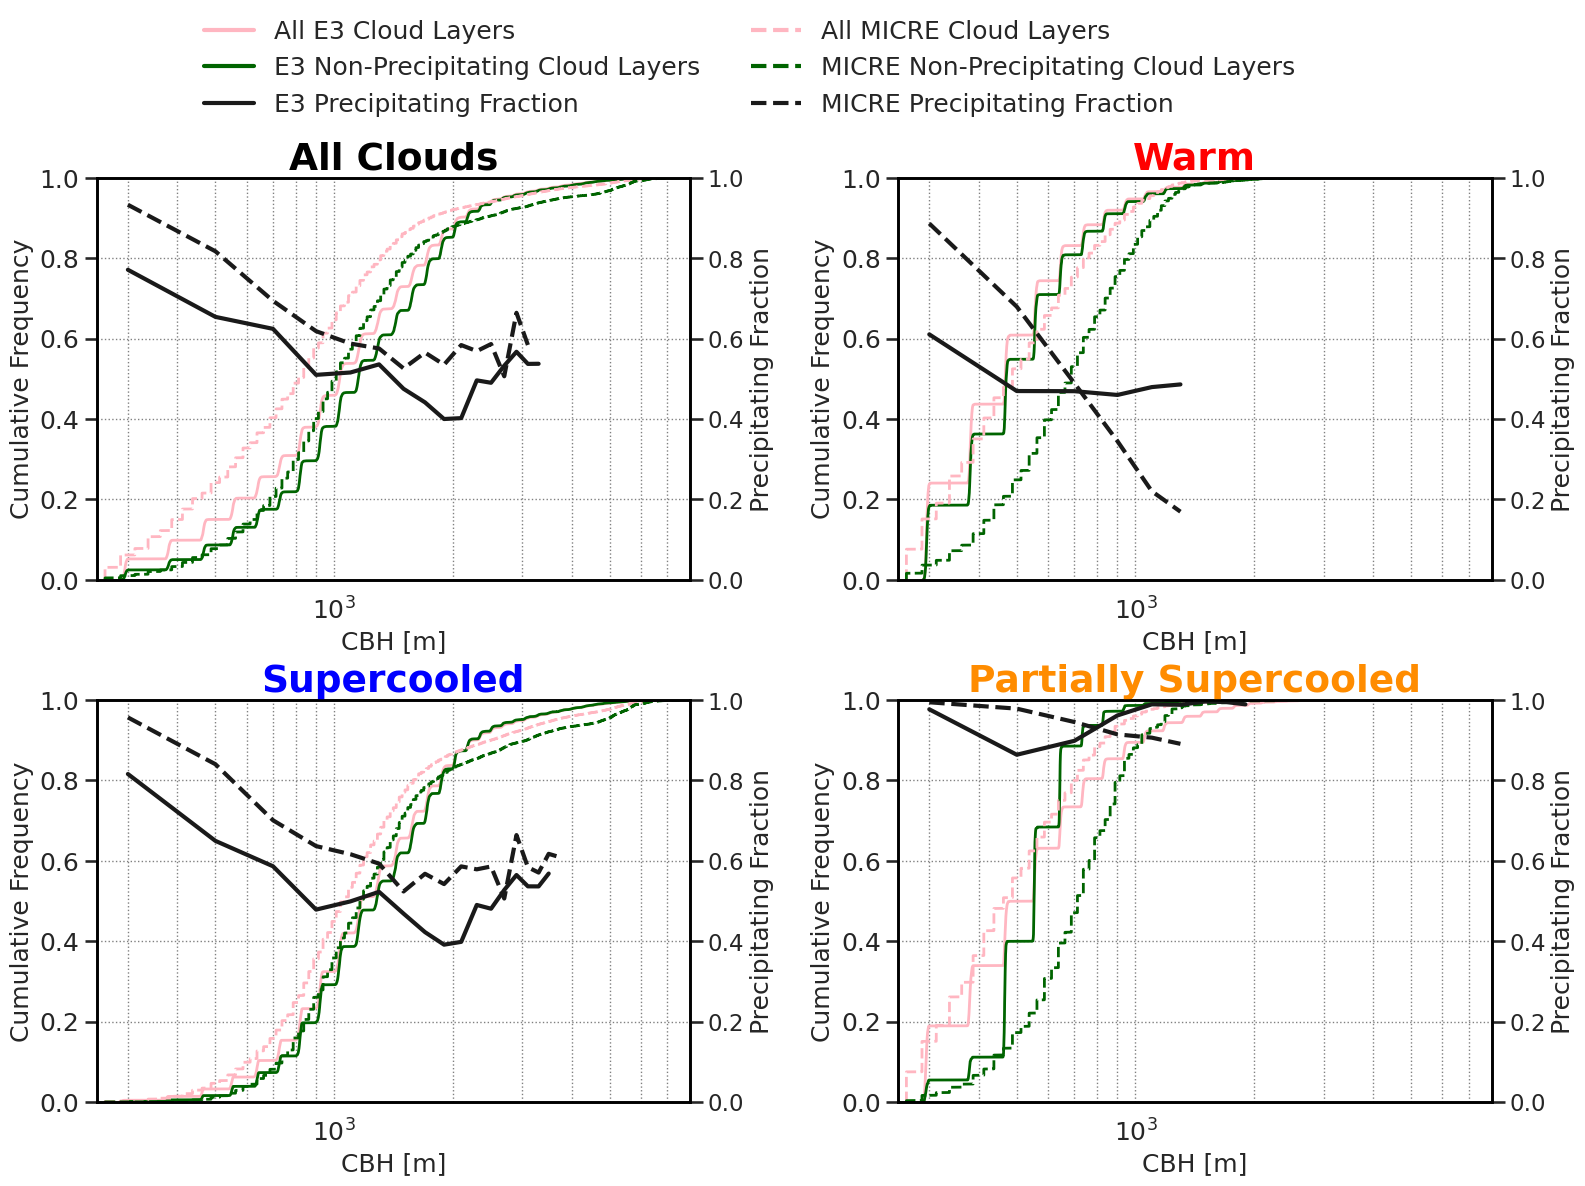

In [209]:
#----------------------------------------------------
#----------------------------------------------------
# Cumulative Distributions of CBH
#----------------------------------------------------
#----------------------------------------------------

sns.set_style('ticks')
sns.set(rc={'axes.facecolor':'white','axes.edgecolor': 'black'})
sns.set_context('talk')
Fontsize=18
fig = plt.figure(figsize=(18,12))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

    
filter_type_list = ['all','warm','supercooled','partially_supercooled']
label_list  = ['All Clouds','Warm','Supercooled','Partially Supercooled']
colors_list = ['black','red','blue','darkorange']

axlist = [ax1,ax2,ax3,ax4]

ii=0
for ax in axlist:
    ax.tick_params(labelsize=Fontsize)
    ax.set_xlabel('CBH [m]',fontsize=Fontsize)
    ax.grid(which='both',c='grey',ls='dotted',lw=1)
    ax.set_ylabel('Cumulative Frequency',fontsize=Fontsize)
    ax.set_title(label_list[ii],c=colors_list[ii],fontsize=Fontsize*1.5,fontweight='bold')
    ax.set_ylim(0,1)
    ii+=1

pink_color = 'lightpink'
green_color = 'darkgreen'


#---------------------------
# Loop through fitlerings
#---------------------------
cbh_bins = np.arange(0,8200,200)
cbh_midbins = np.array([(cbh_bins[ii] + cbh_bins[ii+1])/2 for ii in range(len(cbh_bins)-1)])

ii = 0
for ax in axlist:
    filter_type = filter_type_list[ii]
    ax = axlist[ii]
    
    axa = ax.twinx()
    axa.grid(visible=None)
    axa.set_ylim(0,1)
    axa.set_ylabel('Precipitating Fraction',fontsize=Fontsize)

    # E3
    dumid = np.where(cbh > 250.)
    var_precip, var_nonprecip, var_all = filter_data(precip_binary[dumid],cbt[dumid],ctt[dumid],cbh[dumid],filter_type)       
    # All clouds
    N = len(var_all)
    x = np.sort(var_all)
    y = np.arange(N) / float(N)
    ax.plot(x,y,lw=2,ls='solid',c=pink_color)
    # Non-precipitating clouds
    N = len(var_nonprecip)
    x = np.sort(var_nonprecip)
    y = np.arange(N) / float(N)
    ax.plot(x,y,lw=2,ls='solid',c=green_color)  
    
    # Precipitating Fraction 
    pf = precip_frac(var_precip,var_all,cbh_bins)
    pf[pf == 0.] = np.nan
    axa.plot(cbh_midbins,pf,lw=3,c='k',ls='solid')   
    

    # MICRE
    var_precip, var_nonprecip, var_all = filter_data(micre_precip_binary,micre_cbt,micre_ctt,micre_cbh,filter_type)       

    ax.set_xscale('log')
    ax.set_xlim(250,8000)
    
    # All clouds
    N = len(var_all)
    x = np.sort(var_all)
    y = np.arange(N) / float(N)
    ax.plot(x,y,lw=2,ls='dashed',c=pink_color)
    # Non-precipitating clouds
    N = len(var_nonprecip)
    x = np.sort(var_nonprecip)
    y = np.arange(N) / float(N)
    ax.plot(x,y,lw=2,ls='dashed',c=green_color)    
    # Precipitating Fraction 
    pf = precip_frac(var_precip,var_all,cbh_bins)
    pf[pf == 0.] = np.nan
    axa.plot(cbh_midbins,pf,lw=3,c='k',ls='dashed')     
    
    ii+=1

legend_elements = [Line2D([0], [0], label='All E3 Cloud Layers',lw=3,c=pink_color,ls='solid'),\
                   Line2D([0], [0], label='E3 Non-Precipitating Cloud Layers',lw=3,c=green_color,ls='solid'),\
                   Line2D([0], [0], label='E3 Precipitating Fraction',lw=3,c='k',ls='solid'),\
                   Line2D([0], [0], label='All MICRE Cloud Layers',lw=3,c=pink_color,ls='dashed'),\
                   Line2D([0], [0], label='MICRE Non-Precipitating Cloud Layers',lw=3,c=green_color,ls='dashed'),\
                   Line2D([0], [0], label='MICRE Precipitating Fraction',lw=3,c='k',ls='dashed'),\
                  ]


lgnd = ax1.legend(handles=legend_elements,fontsize=Fontsize,loc='upper center',framealpha=0,bbox_to_anchor=(1.1,1.45),ncol=2)

plt.subplots_adjust(hspace=0.3,wspace=0.35)
plt.show()
plt.close()

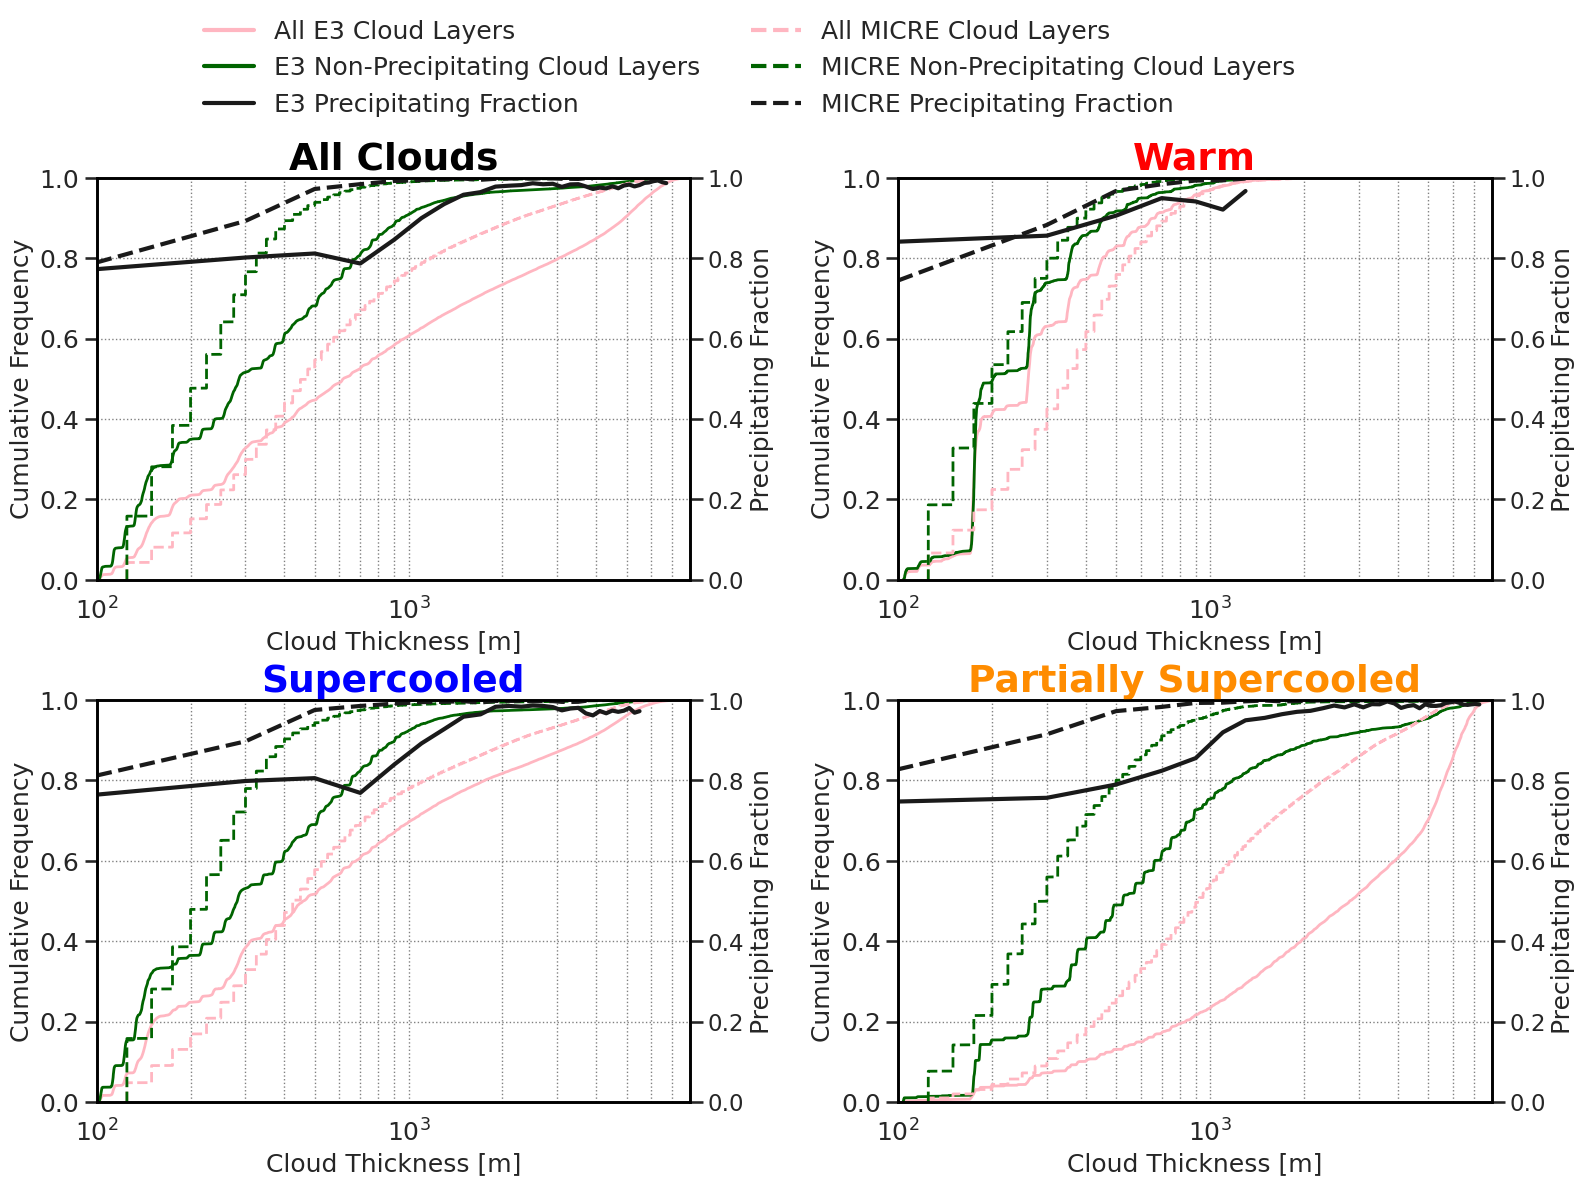

In [213]:
#----------------------------------------------------
#----------------------------------------------------
# Cumulative Distributions of Cloud thickness
#----------------------------------------------------
#----------------------------------------------------

sns.set_style('ticks')
sns.set(rc={'axes.facecolor':'white','axes.edgecolor': 'black'})
sns.set_context('talk')
Fontsize=18
fig = plt.figure(figsize=(18,12))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

    
filter_type_list = ['all','warm','supercooled','partially_supercooled']
label_list  = ['All Clouds','Warm','Supercooled','Partially Supercooled']
colors_list = ['black','red','blue','darkorange']

axlist = [ax1,ax2,ax3,ax4]

ii=0
for ax in axlist:
    ax.tick_params(labelsize=Fontsize)
    ax.set_xlabel('Cloud Thickness [m]',fontsize=Fontsize)
    ax.grid(which='both',c='grey',ls='dotted',lw=1)
    ax.set_ylabel('Cumulative Frequency',fontsize=Fontsize)
    ax.set_title(label_list[ii],c=colors_list[ii],fontsize=Fontsize*1.5,fontweight='bold')
    ax.set_ylim(0,1)
    ii+=1


pink_color = 'lightpink'
green_color = 'darkgreen'

depth_bins = np.arange(0,8200,200)
depth_midbins = np.array([(depth_bins[ii] + depth_bins[ii+1])/2 for ii in range(len(depth_bins)-1)])

#---------------------------
# Loop through fitlerings
#---------------------------

ii = 0
for ax in axlist:
    filter_type = filter_type_list[ii]
    ax = axlist[ii]
    
    axa = ax.twinx()
    axa.grid(visible=None)
    axa.set_ylim(0,1)
    axa.set_ylabel('Precipitating Fraction',fontsize=Fontsize)
    
    # E3
    dumid = np.where((c_thick > 100) & (cbh > 250.))
    #dumid = np.where((c_thick > 0) & (cbh > 250.))
    var_precip, var_nonprecip, var_all = filter_data(precip_binary[dumid],cbt[dumid],ctt[dumid],c_thick[dumid],filter_type)       
    # All clouds
    N = len(var_all)
    x = np.sort(var_all)
    y = np.arange(N) / float(N)
    ax.plot(x,y,lw=2,ls='solid',c=pink_color)
    # Non-precipitating clouds
    N = len(var_nonprecip)
    x = np.sort(var_nonprecip)
    y = np.arange(N) / float(N)
    ax.plot(x,y,lw=2,ls='solid',c=green_color)    
    # Precipitating Fraction 
    pf = precip_frac(var_precip,var_all,depth_bins)
    pf[pf == 0.] = np.nan
    axa.plot(depth_midbins,pf,lw=3,c='k',ls='solid')   
    
    # MICRE
    dumid = np.where(micre_c_thick > 100.)
    #dumid = np.where(micre_c_thick > 0.)
    var_precip, var_nonprecip, var_all = filter_data(micre_precip_binary[dumid],micre_cbt[dumid],micre_ctt[dumid],micre_c_thick[dumid],filter_type)       

    
    # All clouds
    N = len(var_all)
    x = np.sort(var_all)
    y = np.arange(N) / float(N)
    ax.plot(x,y,lw=2,ls='dashed',c=pink_color)
    # Non-precipitating clouds
    N = len(var_nonprecip)
    x = np.sort(var_nonprecip)
    y = np.arange(N) / float(N)
    ax.plot(x,y,lw=2,ls='dashed',c=green_color)    
    # Precipitating Fraction 
    pf = precip_frac(var_precip,var_all,depth_bins)
    pf[pf == 0.] = np.nan
    axa.plot(depth_midbins,pf,lw=3,c='k',ls='dashed') 
    
    ax.set_xscale('log')
    ax.set_xlim(100,8000)    
    
    ii+=1
    
legend_elements = [Line2D([0], [0], label='All E3 Cloud Layers',lw=3,c=pink_color,ls='solid'),\
                   Line2D([0], [0], label='E3 Non-Precipitating Cloud Layers',lw=3,c=green_color,ls='solid'),\
                   Line2D([0], [0], label='E3 Precipitating Fraction',lw=3,c='k',ls='solid'),\
                   Line2D([0], [0], label='All MICRE Cloud Layers',lw=3,c=pink_color,ls='dashed'),\
                   Line2D([0], [0], label='MICRE Non-Precipitating Cloud Layers',lw=3,c=green_color,ls='dashed'),\
                   Line2D([0], [0], label='MICRE Precipitating Fraction',lw=3,c='k',ls='dashed'),\
                  ]
legend_elements2 = [Line2D([0], [0], label='All E3 Cloud Layers',lw=3,c=pink_color,ls='solid'),\
                   Line2D([0], [0], label='E3 Non-Precipitating Cloud Layers',lw=3,c=green_color,ls='solid'),\
                   Line2D([0], [0], label='All MICRE Cloud Layers',lw=3,c=pink_color,ls='dashed'),\
                   Line2D([0], [0], label='MICRE Non-Precipitating Cloud Layers',lw=3,c=green_color,ls='dashed'),\
                  ]
lgnd = ax1.legend(handles=legend_elements,fontsize=Fontsize,loc='upper center',framealpha=0,bbox_to_anchor=(1.1,1.45),ncol=2)

plt.subplots_adjust(hspace=0.3,wspace=0.35)
plt.show()
plt.close()

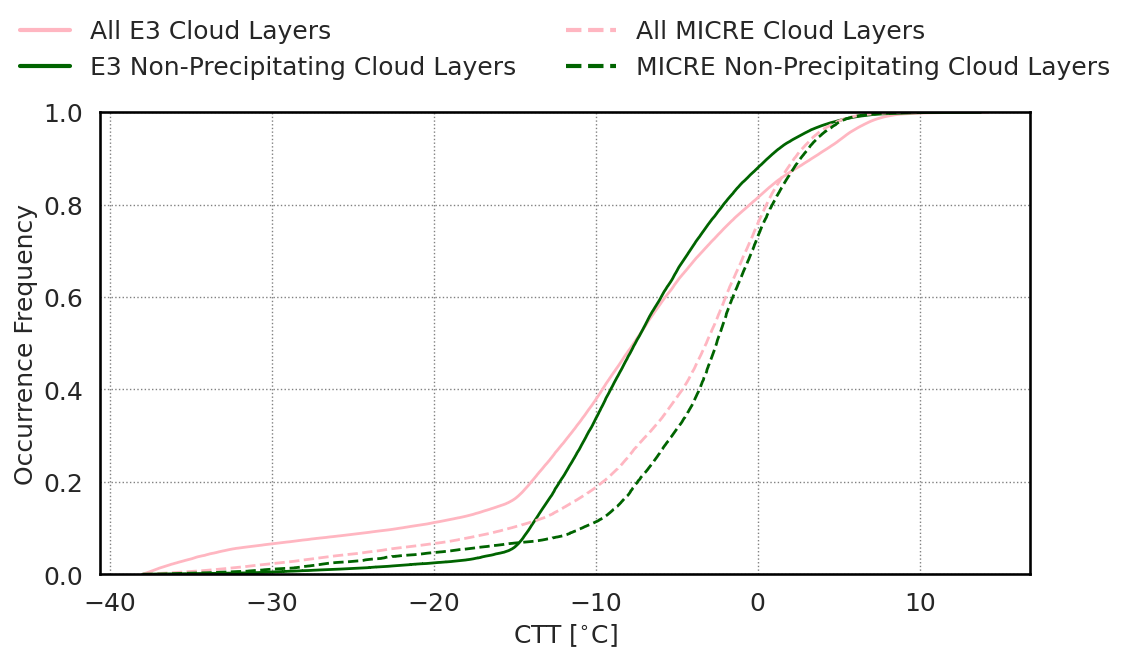

In [193]:
#----------------------------------------------------
#----------------------------------------------------
# Histogram of CTT
#----------------------------------------------------
#----------------------------------------------------

sns.set_style('ticks')
sns.set(rc={'axes.facecolor':'white','axes.edgecolor': 'black'})
sns.set_context('talk')
Fontsize=18
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)



ax.tick_params(labelsize=Fontsize)
ax.set_xlabel('CTT [$^{\\circ}$C]',fontsize=Fontsize)
ax.grid(which='both',c='grey',ls='dotted',lw=1)
ax.set_ylabel('Occurrence Frequency',fontsize=Fontsize)
ax.set_ylim(0,1)


pink_color = 'lightpink'
green_color = 'darkgreen'


# E3
precip_0 = np.where((precip_binary == 0.) & (cbh > 250.))
precip_1 = np.where((precip_binary == 1.) & (cbh > 250.))
all_id = np.where((precip_binary == 0.) | (precip_binary == 1.) & (cbh > 250.))
ctt_precip = ctt[precip_1]
ctt_nonprecip = ctt[precip_0]
ctt_all = ctt[all_id]
# All clouds
N = len(ctt_all)
x = np.sort(ctt_all)
y = np.arange(N) / float(N)
ax.plot(x,y,lw=2,ls='solid',c=pink_color)
# Non-precipitating Clouds
N = len(ctt_nonprecip)
x = np.sort(ctt_nonprecip)
y = np.arange(N) / float(N)
ax.plot(x,y,lw=2,ls='solid',c=green_color)

# MICRE
precip_0 = np.where((micre_precip_binary == 0.) )
precip_1 = np.where((micre_precip_binary == 1.))
micre_ctt_precip = micre_ctt[precip_1]
micre_ctt_nonprecip = micre_ctt[precip_0]
# All clouds
N = len(micre_ctt)
x = np.sort(micre_ctt)
y = np.arange(N) / float(N)
ax.plot(x,y,lw=2,ls='dashed',c=pink_color)
# Non-precipitating clouds
N = len(micre_ctt_nonprecip)
x = np.sort(micre_ctt_nonprecip)
y = np.arange(N) / float(N)
ax.plot(x,y,lw=2,ls='dashed',c=green_color)




legend_elements = [Line2D([0], [0], label='All E3 Cloud Layers',lw=3,c=pink_color,ls='solid'),\
                   Line2D([0], [0], label='E3 Non-Precipitating Cloud Layers',lw=3,c=green_color,ls='solid'),\
                   Line2D([0], [0], label='All MICRE Cloud Layers',lw=3,c=pink_color,ls='dashed'),\
                   Line2D([0], [0], label='MICRE Non-Precipitating Cloud Layers',lw=3,c=green_color,ls='dashed'),\
                  ]

lgnd = ax.legend(handles=legend_elements,fontsize=Fontsize,loc='upper center',framealpha=0,bbox_to_anchor=(0.5,1.25),ncol=2)

plt.subplots_adjust(hspace=0.3,wspace=0.4)
plt.show()
plt.close()

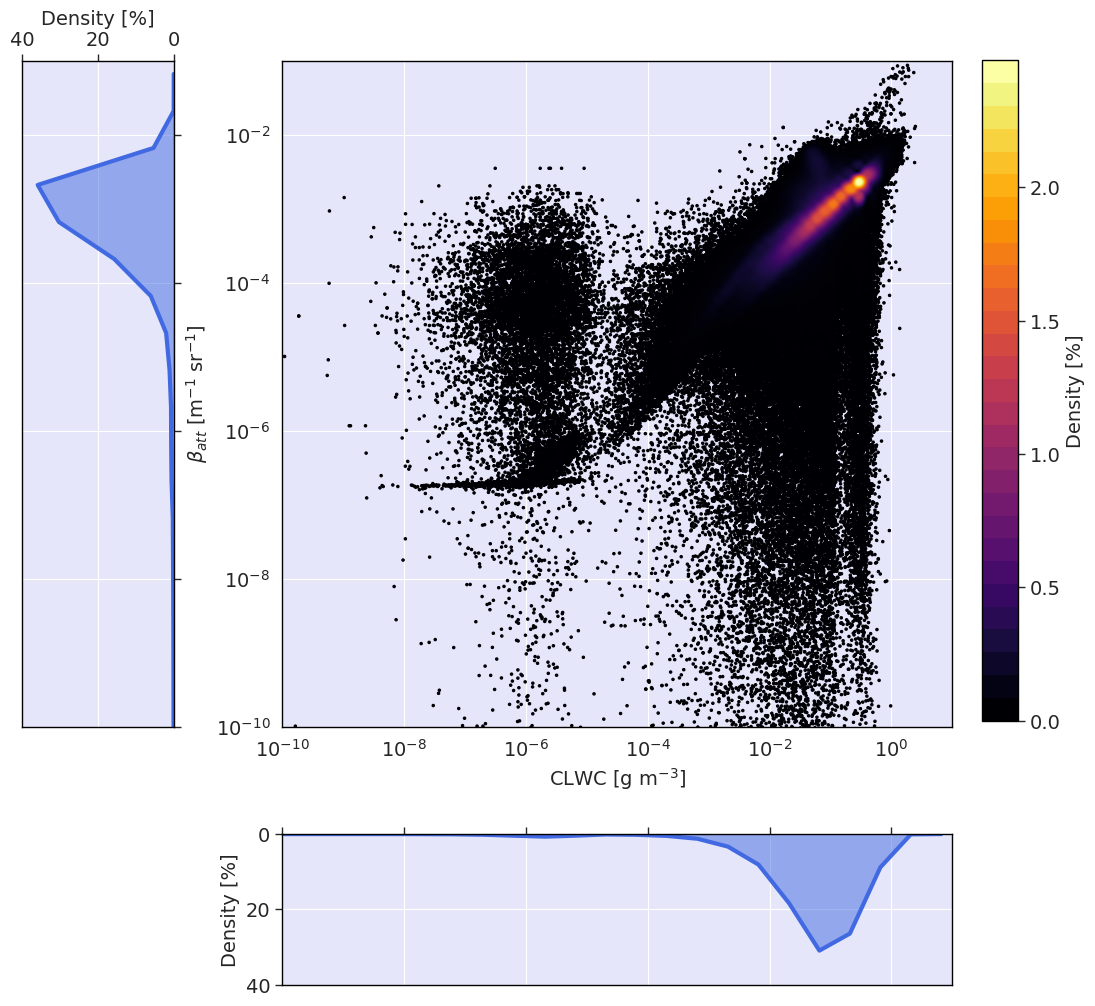

In [194]:
from scipy.interpolate import interpn
from matplotlib import cm
from matplotlib.colors import Normalize 

sns.set_theme()
sns.set_style('ticks')
sns.set(rc={'axes.facecolor':'lavender','axes.edgecolor': 'black'})
sns.set_context('paper')

fig = plt.figure(figsize=(12,12))
gs=GridSpec(8,8) # 6 rows, 6 columns

ax1 = fig.add_subplot(gs[0:6,2:8])
ax2 = fig.add_subplot(gs[0:6,0:2])
ax3 = fig.add_subplot(gs[6:8,2:8])

Fontsize=14
ax1.tick_params(labelsize=Fontsize)
ax1.set_xlabel('CLWC [g m$^{-3}$]',fontsize=Fontsize)
ax1.set_ylabel('$\\beta_{att}$ [m$^{-1}$ sr$^{-1}$]',fontsize=Fontsize)
x = e3_dict['cb_clwc']*1.e3
y = e3_dict['cb_beta_att']
ax1.set_xscale('log')
ax1.set_yscale('log')

#ax1.scatter(x,y,s=2,marker='o',c='k')
levels = np.array([0,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,\
                   0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,2,3,4,5,6,7,8,9,10])

x = e3_dict['cb_clwc']*1.e3
y = e3_dict['cb_beta_att']
bins1 = 10.**np.arange(-12,1.1,0.1)
bins2 = 10.**np.arange(-12,-0.9,0.1)

data , x_e, y_e = np.histogram2d(x, y,bins=[bins1,bins2], density = False)
data = data/np.size(x)*100.
z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data , np.vstack([x,y]).T , method = "splinef2d", bounds_error = False)
z[z < 0.] = 0.
#To be sure to plot all data
z[np.where(np.isnan(z))] = 0.0
# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
dum_cmap = 'inferno'

x, y, z = x[idx], y[idx], z[idx]
dum=ax1.scatter( x, y, c=z,s=3,cmap=dum_cmap)
cbar_ax = fig.add_axes([0.925,0.33,0.03,0.55])

nipy = cm.get_cmap('inferno',len(levels))
#bounds = levels
#norm = matplotlib.colors.BoundaryNorm(bounds,nipy.N)
norm = Normalize(vmin = np.min(z), vmax = np.max(z))
cbar = matplotlib.colorbar.ColorbarBase(cbar_ax,cmap=nipy,norm=norm,\
                                  spacing='uniform',\
                                  orientation='vertical')
cbar.ax.set_ylabel('Density [%]',fontsize=Fontsize)
cbar.ax.tick_params(labelsize=Fontsize)


ax2.xaxis.tick_top()
ax2.yaxis.tick_right()
ax3.yaxis.tick_left()
ax3.xaxis.tick_top()



ax2.set_xlabel('Density [%]',fontsize=Fontsize)
ax3.set_ylabel('Density [%]',fontsize=Fontsize)
ax2.xaxis.set_label_position('top') 


ax2.set_xlabel('Density [%]',fontsize=Fontsize)
ax3.set_ylabel('Density [%]',fontsize=Fontsize)
ax2.xaxis.set_label_position('top') 

bins1 = 10.**np.arange(-12,1.5,0.5)
bins2 = 10.**np.arange(-12,-0.5,0.5)

cb_clwc_hist,cb_clwc_bin_edges = np.histogram(e3_dict['cb_clwc']*1.e3,bins=bins1,density=False)
cb_beta_att_hist,cb_beta_att_bin_edges = np.histogram(e3_dict['cb_beta_att'],bins=bins2,density=False)

cb_clwc_hist = cb_clwc_hist/np.size(e3_dict['cb_clwc'])*100.
cb_beta_att_hist = cb_beta_att_hist/np.size(e3_dict['cb_beta_att'])*100.

dum_cb_clwc_midbins = np.array([(bins1[dd]+bins1[dd+1])/2. for dd in range(len(bins1)-1)])
dum_cb_beta_att_midbins = np.array([(bins2[dd]+bins2[dd+1])/2. for dd in range(len(bins2)-1)])

#ax2.bar(dum_cb_clwc_midbins,cb_clwc_hist,color='royalblue')
#ax3.barh(dum_cb_beta_att_midbins,cb_beta_att_hist,color='royalblue')
#ax3.plot(dum_cb_clwc_midbins,cb_clwc_hist,color='royalblue')
#ax2.barh(cb_beta_att_hist,dum_cb_beta_att_midbins,color='royalblue')


# Beta Att
ax2.plot(cb_beta_att_hist,dum_cb_beta_att_midbins,color='royalblue',lw=3)
#Fill under the curve
ax2.fill_between(
        x= cb_beta_att_hist, 
        y1= dum_cb_beta_att_midbins, 
        color= "royalblue",
        alpha= 0.5)
ax2.set_ylim(1.e-10,1.e-1)
ax2.set_yscale('log')
ax2.yaxis.set_ticklabels([])
ax2.set_xlim(40,0)

# CLWC
ax3.plot(dum_cb_clwc_midbins,cb_clwc_hist,color='royalblue',lw=3)
#Fill under the curve
ax3.fill_between(
        x= dum_cb_clwc_midbins, 
        y1= cb_clwc_hist, 
        color= "royalblue",
        alpha= 0.5)

ax3.set_xlim(1.e-10,1.e1)
ax3.set_xscale('log')
ax3.xaxis.set_ticklabels([])
ax3.set_ylim(40,0)

ax1.set_xlim(1.e-10,1.e1)
ax1.set_ylim(1.e-10,1.e-1)

ax2.tick_params(labelsize=Fontsize)
ax3.tick_params(labelsize=Fontsize)

plt.subplots_adjust(wspace=5,hspace=5)

plt.show()

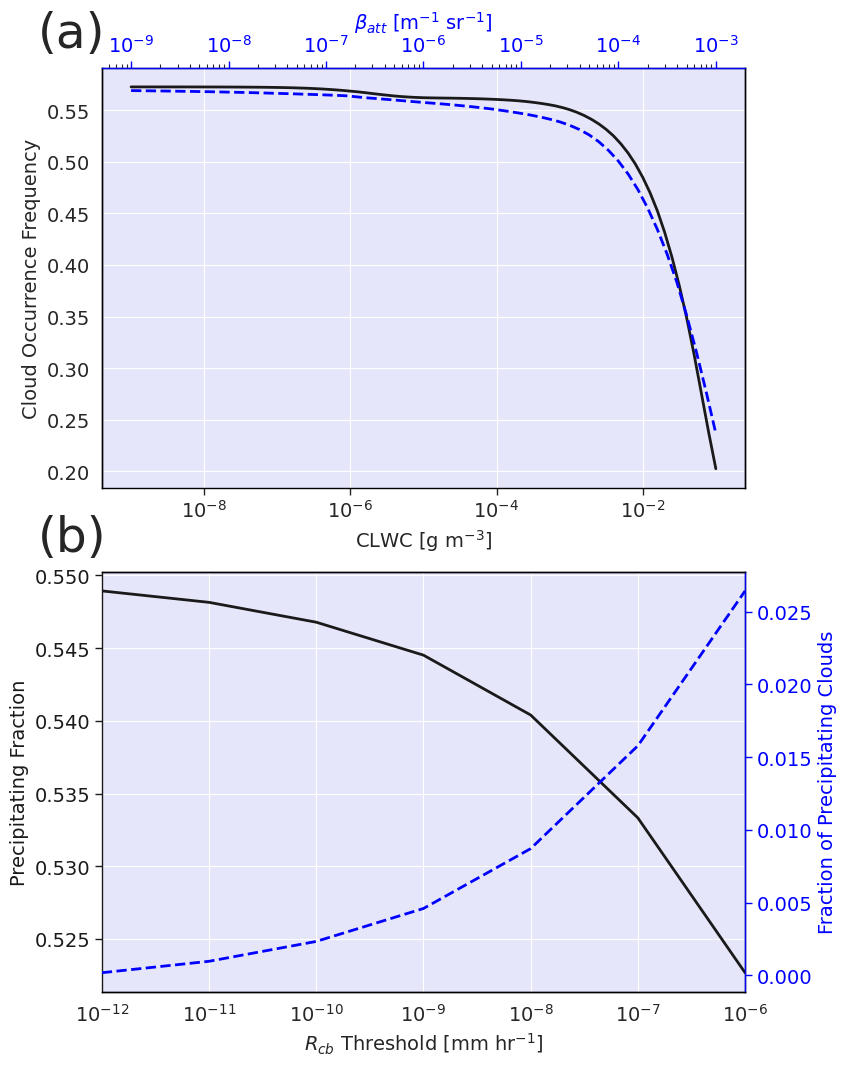

done


In [ ]:
#-------------------------
# Check sensitivity to minimim PR threshold
#-------------------------
thresh_arr = np.arange(-17,-5)
thresh_arr = 10.**thresh_arr
frac_of_dataset = []
precip_fracx = []
for ii in range(len(thresh_arr)):
    dum_precip_binary = precip_binary.copy()
    dumid = np.where( (rcb < thresh_arr[ii]) & (dum_precip_binary == 1.) )
    frac_of_dataset.append(np.size(dumid)/np.size(dum_precip_binary[dum_precip_binary == 1.]))
    dum_precip_binary[dumid] = 0.
    
    precip_id = np.where(dum_precip_binary == 1.)
    tmp_precip_frac = np.size(precip_id)/np.size(dum_precip_binary)
    precip_fracx.append(tmp_precip_frac)
precip_fracx = np.array(precip_fracx)
frac_of_dataset = np.array(frac_of_dataset)

fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(111)
ax1a = ax1.twinx()
Fontsize=14
#ax1.grid(which='both',ls='dotted',c='grey',lw=1)
ax1.tick_params(labelsize=Fontsize)
ax1a.tick_params(labelsize=Fontsize,color='darkorange')
ax1a.spines['right'].set_color('darkorange')
ax1a.tick_params(axis='y', which='both',colors='darkorange')

ax1.set_ylabel('Precipitating Fraction',fontsize=Fontsize)
ax1a.set_ylabel('Fraction of Precipitating Clouds',fontsize=Fontsize,c='darkorange')
ax1.set_xlabel('$R_{cb}$ Threshold [mm hr$^{-1}$]',fontsize=Fontsize)
ax1.set_xscale('log')
ax1.set_xlim(np.min(thresh_arr),np.max(thresh_arr))
ax1.plot(thresh_arr,precip_fracx,lw=2,c='navy',marker='o',markersize=5)
ax1a.plot(thresh_arr,frac_of_dataset,lw=2,c='darkorange',ls='dashed')
ax1a.grid(False)
plt.show()
plt.close()

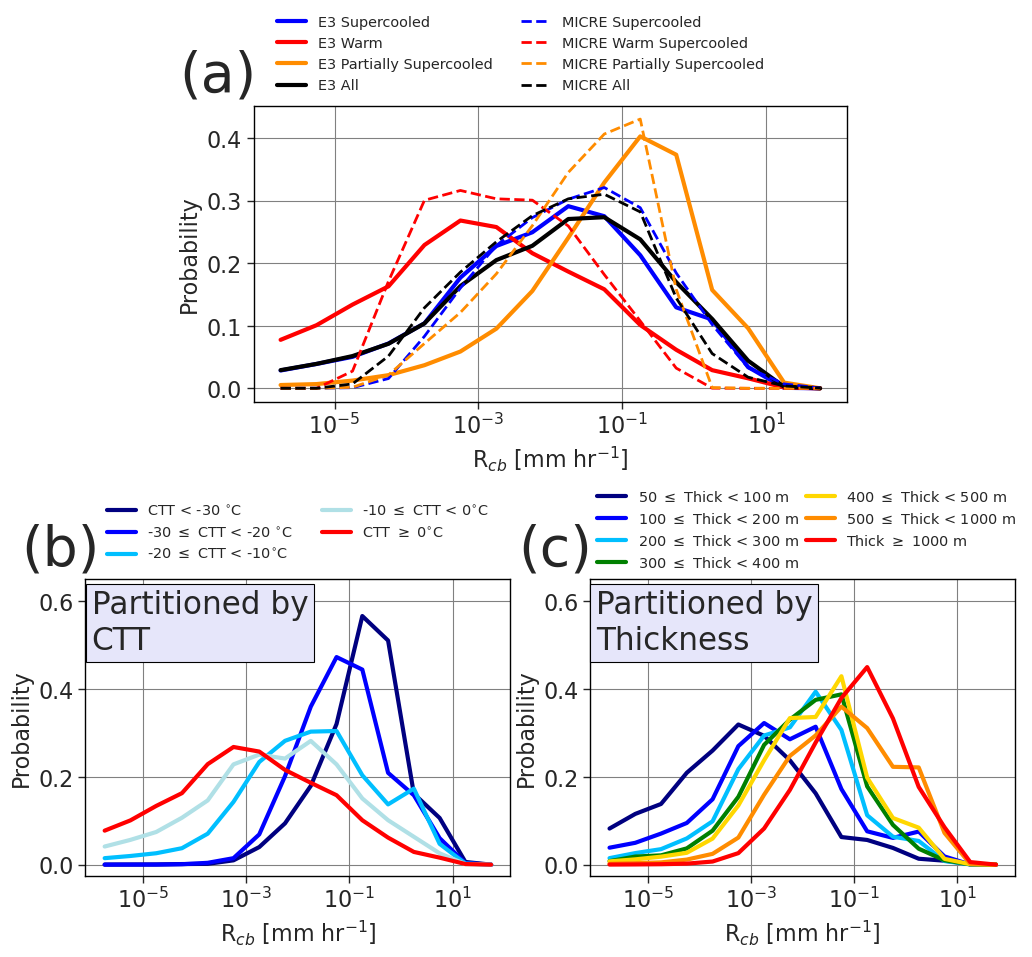

done


In [106]:
#----------------------------------------------------
#----------------------------------------------------
#----------------------------------------------------
# Rcb PDFs
#----------------------------------------------------
#----------------------------------------------------
#----------------------------------------------------

# Read in observational Rcb PDF
path = '/mnt/raid/mwstanfo/micre/'
infile = path+'micre_rcb_pdf_dict.p'
rcb_pdf_dict = pickle.load(open(infile,"rb"))


##sns.set_style('darkgrid',{"axes.facecolor": "grey"})
sns.set_theme()
sns.set_style('ticks')
#sns.set_style('darkgrid')
sns.set(rc={'axes.facecolor':'white','axes.edgecolor': 'black'})
sns.set_context('paper')

#matplotlib.rcParams.update(matplotlib.rcParamsDefault)
dumlw=3
Fontsize=16
fig = plt.figure(figsize=(12,10))
gs=GridSpec(2,6) # 2 rows, 6 columns
ax0 = fig.add_subplot(gs[0,1:5])
ax1 = fig.add_subplot(gs[1,0:3])       
ax2 = fig.add_subplot(gs[1,3:6])       

ax0.grid(which='both',ls='solid',color='grey')
ax1.grid(which='both',ls='solid',color='grey')
ax2.grid(which='both',ls='solid',color='grey')
ax0.tick_params(labelsize=Fontsize)
ax1.tick_params(labelsize=Fontsize)
ax2.tick_params(labelsize=Fontsize)
ax0.set_xlabel('R$_{cb}$ [mm hr$^{-1}$]',fontsize=Fontsize)
ax1.set_xlabel('R$_{cb}$ [mm hr$^{-1}$]',fontsize=Fontsize)
ax2.set_xlabel('R$_{cb}$ [mm hr$^{-1}$]',fontsize=Fontsize)
ax0.set_ylabel('Probability',fontsize=Fontsize)
ax1.set_ylabel('Probability',fontsize=Fontsize)
ax2.set_ylabel('Probability',fontsize=Fontsize)
ax0.set_xscale('log')
ax1.set_xscale('log')
ax2.set_xscale('log')


R_bins = np.arange(-6.,2.5,0.5)
midbins = np.array([(R_bins[ii]+R_bins[ii+1])/2. for ii in range(len(R_bins)-1)])


#------------------------------------
# Overarching distributions
#------------------------------------
dum_precip_binary = e3_dict['precip_binary'].copy()
dum_ctt = e3_dict['ctt'].copy()-273.15
dum_cbt = e3_dict['cbt'].copy()-273.15
dum_cth = e3_dict['cth'].copy()
dum_cbh = e3_dict['cbh'].copy()
dum_c_thick = e3_dict['c_thick'].copy()
dum_rcb = e3_dict['rcb'].copy()

precip_id = np.where((dum_precip_binary == 1.) & (dum_cbh > 250.) )

dum_rcb = dum_rcb[precip_id]
dum_ctt = dum_ctt[precip_id]
dum_cbt = dum_cbt[precip_id]
dum_cbh = dum_cbh[precip_id]
dum_c_thick = dum_c_thick[precip_id]
dum_precip_binary = dum_precip_binary[precip_id]


ice_id = np.where( (dum_precip_binary == 1.) &
                   (dum_ctt < 0.) &
                   (dum_cbt < 0.) &
                   (dum_cbh > 250.))


IWflx_lim = dum_rcb[ice_id]

liq_id = np.where( (dum_precip_binary == 1.) &
                   (dum_ctt >= 0.) &
                   (dum_cbt >= 0.) &
                   (dum_cbh > 250.))

LWflx_lim = dum_rcb[liq_id]

cold_id = np.where( (dum_precip_binary == 1.) &
                   (dum_ctt < 0.) &
                   (dum_cbt >= 0.) &
                   (dum_cbh > 250.))

LWflx_coldctt_lim = dum_rcb[cold_id]


dum_rcb = np.concatenate((IWflx_lim,LWflx_lim,LWflx_coldctt_lim))

# Ice
a,bin_edges = np.histogram(np.log10(IWflx_lim),bins=R_bins,density=True)
samp_size = np.size(IWflx_lim)
samp_size_perc = np.around(samp_size/np.size(precip_id)*100.,2)
#ax0.plot(10.**(midbins),a,lw=3,c='blue',ls='dashed',label='E3 Supercooled, N={} ({}%)'.format(samp_size,samp_size_perc))
ax0.plot(10.**(midbins),a,lw=dumlw,c='blue',label='E3 Supercooled')


# Liquid
a,bin_edges = np.histogram(np.log10(LWflx_lim),bins=R_bins,density=True)
samp_size = np.size(LWflx_lim)
samp_size_perc = np.around(samp_size/np.size(precip_id)*100.,2)
#ax0.plot(10.**(midbins),a,lw=3,c='red',ls='dashed',label='E3 Warm, N={} ({}%)'.format(samp_size,samp_size_perc))
ax0.plot(10.**(midbins),a,lw=dumlw,c='red',label='E3 Warm')

# Liquid with cold CTTs
samp_size = np.size(LWflx_coldctt_lim)
samp_size_perc = np.around(samp_size/np.size(precip_id)*100.,2)
a,bin_edges = np.histogram(np.log10(LWflx_coldctt_lim),bins=R_bins,density=True)
#ax0.plot(10.**(midbins),a,lw=3,c='darkorange',ls='dashed',label='E3 Partially Supercooled, N={} ({}%)'.format(samp_size,samp_size_perc))
ax0.plot(10.**(midbins),a,lw=dumlw,c='darkorange',label='E3 Partially Supercooled')

#All
a,bin_edges = np.histogram(np.log10(dum_rcb),bins=R_bins,density=True)
samp_size = np.size(dum_rcb)
#ax0.plot(10.**(midbins),a,lw=3,c='black',ls='dashed',label='E3 All, N={}'.format(samp_size))
ax0.plot(10.**(midbins),a,lw=dumlw,c='black',label='E3 All')

# Plot observed
ax0.plot(10.**(midbins),rcb_pdf_dict['supercooled'],lw=2,c='blue',ls='dashed',label='MICRE Supercooled')
ax0.plot(10.**(midbins),rcb_pdf_dict['warm'],lw=2,c='red',ls='dashed',label='MICRE Warm Supercooled')
ax0.plot(10.**(midbins),rcb_pdf_dict['partially_supercooled'],lw=2,c='darkorange',ls='dashed',label='MICRE Partially Supercooled')
ax0.plot(10.**(midbins),rcb_pdf_dict['all'],lw=2,c='black',ls='dashed',label='MICRE All')


#------------------------------------
# Partitioned by CTT
#------------------------------------
dum_precip_binary = e3_dict['precip_binary'].copy()
dum_ctt = e3_dict['ctt'].copy()-273.15
dum_cbt = e3_dict['cbt'].copy()-273.15
dum_cth = e3_dict['cth'].copy()
dum_cbh = e3_dict['cbh'].copy()
dum_c_thick = e3_dict['c_thick'].copy()
dum_rcb = e3_dict['rcb'].copy()

precip_id = np.where((dum_precip_binary == 1.)  & (dum_cbh > 250.))

dum_rcb = dum_rcb[precip_id]
dum_ctt = dum_ctt[precip_id]
dum_cbt = dum_cbt[precip_id]
dum_c_thick = dum_c_thick[precip_id]
dum_precip_binary = dum_precip_binary[precip_id]
dum_cbh = dum_cbh[precip_id]

ice_id = np.where((dum_precip_binary == 1.) &
                  (dum_ctt < 0.) &
                  (dum_cbt < 0.) &
                  (dum_cbh > 250.))


IWflx_lim = dum_rcb[ice_id]
ctt_super = dum_ctt[ice_id]

liq_id = np.where((dum_precip_binary == 1.) &
                  (dum_ctt >= 0.) &
                  (dum_cbt >= 0.) &
                  (dum_cbh > 250.))

LWflx_lim = dum_rcb[liq_id]
ctt_warm = dum_ctt[liq_id]

cold_id = np.where((dum_precip_binary == 1.) &
                  (dum_ctt < 0.) &
                  (dum_cbh > 250.) &
                  (dum_cbt >= 0.))

LWflx_coldctt_lim = dum_rcb[cold_id]
ctt_cold = dum_ctt[cold_id]

dum_rcb = np.concatenate((IWflx_lim,LWflx_lim,LWflx_coldctt_lim))
tmp_ctt = np.concatenate((ctt_super,ctt_warm,ctt_cold))

tmpid = np.where(tmp_ctt < -30.)
rcb_lt30 = dum_rcb[tmpid]
tmpid = np.where((tmp_ctt >= -30.) & (tmp_ctt < -20.))
rcb_30to20 = dum_rcb[tmpid]
tmpid = np.where((tmp_ctt >= -20.) & (tmp_ctt <-10.))
rcb_20to10 = dum_rcb[tmpid]
tmpid = np.where((tmp_ctt >= -10.) & (tmp_ctt < 0.))
rcb_10to0 = dum_rcb[tmpid]
tmpid = np.where(tmp_ctt > 0.)
rcb_gt0 = dum_rcb[tmpid]

rcb_lt30 = rcb_lt30[rcb_lt30 > 0.]
rcb_30to20 = rcb_30to20[rcb_30to20 > 0.]
rcb_20to10 = rcb_20to10[rcb_20to10 > 0.]
rcb_10to0 = rcb_10to0[rcb_10to0 > 0.]
rcb_gt0 = rcb_gt0[rcb_gt0 > 0.]


R_bins = np.arange(-6.,2.5,0.5)
midbins = np.array([(R_bins[ii]+R_bins[ii+1])/2. for ii in range(len(R_bins)-1)])




# lt -30
a,bin_edges = np.histogram(np.log10(rcb_lt30),bins=R_bins,density=True)
samp_size = np.size(rcb_lt30)
#ax1.plot(10.**(midbins),a,lw=3,c='navy',label='CTT < -30 $^{\\circ}$C, N='+str(samp_size))
ax1.plot(10.**(midbins),a,lw=dumlw,c='navy',label='CTT < -30 $^{\\circ}$C')

# -30 to -20
a,bin_edges = np.histogram(np.log10(rcb_30to20),bins=R_bins,density=True)
samp_size = np.size(rcb_30to20)
#ax1.plot(10.**(midbins),a,lw=3,c='blue',label='-30 $\leq$ CTT < -20 $^{\\circ}$C, N='+str(samp_size))
ax1.plot(10.**(midbins),a,lw=dumlw,c='blue',label='-30 $\leq$ CTT < -20 $^{\\circ}$C')

# -20 to -10
a,bin_edges = np.histogram(np.log10(rcb_20to10),bins=R_bins,density=True)
samp_size = np.size(rcb_20to10)
#ax1.plot(10.**(midbins),a,lw=3,c='deepskyblue',label='-20 $\leq$ CTT < -10$^{\\circ}$C, N='+str(samp_size))
ax1.plot(10.**(midbins),a,lw=dumlw,c='deepskyblue',label='-20 $\leq$ CTT < -10$^{\\circ}$C')

# -10 to -0
a,bin_edges = np.histogram(np.log10(rcb_10to0),bins=R_bins,density=True)
samp_size = np.size(rcb_10to0)
#ax1.plot(10.**(midbins),a,lw=3,c='powderblue',label='-10 $\leq$ CTT < 0$^{\\circ}$C, N='+str(samp_size))
ax1.plot(10.**(midbins),a,lw=dumlw,c='powderblue',label='-10 $\leq$ CTT < 0$^{\\circ}$C')

# gt 0
a,bin_edges = np.histogram(np.log10(rcb_gt0),bins=R_bins,density=True)
samp_size = np.size(rcb_gt0)
#ax1.plot(10.**(midbins),a,lw=3,c='red',label='CTT > 0$^{\\circ}$C, N='+str(samp_size))
ax1.plot(10.**(midbins),a,lw=dumlw,c='red',label='CTT $\geq$ 0$^{\\circ}$C')




dum_thresh = 6*60.*60.
#------------------------------------
# Partitioned by c_thick
#------------------------------------
dum_precip_binary = e3_dict['precip_binary'].copy()
dum_ctt = e3_dict['ctt'].copy()-273.15
dum_cbt = e3_dict['cbt'].copy()-273.15
dum_cth = e3_dict['cth'].copy()
dum_cbh = e3_dict['cbh'].copy()
dum_c_thick = e3_dict['c_thick'].copy()
dum_rcb = e3_dict['rcb'].copy()

precip_id = np.where((dum_precip_binary == 1.) & (dum_cbh > 250.) )

dum_rcb = dum_rcb[precip_id]
dum_ctt = dum_ctt[precip_id]
dum_cbt = dum_cbt[precip_id]
dum_cbh = dum_cbh[precip_id]
dum_c_thick = dum_c_thick[precip_id]
dum_precip_binary = dum_precip_binary[precip_id]





tmpid = np.where((dum_c_thick >= 50.) & (dum_c_thick < 100))
rcb_50to100 = dum_rcb[tmpid]
tmpid = np.where((dum_c_thick >= 100) & (dum_c_thick < 200))
rcb_100to200 = dum_rcb[tmpid]
tmpid = np.where((dum_c_thick >= 200) & (dum_c_thick < 300))
rcb_200to300 = dum_rcb[tmpid]
tmpid = np.where((dum_c_thick >= 300) & (dum_c_thick < 400))
rcb_300to400 = dum_rcb[tmpid]
tmpid = np.where((dum_c_thick >= 400) & (dum_c_thick < 500))
rcb_400to500 = dum_rcb[tmpid]    
tmpid = np.where((dum_c_thick >= 500) & (dum_c_thick < 1000))
rcb_500to1000 = dum_rcb[tmpid]     
tmpid = np.where((dum_c_thick > 1000))
rcb_gt1000 = dum_rcb[tmpid]      


rcb_50to100 = rcb_50to100[rcb_50to100 > 0.]
rcb_100to200 = rcb_100to200[rcb_100to200 > 0.]
rcb_200to300 = rcb_200to300[rcb_200to300 > 0.]
rcb_300to400 = rcb_300to400[rcb_300to400 > 0.]
rcb_400to500 = rcb_400to500[rcb_400to500 > 0.]
rcb_500to1000 = rcb_500to1000[rcb_500to1000 > 0.]


# 50 < thick < 100
a,bin_edges = np.histogram(np.log10(rcb_50to100),bins=R_bins,density=True)
samp_size = np.size(rcb_50to100)
#ax2.plot(10.**(midbins),a,lw=3,c='navy',label='50 $\leq$ Thick < 100 m, N='+str(samp_size))
ax2.plot(10.**(midbins),a,lw=dumlw,c='navy',label='50 $\leq$ Thick < 100 m')

# 100 < thick < 200
a,bin_edges = np.histogram(np.log10(rcb_100to200),bins=R_bins,density=True)
samp_size = np.size(rcb_100to200)
#ax2.plot(10.**(midbins),a,lw=3,c='blue',label='100 $\leq$ Thick < 200 m, N='+str(samp_size))
ax2.plot(10.**(midbins),a,lw=dumlw,c='blue',label='100 $\leq$ Thick < 200 m')

# 200 < thick < 300
a,bin_edges = np.histogram(np.log10(rcb_200to300),bins=R_bins,density=True)
samp_size = np.size(rcb_200to300)
#ax2.plot(10.**(midbins),a,lw=3,c='deepskyblue',label='200 $\leq$ Thick < 300 m, N='+str(samp_size))
ax2.plot(10.**(midbins),a,lw=dumlw,c='deepskyblue',label='200 $\leq$ Thick < 300 m')

# 300 < thick < 400
a,bin_edges = np.histogram(np.log10(rcb_300to400),bins=R_bins,density=True)
samp_size = np.size(rcb_300to400)
#ax2.plot(10.**(midbins),a,lw=3,c='green',label='300 $\leq$ Thick < 400 m, N='+str(samp_size))
ax2.plot(10.**(midbins),a,lw=dumlw,c='green',label='300 $\leq$ Thick < 400 m')

# 400 < thick < 500
a,bin_edges = np.histogram(np.log10(rcb_400to500),bins=R_bins,density=True)
samp_size = np.size(rcb_400to500)
#ax2.plot(10.**(midbins),a,lw=3,c='gold',label='400 $\leq$ Thick < 500 m, N='+str(samp_size))
ax2.plot(10.**(midbins),a,lw=dumlw,c='gold',label='400 $\leq$ Thick < 500 m')

# 500 < thick < 1000
a,bin_edges = np.histogram(np.log10(rcb_500to1000),bins=R_bins,density=True)
samp_size = np.size(rcb_500to1000)
#ax2.plot(10.**(midbins),a,lw=3,c='darkorange',label='500 $\leq$ Thick < 1000 m, N='+str(samp_size)) 
ax2.plot(10.**(midbins),a,lw=dumlw,c='darkorange',label='500 $\leq$ Thick < 1000 m') 

# thick > 1000
a,bin_edges = np.histogram(np.log10(rcb_gt1000),bins=R_bins,density=True)
samp_size = np.size(rcb_gt1000)
a#x2.plot(10.**(midbins),a,lw=3,c='red',label='Thick > 1000 m, N='+str(samp_size))
ax2.plot(10.**(midbins),a,lw=dumlw,c='red',label='Thick $\geq$ 1000 m')


ax0.text(-0.125,1.05,'(a)',fontsize=Fontsize*2.5,transform=ax0.transAxes)
ax1.text(-0.15,1.05,'(b)',fontsize=Fontsize*2.5,transform=ax1.transAxes)
ax2.text(-0.17,1.05,'(c)',fontsize=Fontsize*2.5,transform=ax2.transAxes)

dum1=ax1.text(0.015,0.765,'Partitioned by\nCTT',fontsize=Fontsize*1.4,transform=ax1.transAxes)
dum2=ax2.text(0.013,0.765,'Partitioned by\nThickness',fontsize=Fontsize*1.4,transform=ax2.transAxes)

dum1.set_bbox(dict(facecolor='lavender', alpha=1, edgecolor='black'))
dum2.set_bbox(dict(facecolor='lavender', alpha=1, edgecolor='black'))

#ax0.legend(fontsize=Fontsize*0.9,loc='upper center',bbox_to_anchor=(0.55,1.4),ncol=2,framealpha=0)
#ax1.legend(fontsize=Fontsize*0.75,bbox_to_anchor=(0.5,1.4),ncol=2,loc='upper center',framealpha=0)
#ax2.legend(fontsize=Fontsize*0.75,bbox_to_anchor=(0.525,1.4),ncol=2,loc='upper center',framealpha=0,columnspacing=0.5)
ax0.legend(fontsize=Fontsize*0.65,loc='upper center',bbox_to_anchor=(0.45,1.35),ncol=2,framealpha=0)
ax1.legend(fontsize=Fontsize*0.65,bbox_to_anchor=(0.5,1.3),ncol=2,loc='upper center',framealpha=0)
ax2.legend(fontsize=Fontsize*0.65,bbox_to_anchor=(0.51,1.35),ncol=2,loc='upper center',framealpha=0,columnspacing=0.5)

plt.subplots_adjust(wspace=0.9,hspace=0.6)
ax0.xaxis.tick_bottom()
ax0.yaxis.tick_left()
ax1.xaxis.tick_bottom()
ax1.yaxis.tick_left()
ax2.xaxis.tick_bottom()
ax2.yaxis.tick_left()

ax1.set_ylim(-0.025,0.65)
ax2.set_ylim(-0.025,0.65)

fig_path = '/home/mwstanfo/figures/micre_paper/'
#outfile = 'fig_12.png'
outfile = 'fig_12.eps'
plt.show()
#plt.savefig(fig_path+outfile,dpi=200,bbox_inches='tight')
plt.close()
print('done')

In [ ]:
#----------------------------------------------------
#----------------------------------------------------
#----------------------------------------------------
# Rcb PDFs
#----------------------------------------------------
#----------------------------------------------------
#----------------------------------------------------
##sns.set_style('darkgrid',{"axes.facecolor": "grey"})
sns.set_theme()
sns.set_style('ticks')
#sns.set_style('darkgrid')
sns.set(rc={'axes.facecolor':'white','axes.edgecolor': 'black'})
sns.set_context('paper')

#matplotlib.rcParams.update(matplotlib.rcParamsDefault)

Fontsize=16
fig = plt.figure(figsize=(14,12))
gs=GridSpec(2,6) # 2 rows, 6 columns
ax0 = fig.add_subplot(gs[0,1:5])
ax1 = fig.add_subplot(gs[1,0:3])       
ax2 = fig.add_subplot(gs[1,3:6])       

ax0.grid(which='both',ls='solid',color='grey')
ax1.grid(which='both',ls='solid',color='grey')
ax2.grid(which='both',ls='solid',color='grey')
ax0.tick_params(labelsize=Fontsize)
ax1.tick_params(labelsize=Fontsize)
ax2.tick_params(labelsize=Fontsize)
ax0.set_xlabel('R$_{cb}$ [mm hr$^{-1}$]',fontsize=Fontsize)
ax1.set_xlabel('R$_{cb}$ [mm hr$^{-1}$]',fontsize=Fontsize)
ax2.set_xlabel('R$_{cb}$ [mm hr$^{-1}$]',fontsize=Fontsize)
ax0.set_ylabel('Probability',fontsize=Fontsize)
ax1.set_ylabel('Probability',fontsize=Fontsize)
ax2.set_ylabel('Probability',fontsize=Fontsize)
ax0.set_xscale('log')
ax1.set_xscale('log')
ax2.set_xscale('log')


R_bins = np.arange(-6.,2.5,0.5)
midbins = np.array([(R_bins[ii]+R_bins[ii+1])/2. for ii in range(len(R_bins)-1)])


#------------------------------------
# Overarching distributions
#------------------------------------
dum_precip_binary = precip_binary.copy()
dum_ctt = ctt.copy()
dum_cth = cth.copy()
dum_cbt = cbt.copy()
dum_c_thick = c_thick.copy()
dum_rcb = rcb.copy()

precip_id = np.where((dum_precip_binary == 1.) & (~np.isnan(dum_ctt)) & (~np.isnan(dum_cbt)))

dum_rcb = dum_rcb[precip_id]
dum_ctt = dum_ctt[precip_id]
dum_cbt = dum_cbt[precip_id]
dum_c_thick = dum_c_thick[precip_id]
dum_precip_binary = dum_precip_binary[precip_id]


ice_id = np.where( (dum_precip_binary == 1.) &
                   (dum_ctt < 0.) &
                   (dum_cbt < 0.))


IWflx_lim = dum_rcb[ice_id]

liq_id = np.where( (dum_precip_binary == 1.) &
                   (dum_ctt >= 0.) &
                   (dum_cbt >= 0.))

LWflx_lim = dum_rcb[liq_id]

cold_id = np.where( (dum_precip_binary == 1.) &
                   (dum_ctt < 0.) &
                   (dum_cbt >= 0.))

LWflx_coldctt_lim = dum_rcb[cold_id]




dum_rcb = np.concatenate((IWflx_lim,LWflx_lim,LWflx_coldctt_lim))

# Ice
a,bin_edges = np.histogram(np.log10(IWflx_lim),bins=R_bins,density=True)
samp_size = np.size(IWflx_lim)
samp_size_perc = np.around(samp_size/np.size(precip_id)*100.,2)
ax0.plot(10.**(midbins),a,lw=3,c='blue',label='Supercooled, N={} ({}%)'.format(samp_size,samp_size_perc))
#ax0.plot(10.**(midbins),a,lw=3,c='blue',label='Supercooled')

# Liquid
a,bin_edges = np.histogram(np.log10(LWflx_lim),bins=R_bins,density=True)
samp_size = np.size(LWflx_lim)
samp_size_perc = np.around(samp_size/np.size(precip_id)*100.,2)
ax0.plot(10.**(midbins),a,lw=3,c='red',label='Warm, N={} ({}%)'.format(samp_size,samp_size_perc))
#ax0.plot(10.**(midbins),a,lw=3,c='red',label='Warm')

# Liquid with cold CTTs
samp_size = np.size(LWflx_coldctt_lim)
samp_size_perc = np.around(samp_size/np.size(precip_id)*100.,2)
a,bin_edges = np.histogram(np.log10(LWflx_coldctt_lim),bins=R_bins,density=True)
ax0.plot(10.**(midbins),a,lw=3,c='darkorange',label='Partially Supercooled, N={} ({}%)'.format(samp_size,samp_size_perc))
#ax0.plot(10.**(midbins),a,lw=3,c='darkorange',label='Partially Supercooled')

#All
a,bin_edges = np.histogram(np.log10(dum_rcb),bins=R_bins,density=True)
samp_size = np.size(dum_rcb)
ax0.plot(10.**(midbins),a,lw=3,c='black',label='All, N={}'.format(samp_size))
#ax0.plot(10.**(midbins),a,lw=3,c='black',label='All')

# NSA
#ax1.plot(10.**(midbins_2),nsa_mcm[0,:],c='darkgreen',lw=3,label='Arctic, supercooled')

# McMurdo
#ax1.plot(10.**(midbins_2),nsa_mcm[1,:],c='lightgreen',lw=3,label='Antarctic, supercooled')

#------------------------------------
# Partitioned by CTT
#------------------------------------

dum_precip_binary = precip_binary.copy()
dum_ctt = ctt.copy()
dum_cth = cth.copy()
dum_cbt = cbt.copy()
dum_c_thick = c_thick.copy()
dum_rcb = rcb.copy()

precip_id = np.where((dum_precip_binary == 1.) & (~np.isnan(dum_ctt)) & (~np.isnan(dum_cbt)))

dum_rcb = dum_rcb[precip_id]
dum_ctt = dum_ctt[precip_id]
dum_cbt = dum_cbt[precip_id]
dum_c_thick = dum_c_thick[precip_id]
dum_precip_binary = dum_precip_binary[precip_id]

ice_id = np.where((dum_precip_binary == 1.) &
                  (dum_ctt < 0.) &
                  (dum_cbt < 0.))


IWflx_lim = dum_rcb[ice_id]
ctt_super = dum_ctt[ice_id]


liq_id = np.where((dum_precip_binary == 1.) &
                  (dum_ctt >= 0.) &
                  (dum_cbt >= 0.))

LWflx_lim = dum_rcb[liq_id]
ctt_warm = dum_ctt[liq_id]

cold_id = np.where((dum_precip_binary == 1.) &
                  (dum_ctt < 0.) &
                  (dum_cbt >= 0.))

LWflx_coldctt_lim = dum_rcb[cold_id]
ctt_cold = dum_ctt[cold_id]

dum_rcb = np.concatenate((IWflx_lim,LWflx_lim,LWflx_coldctt_lim))
tmp_ctt = np.concatenate((ctt_super,ctt_warm,ctt_cold))
   

tmpid = np.where(tmp_ctt < -30.)
rcb_lt30 = dum_rcb[tmpid]
tmpid = np.where((tmp_ctt >= -30.) & (tmp_ctt < -20.))
rcb_30to20 = dum_rcb[tmpid]
tmpid = np.where((tmp_ctt >= -20.) & (tmp_ctt <-10.))
rcb_20to10 = dum_rcb[tmpid]
tmpid = np.where((tmp_ctt >= -10.) & (tmp_ctt < 0.))
rcb_10to0 = dum_rcb[tmpid]
tmpid = np.where(tmp_ctt > 0.)
rcb_gt0 = dum_rcb[tmpid]

rcb_lt30 = rcb_lt30[rcb_lt30 > 0.]
rcb_30to20 = rcb_30to20[rcb_30to20 > 0.]
rcb_20to10 = rcb_20to10[rcb_20to10 > 0.]
rcb_10to0 = rcb_10to0[rcb_10to0 > 0.]
rcb_gt0 = rcb_gt0[rcb_gt0 > 0.]


R_bins = np.arange(-6.,2.5,0.5)
midbins = np.array([(R_bins[ii]+R_bins[ii+1])/2. for ii in range(len(R_bins)-1)])




# lt -30
a,bin_edges = np.histogram(np.log10(rcb_lt30),bins=R_bins,density=True)
samp_size = np.size(rcb_lt30)
#ax1.plot(10.**(midbins),a,lw=3,c='navy',label='CTT < -30 $^{\\circ}$C, N='+str(samp_size))
ax1.plot(10.**(midbins),a,lw=3,c='navy',label='CTT < -30 $^{\\circ}$C')

# -30 to -20
a,bin_edges = np.histogram(np.log10(rcb_30to20),bins=R_bins,density=True)
samp_size = np.size(rcb_30to20)
#ax1.plot(10.**(midbins),a,lw=3,c='blue',label='-30 $\leq$ CTT < -20 $^{\\circ}$C, N='+str(samp_size))
ax1.plot(10.**(midbins),a,lw=3,c='blue',label='-30 $\leq$ CTT < -20 $^{\\circ}$C')

# -20 to -10
a,bin_edges = np.histogram(np.log10(rcb_20to10),bins=R_bins,density=True)
samp_size = np.size(rcb_20to10)
#ax1.plot(10.**(midbins),a,lw=3,c='deepskyblue',label='-20 $\leq$ CTT < -10$^{\\circ}$C, N='+str(samp_size))
ax1.plot(10.**(midbins),a,lw=3,c='deepskyblue',label='-20 $\leq$ CTT < -10$^{\\circ}$C')

# -10 to -0
a,bin_edges = np.histogram(np.log10(rcb_10to0),bins=R_bins,density=True)
samp_size = np.size(rcb_10to0)
#ax1.plot(10.**(midbins),a,lw=3,c='powderblue',label='-10 $\leq$ CTT < 0$^{\\circ}$C, N='+str(samp_size))
ax1.plot(10.**(midbins),a,lw=3,c='powderblue',label='-10 $\leq$ CTT < 0$^{\\circ}$C')

# gt 0
a,bin_edges = np.histogram(np.log10(rcb_gt0),bins=R_bins,density=True)
samp_size = np.size(rcb_gt0)
#ax1.plot(10.**(midbins),a,lw=3,c='red',label='CTT > 0$^{\\circ}$C, N='+str(samp_size))
ax1.plot(10.**(midbins),a,lw=3,c='red',label='CTT $\geq$ 0$^{\\circ}$C')




dum_thresh = 6*60.*60.
#------------------------------------
# Partitioned by c_thick
#------------------------------------
dum_precip_binary = precip_binary.copy()
dum_ctt = ctt.copy()
dum_cth = cth.copy()
dum_cbt = cbt.copy()
dum_c_thick = c_thick.copy()
dum_rcb = rcb.copy()

precip_id = np.where((dum_precip_binary == 1.) & (~np.isnan(dum_ctt)) & (~np.isnan(dum_cbt)))

dum_rcb = dum_rcb[precip_id]
dum_ctt = dum_ctt[precip_id]
dum_cbt = dum_cbt[precip_id]
dum_c_thick = dum_c_thick[precip_id]
dum_precip_binary = dum_precip_binary[precip_id]





tmpid = np.where((dum_c_thick >= 50.) & (dum_c_thick < 100))
rcb_50to100 = dum_rcb[tmpid]
tmpid = np.where((dum_c_thick >= 100) & (dum_c_thick < 200))
rcb_100to200 = dum_rcb[tmpid]
tmpid = np.where((dum_c_thick >= 200) & (dum_c_thick < 300))
rcb_200to300 = dum_rcb[tmpid]
tmpid = np.where((dum_c_thick >= 300) & (dum_c_thick < 400))
rcb_300to400 = dum_rcb[tmpid]
tmpid = np.where((dum_c_thick >= 400) & (dum_c_thick < 500))
rcb_400to500 = dum_rcb[tmpid]    
tmpid = np.where((dum_c_thick >= 500) & (dum_c_thick < 1000))
rcb_500to1000 = dum_rcb[tmpid]     
tmpid = np.where((dum_c_thick > 1000))
rcb_gt1000 = dum_rcb[tmpid]      


rcb_50to100 = rcb_50to100[rcb_50to100 > 0.]
rcb_100to200 = rcb_100to200[rcb_100to200 > 0.]
rcb_200to300 = rcb_200to300[rcb_200to300 > 0.]
rcb_300to400 = rcb_300to400[rcb_300to400 > 0.]
rcb_400to500 = rcb_400to500[rcb_400to500 > 0.]
rcb_500to1000 = rcb_500to1000[rcb_500to1000 > 0.]


# 50 < thick < 100
a,bin_edges = np.histogram(np.log10(rcb_50to100),bins=R_bins,density=True)
samp_size = np.size(rcb_50to100)
#ax2.plot(10.**(midbins),a,lw=3,c='navy',label='50 $\leq$ Thick < 100 m, N='+str(samp_size))
ax2.plot(10.**(midbins),a,lw=3,c='navy',label='50 $\leq$ Thick < 100 m')

# 100 < thick < 200
a,bin_edges = np.histogram(np.log10(rcb_100to200),bins=R_bins,density=True)
samp_size = np.size(rcb_100to200)
#ax2.plot(10.**(midbins),a,lw=3,c='blue',label='100 $\leq$ Thick < 200 m, N='+str(samp_size))
ax2.plot(10.**(midbins),a,lw=3,c='blue',label='100 $\leq$ Thick < 200 m')

# 200 < thick < 300
a,bin_edges = np.histogram(np.log10(rcb_200to300),bins=R_bins,density=True)
samp_size = np.size(rcb_200to300)
#ax2.plot(10.**(midbins),a,lw=3,c='deepskyblue',label='200 $\leq$ Thick < 300 m, N='+str(samp_size))
ax2.plot(10.**(midbins),a,lw=3,c='deepskyblue',label='200 $\leq$ Thick < 300 m')

# 300 < thick < 400
a,bin_edges = np.histogram(np.log10(rcb_300to400),bins=R_bins,density=True)
samp_size = np.size(rcb_300to400)
#ax2.plot(10.**(midbins),a,lw=3,c='green',label='300 $\leq$ Thick < 400 m, N='+str(samp_size))
ax2.plot(10.**(midbins),a,lw=3,c='green',label='300 $\leq$ Thick < 400 m')

# 400 < thick < 500
a,bin_edges = np.histogram(np.log10(rcb_400to500),bins=R_bins,density=True)
samp_size = np.size(rcb_400to500)
#ax2.plot(10.**(midbins),a,lw=3,c='gold',label='400 $\leq$ Thick < 500 m, N='+str(samp_size))
ax2.plot(10.**(midbins),a,lw=3,c='gold',label='400 $\leq$ Thick < 500 m')

# 500 < thick < 1000
a,bin_edges = np.histogram(np.log10(rcb_500to1000),bins=R_bins,density=True)
samp_size = np.size(rcb_500to1000)
#ax2.plot(10.**(midbins),a,lw=3,c='darkorange',label='500 $\leq$ Thick < 1000 m, N='+str(samp_size)) 
ax2.plot(10.**(midbins),a,lw=3,c='darkorange',label='500 $\leq$ Thick < 1000 m') 

# thick > 1000
a,bin_edges = np.histogram(np.log10(rcb_gt1000),bins=R_bins,density=True)
samp_size = np.size(rcb_gt1000)
a#x2.plot(10.**(midbins),a,lw=3,c='red',label='Thick > 1000 m, N='+str(samp_size))
ax2.plot(10.**(midbins),a,lw=3,c='red',label='Thick $\geq$ 1000 m')



#tmpstr = 'Partitioning by:'
#ax1.text(1.1,1.35,tmpstr,fontweight='bold',fontsize=Fontsize*2.,\
#         ha='center',va='center',transform=ax1.transAxes)    
#tmpstr = 'CTT'
#ax1.text(0.5,1.25,tmpstr,fontweight='bold',fontsize=Fontsize*2.,\
#         ha='center',va='center',transform=ax1.transAxes)
#tmpstr = 'Thickness'
#ax2.text(0.5,1.25,tmpstr,fontweight='bold',fontsize=Fontsize*2.,ha='center',va='center',\
#        transform=ax2.transAxes)

ax0.text(-0.125,1.05,'(a)',fontsize=Fontsize*2.75,transform=ax0.transAxes)
ax1.text(-0.15,1.2,'(b)',fontsize=Fontsize*2.75,transform=ax1.transAxes)
ax2.text(-0.15,1.2,'(c)',fontsize=Fontsize*2.75,transform=ax2.transAxes)

dum1=ax1.text(0.01,0.8,'Partitioned by\nCTT',fontsize=Fontsize*1.45,transform=ax1.transAxes)
dum2=ax2.text(0.01,0.8,'Partitioned by\nThickness',fontsize=Fontsize*1.45,transform=ax2.transAxes)

dum1.set_bbox(dict(facecolor='lavender', alpha=1, edgecolor='black'))
dum2.set_bbox(dict(facecolor='lavender', alpha=1, edgecolor='black'))

ax0.legend(fontsize=Fontsize*0.9,loc='upper center',bbox_to_anchor=(0.5,1.4),ncol=1,framealpha=0)
ax1.legend(fontsize=Fontsize*0.75,bbox_to_anchor=(0.5,1.4),ncol=2,loc='upper center',framealpha=0)
ax2.legend(fontsize=Fontsize*0.75,bbox_to_anchor=(0.525,1.4),ncol=2,loc='upper center',framealpha=0,columnspacing=0.5)


plt.subplots_adjust(wspace=0.7,hspace=0.6)
ax0.xaxis.tick_bottom()
ax0.yaxis.tick_left()
ax1.xaxis.tick_bottom()
ax1.yaxis.tick_left()
ax2.xaxis.tick_bottom()
ax2.yaxis.tick_left()

plt.show()
plt.close()    


In [ ]:
def filter_data(precip_binary,cbt,ctt,in_var,filter_type):
    dumid = np.where(in_var > -999.)
    in_var = in_var[dumid]
    cbt = cbt[dumid]
    ctt = ctt[dumid]
    precip_binary = precip_binary[dumid]
    
    dumid = np.where(ctt > -999.)
    in_var = in_var[dumid]
    cbt = cbt[dumid]
    ctt = ctt[dumid]
    precip_binary = precip_binary[dumid]
    
    dumid = np.where(cbt > -999.)
    in_var = in_var[dumid]
    cbt = cbt[dumid]
    ctt = ctt[dumid]
    precip_binary = precip_binary[dumid]
    
    if filter_type == 'supercooled':
        precip_0 = np.where((precip_binary == 0.) & (cbt < 0.) & (ctt < 0.))
        precip_1 = np.where((precip_binary == 1.) & (cbt < 0.) & (ctt < 0.))
        all_id = np.where((precip_binary > -999.) & (cbt < 0.) & (ctt < 0.))
        #all_id = np.where((cbt < 0.) & (ctt < 0.))
    elif filter_type == 'partially_supercooled':
        precip_0 = np.where((precip_binary == 0.) & (cbt >= 0.) & (ctt < 0.))
        precip_1 = np.where((precip_binary == 1.) & (cbt >= 0.) & (ctt < 0.))
        all_id = np.where((precip_binary > -999.) & (cbt >= 0.) & (ctt < 0.))
        #all_id = np.where((cbt >= 0.) & (ctt < 0.))
    elif filter_type == 'warm':
        precip_0 = np.where((precip_binary == 0.) & (cbt >= 0.) & (ctt >= 0.))
        precip_1 = np.where((precip_binary == 1.) & (cbt >= 0.) & (ctt >= 0.))
        all_id = np.where((precip_binary > -999.) & (cbt >= 0.) & (ctt >= 0.))
        #all_id = np.where((cbt >= 0.) & (ctt >= 0.))
    elif filter_type == 'all':
        precip_0 = np.where((precip_binary == 0.))
        precip_1 = np.where((precip_binary == 1.))
        all_id = np.where((precip_binary > -999.))
        #all_id = np.where((precip_binary == 0. ) | (precip_binary == 1.) | (np.isnan(precip_binary)))
    else:
        raise RuntimeError('Do better.')
        
    var_precip = in_var[precip_1]
    var_nonprecip = in_var[precip_0]
    var_all = in_var[all_id]
    return var_precip, var_nonprecip, var_all

In [ ]:
#--------------------------------------------
# Occurrence Frequency
#--------------------------------------------
def occur_freq(data,bins,full_length):
    tmp_hist = []
    for ii in range(len(bins)-1):
        if ii != (len(bins)-2):
            tmpid = np.where((data >= bins[ii]) & (data < bins[ii+1]))
            tmp_hist.append(np.size(tmpid)/full_length)
        elif ii == (len(bins)-2):
            tmpid = np.where((data >= bins[ii]) & (data <= bins[ii+1]))
            tmp_hist.append(np.size(tmpid)/full_length)            
    tmp_hist = np.array(tmp_hist)
    return tmp_hist,bins

In [ ]:
#--------------------------------------------
# Function to calculate precipitating fraction
#--------------------------------------------
def precip_frac(data1,data2,bins):
    data1 = data1[~np.isnan(data1)]
    #data1 = data1[data1 > -999.]
    data2 = data2[~np.isnan(data2)]
    #data2 = data2[data2 > -999.]
    thresh_frac = 0.005
    pf = []
    for ii in range(len(bins)-1):
        if ii != (len(bins)-2):
            tmpid1 = np.where((data1 >= bins[ii]) & (data1 < bins[ii+1]))
            tmpid2 = np.where((data2 >= bins[ii]) & (data2 < bins[ii+1]))
            if (np.size(tmpid2)/np.size(data2)) < thresh_frac:
                pf.append(np.nan)
            else:
                pf.append(np.size(tmpid1)/np.size(tmpid2))
        elif ii == (len(bins)-2):
            tmpid1 = np.where((data1 >= bins[ii]) & (data1 <= bins[ii+1]))
            tmpid2 = np.where((data2 >= bins[ii]) & (data2 <= bins[ii+1]))
            if (np.size(tmpid2)/np.size(data2)) < thresh_frac:
                pf.append(np.nan)
            else:
                pf.append(np.size(tmpid1)/np.size(tmpid2))
    pf = np.array(pf)
    return pf

In [ ]:
#----------------------------------------------------
#----------------------------------------------------
#----------------------------------------------------
# Histograms of CBH, CTT, and Cloud Thickness
#----------------------------------------------------
#----------------------------------------------------
#----------------------------------------------------
dum_ctt = ctt.copy()
dum_cbh = cbh.copy()
dum_cth = cth.copy()
dum_cbt = cbt.copy()
dum_precip_binary = precip_binary.copy()
dum_c_thick = c_thick.copy()


sns.set_style('ticks')
sns.set(rc={'axes.facecolor':'white','axes.edgecolor': 'black'})
sns.set_context('talk')

pink_color = 'lightpink'
pink_edgecolor = 'black'
pink_alpha = 1
green_color = 'darkgreen'
green_edgecolor = 'black'
green_alpha = 0.6

Fontsize=15
dummult = 1.15

fig = plt.figure(figsize=(20,14))
gs=GridSpec(3,8) # 7 rows, 6 columns

# Cloud Depth
ax1 = fig.add_subplot(gs[0,0:2]) #row, column        
ax2 = fig.add_subplot(gs[0,2:4]) # row, column        
ax3 = fig.add_subplot(gs[0,4:6]) # row, column        
ax4 = fig.add_subplot(gs[0,6:8]) # row, column
axlist1 = [ax1,ax2,ax3,ax4]

ax1a = ax1.twinx()
ax2a = ax2.twinx()
ax3a = ax3.twinx()
ax4a = ax4.twinx()

axlist1a = [ax1a,ax2a,ax3a,ax4a]
for ax in axlist1a:
    ax.tick_params(labelsize=Fontsize*dummult)
    ax.set_ylim(0,1.05)
    ax.set_yticks([0,0.5,1])
    ax.grid(False)
ax4a.set_ylabel('Precipitating Fraction',fontsize=Fontsize*dummult)
ax1.set_ylabel('Occurrence Frequency',fontsize=Fontsize*dummult)

# CBH
ax5 = fig.add_subplot(gs[1,0:2]) #row, column 
ax6 = fig.add_subplot(gs[1,2:4]) #row, column 
ax7 = fig.add_subplot(gs[1,4:6]) #row, column 
ax8 = fig.add_subplot(gs[1,6:8]) #row, column
axlist2 = [ax5,ax6,ax7,ax8]
for ax in axlist2:
    ax.set_xlabel('Cloud Thickness [m]',fontsize=Fontsize*dummult)
    ax.tick_params(labelsize=Fontsize*dummult)
    ax.grid(which='both',ls='solid',color='grey') 
    
ax5a = ax5.twinx()
ax6a = ax6.twinx()
ax7a = ax7.twinx()
ax8a = ax8.twinx()

axlist2a = [ax5a,ax6a,ax7a,ax8a]
for ax in axlist2a:
    ax.tick_params(labelsize=Fontsize*dummult)
    ax.set_ylim(0,1.05)
    ax.set_yticks([0,0.5,1])
    ax.grid(False)
ax8a.set_ylabel('Precipitating Fraction',fontsize=Fontsize*dummult)
ax5.set_ylabel('Occurrence Frequency',fontsize=Fontsize*dummult)
    
# CTT
ax9 = fig.add_subplot(gs[2,2:6]) #row, column 
ax9.set_xlabel('CTT [$^{\\circ}$C]',fontsize=Fontsize*dummult)
ax9.tick_params(labelsize=Fontsize*dummult)
ax9.grid(which='both',ls='solid',color='grey')
ax9a = ax9.twinx()
ax9a.tick_params(labelsize=Fontsize*dummult)
ax9a.set_ylabel('Precipitating Fraction',fontsize=Fontsize*dummult)
ax9.set_ylabel('Occurrence Frequency',fontsize=Fontsize*dummult)
ax9a.set_ylim(0,1.05)
ax9a.set_yticks([0,0.5,1])
ax9a.grid(False)

#-------------------------------------------
#-------------------------------------------
#-------------------------------------------
# Cloud Thickness
#-------------------------------------------
#-------------------------------------------
#-------------------------------------------
depth_bins = np.arange(0,8100,100)
depth_midbins = np.array([(depth_bins[ii] + depth_bins[ii+1])/2 for ii in range(len(depth_bins)-1)])
dum_depth_bins = np.arange(0,len(depth_bins))
dum_depth_midbins = np.array([(dum_depth_bins[ii] + dum_depth_bins[ii+1])/2 for ii in range(len(dum_depth_bins)-1)])

dumthick=0.8

#---------------------------
# Loop through fitlerings
#---------------------------



filter_type_list = ['supercooled','partially_supercooled','warm','all']
ii = 0
for ax in axlist1:
    filter_type = filter_type_list[ii]
    axa = axlist1a[ii]
    dumlim = 20
    #dumid = np.where(dum_c_thick > 0.)
    var_precip, var_nonprecip, var_all = filter_data(dum_precip_binary,dum_cbt,dum_ctt,dum_c_thick,filter_type)       

    # All clouds
    samp_size_all = np.size(var_all)
    occur_freq_all,dumbins = occur_freq(var_all,depth_bins,samp_size_all)
    ax.bar(dum_depth_midbins[0:dumlim],occur_freq_all[0:dumlim],width=dumthick,label='All Layers',\
           color=pink_color,alpha=pink_alpha,edgecolor=pink_edgecolor) 
    
    # Non-precipitating clouds
    samp_size_nonprecip = np.size(var_nonprecip)
    occur_freq_nonprecip,dumbins = occur_freq(var_nonprecip,depth_bins,samp_size_nonprecip)
    ax.bar(dum_depth_midbins[0:dumlim],occur_freq_nonprecip[0:dumlim],width=dumthick,label='Non-Precipitating Layers',\
           color=green_color,alpha=green_alpha,edgecolor=green_edgecolor)
 
    
    # Precipitating Fraction
    pf = precip_frac(var_precip,var_all,depth_bins)
    pf[pf == 0.] = np.nan
    axa.plot(dum_depth_midbins[0:dumlim],pf[0:dumlim],lw=3,c='k')
    ax.set_xlabel('Cloud Thickness [km]',fontsize=Fontsize*dummult)
    ax.tick_params(labelsize=Fontsize*dummult)
    ax.grid(which='both',ls='solid',color='grey')
    ax.set_xlim(0,dumlim)
    ax.set_ylim(0,0.3)
    ax.set_yticks([0,0.1,0.2,0.3])
    

    # Adjust axis ticks and labels
    ax.set_xticks(dum_depth_bins[0:dumlim+4:4])
    tmp_ticks = ax.get_xticks()
    #dum_labels = [(str(int(depth_bins[0:dumlim+2:2][dd]))) for dd in range(len(tmp_ticks))]
    dum_labels = [(str(depth_bins[0:dumlim+4:4][dd]*1.e-3)) for dd in range(len(tmp_ticks))]
    #ax.set_xticklabels(dum_labels,rotation=45,ha='center')
    ax.set_xticklabels(dum_labels,ha='center')
    
    ii+=1

#-------------------------------------------
#-------------------------------------------
#-------------------------------------------
# CBH
#-------------------------------------------
#-------------------------------------------
#-------------------------------------------
cbh_bins = np.arange(0,8100,100)
cbh_midbins = np.array([(cbh_bins[ii] + cbh_bins[ii+1])/2 for ii in range(len(cbh_bins)-1)])
dum_cbh_bins = np.arange(0,len(cbh_bins))
dum_cbh_midbins = np.array([(dum_cbh_bins[ii] + dum_cbh_bins[ii+1])/2 for ii in range(len(dum_cbh_bins)-1)])

dumthick=0.8
dumalpha=0.75

#---------------------------
# Loop through fitlerings
#---------------------------
dumlim = 20

filter_type_list = ['supercooled','partially_supercooled','warm','all']
ii = 0
for ax in axlist2:
    filter_type = filter_type_list[ii]
    axa = axlist2a[ii]

    var_precip, var_nonprecip, var_all = filter_data(precip_binary,dum_cbt,dum_ctt,dum_cbh,filter_type)       
    
    # All clouds
    samp_size_all = np.size(var_all)
    occur_freq_all,dumbins = occur_freq(var_all,cbh_bins,samp_size_all)
    ax.bar(dum_cbh_midbins[0:dumlim],occur_freq_all[0:dumlim],width=dumthick,label='All Layers',\
           color=pink_color,alpha=pink_alpha,edgecolor=pink_edgecolor) 
    
    # Non-precipitating clouds
    samp_size_nonprecip = np.size(var_nonprecip)
    occur_freq_nonprecip,dumbins = occur_freq(var_nonprecip,cbh_bins,samp_size_nonprecip)
    ax.bar(dum_cbh_midbins[0:dumlim],occur_freq_nonprecip[0:dumlim],width=dumthick,label='Non-Precipitating Layers',\
           color=green_color,alpha=green_alpha,edgecolor=green_edgecolor)
 
    
    # Precipitating Fraction
    pf = precip_frac(var_precip,var_all,cbh_bins)
    pf[pf == 0.] = np.nan
    axa.plot(dum_cbh_midbins[0:dumlim],pf[0:dumlim],lw=3,c='k')

    ax.set_xlabel('CBH [km]',fontsize=Fontsize*dummult)
    ax.tick_params(labelsize=Fontsize*dummult)
    ax.grid(which='both',ls='solid',color='grey')
    ax.set_xlim(0,dumlim)
    ax.set_ylim(0,0.25)
    ax.set_yticks([0,0.1,0.2])
    

    # Adjust axis ticks and labels
    ax.set_xticks(dum_cbh_bins[0:dumlim+4:4])
    tmp_ticks = ax.get_xticks()
    #dum_labels = [(str(int(cbh_bins[0:12:2][dd]))) for dd in range(len(tmp_ticks))]
    dum_labels = [(str(cbh_bins[0:dumlim+4:4][dd]*1.e-3)) for dd in range(len(tmp_ticks))]
    #ax.set_xticklabels(dum_labels,rotation=45,ha='center')
    ax.set_xticklabels(dum_labels,ha='center')
    
    ii+=1


#-------------------------------------------
#-------------------------------------------
#-------------------------------------------
# CTT
#-------------------------------------------
#-------------------------------------------
#-------------------------------------------

ctt_bins = np.arange(-40,15,2.5)
ctt_midbins = np.array([(ctt_bins[ii] + ctt_bins[ii+1])/2 for ii in range(len(ctt_bins)-1)])  
  
dumthick=2.

precip_0 = np.where(dum_precip_binary == 0.)
precip_1 = np.where(dum_precip_binary == 1.)
all_id = np.where((dum_precip_binary == 0.) | (dum_precip_binary == 1.))
ctt_precip = dum_ctt[precip_1]
ctt_nonprecip = dum_ctt[precip_0]
ctt_allx = dum_ctt[all_id]
samp_size = np.size(precip_1)

occur_freq_all,dumbins = occur_freq(ctt_allx,ctt_bins,samp_size) 
dumx = np.arange(1,len(ctt_midbins)+1,1)
ax9.bar(ctt_midbins,occur_freq_all,width=dumthick,label='All Clouds',\
         color=pink_color,alpha=pink_alpha,edgecolor=pink_edgecolor)

samp_size = np.size(precip_0)
occur_freq_nonprecip,dumbins = occur_freq(ctt_nonprecip,ctt_bins,samp_size)
ax9.bar(ctt_midbins,occur_freq_nonprecip,width=dumthick,label='Non-Precipitating Clouds',\
         color=green_color,alpha=green_alpha,edgecolor=green_edgecolor)

pf = precip_frac(ctt_precip,ctt_allx,ctt_bins)
pf[pf == 0.] = np.nan
ax9a.plot(ctt_midbins[:-1],pf[:-1],lw=3,c='k')

ax9.set_yticks([0,0.1,0.2,0.3])

#-------------------------------------------
#-------------------------------------------
#-------------------------------------------
# Closing annotations
#-------------------------------------------
#-------------------------------------------
#-------------------------------------------


ax1.text(-0.335,0.5,'Cloud Thickness',ha='center',va='center',\
         fontweight='bold',fontsize=Fontsize*1.75,rotation=90,transform=ax1.transAxes)
ax5.text(-0.335,0.5,'CBH',ha='center',va='center',\
         fontweight='bold',fontsize=Fontsize*1.75,rotation=90,transform=ax5.transAxes)
ax9.text(-0.15,0.5,'CTT',ha='center',va='center',\
         fontweight='bold',fontsize=Fontsize*2,rotation=90,transform=ax9.transAxes)    


ax1.text(0.5,1.125,'Supercooled',ha='center',va='center',color='k',\
         fontweight='bold',fontsize=Fontsize*1.75,transform=ax1.transAxes)

ax2.text(0.5,1.175,'Partially\nSupercooled',ha='center',va='center',color='k',\
         fontweight='bold',fontsize=Fontsize*1.75,transform=ax2.transAxes)

ax3.text(0.5,1.125,'Warm',ha='center',va='center',color='k',\
         fontweight='bold',fontsize=Fontsize*1.75,transform=ax3.transAxes)    

ax4.text(0.5,1.125,'All',ha='center',va='center',color='k',\
         fontweight='bold',fontsize=Fontsize*1.75,transform=ax4.transAxes)   


color1_patch = mpatches.Patch(color=pink_color, label='All Cloud Layers',alpha=pink_alpha)
color2_patch = mpatches.Patch(color=green_color, label='Non-Precipitating\nCloud Layers',alpha=green_alpha)
ax9.legend(handles=[color1_patch,color2_patch],fontsize=Fontsize*1.25,\
           loc='center right',bbox_to_anchor=(1.65,0.75))    

dumaxlist1 = [ax1,ax2,ax3,ax4]
dumaxlist2 = [ax5,ax6,ax7,ax8]
dumstrlist1 = ['(a)','(b)','(c)','(d)']
dumstrlist2 = ['(e)','(f)','(g)','(h)']
ii=0
for ax in dumaxlist1:
    ax.text(-0.2,1.1,dumstrlist1[ii],fontsize=Fontsize*2.5,transform=ax.transAxes)
    ii+=1

ii=0
for ax in dumaxlist2:
    ax.text(-0.2,1.075,dumstrlist2[ii],fontsize=Fontsize*2.5,transform=ax.transAxes)
    ii+=1    
ax9.text(-0.15,1.05,'(i)',fontsize=Fontsize*2.5,transform=ax9.transAxes)
    
plt.subplots_adjust(wspace=1.2,hspace=0.4,top=0.875)

plt.show()
plt.close()


In [ ]:
#----------------------------------------------------
#----------------------------------------------------
#----------------------------------------------------
# Histograms of CBH, CTT, and Cloud Thickness
#----------------------------------------------------
#----------------------------------------------------
#----------------------------------------------------
dum_ctt = ctt.copy()
dum_cbh = cbh.copy()
dum_cth = cth.copy()
dum_cbt = cbt.copy()
dum_precip_binary = precip_binary.copy()
dum_c_thick = c_thick.copy()


sns.set_style('ticks')
sns.set(rc={'axes.facecolor':'white','axes.edgecolor': 'black'})
sns.set_context('talk')

pink_color = 'lightpink'
pink_edgecolor = 'black'
pink_alpha = 1
green_color = 'darkgreen'
green_edgecolor = 'black'
green_alpha = 0.6

Fontsize=15
dummult = 1.15

fig = plt.figure(figsize=(20,14))
gs=GridSpec(3,8) # 7 rows, 6 columns

# Cloud Depth
ax1 = fig.add_subplot(gs[0,0:2]) #row, column        
ax2 = fig.add_subplot(gs[0,2:4]) # row, column        
ax3 = fig.add_subplot(gs[0,4:6]) # row, column        
ax4 = fig.add_subplot(gs[0,6:8]) # row, column
axlist1 = [ax1,ax2,ax3,ax4]

ax1a = ax1.twinx()
ax2a = ax2.twinx()
ax3a = ax3.twinx()
ax4a = ax4.twinx()

axlist1a = [ax1a,ax2a,ax3a,ax4a]
for ax in axlist1a:
    ax.tick_params(labelsize=Fontsize*dummult)
    ax.set_ylim(0,1.05)
    ax.set_yticks([0,0.5,1])
    ax.grid(False)
ax4a.set_ylabel('Precipitating Fraction',fontsize=Fontsize*dummult)
ax1.set_ylabel('Occurrence Frequency',fontsize=Fontsize*dummult)

# CBH
ax5 = fig.add_subplot(gs[1,0:2]) #row, column 
ax6 = fig.add_subplot(gs[1,2:4]) #row, column 
ax7 = fig.add_subplot(gs[1,4:6]) #row, column 
ax8 = fig.add_subplot(gs[1,6:8]) #row, column
axlist2 = [ax5,ax6,ax7,ax8]
for ax in axlist2:
    ax.set_xlabel('Cloud Thickness [m]',fontsize=Fontsize*dummult)
    ax.tick_params(labelsize=Fontsize*dummult)
    ax.grid(which='both',ls='solid',color='grey') 
    
ax5a = ax5.twinx()
ax6a = ax6.twinx()
ax7a = ax7.twinx()
ax8a = ax8.twinx()

axlist2a = [ax5a,ax6a,ax7a,ax8a]
for ax in axlist2a:
    ax.tick_params(labelsize=Fontsize*dummult)
    ax.set_ylim(0,1.05)
    ax.set_yticks([0,0.5,1])
    ax.grid(False)
ax8a.set_ylabel('Precipitating Fraction',fontsize=Fontsize*dummult)
ax5.set_ylabel('Occurrence Frequency',fontsize=Fontsize*dummult)
    
# CTT
ax9 = fig.add_subplot(gs[2,2:6]) #row, column 
ax9.set_xlabel('CTT [$^{\\circ}$C]',fontsize=Fontsize*dummult)
ax9.tick_params(labelsize=Fontsize*dummult)
ax9.grid(which='both',ls='solid',color='grey')
ax9a = ax9.twinx()
ax9a.tick_params(labelsize=Fontsize*dummult)
ax9a.set_ylabel('Precipitating Fraction',fontsize=Fontsize*dummult)
ax9.set_ylabel('Occurrence Frequency',fontsize=Fontsize*dummult)
ax9a.set_ylim(0,1.05)
ax9a.set_yticks([0,0.5,1])
ax9a.grid(False)

#-------------------------------------------
#-------------------------------------------
#-------------------------------------------
# Cloud Thickness
#-------------------------------------------
#-------------------------------------------
#-------------------------------------------
depth_bins = np.arange(0,8400,400)
depth_midbins = np.array([(depth_bins[ii] + depth_bins[ii+1])/2 for ii in range(len(depth_bins)-1)])
dum_depth_bins = np.arange(0,len(depth_bins))
dum_depth_midbins = np.array([(dum_depth_bins[ii] + dum_depth_bins[ii+1])/2 for ii in range(len(dum_depth_bins)-1)])

dumthick=0.7

#---------------------------
# Loop through fitlerings
#---------------------------



filter_type_list = ['supercooled','partially_supercooled','warm','all']
ii = 0
for ax in axlist1:
    filter_type = filter_type_list[ii]
    axa = axlist1a[ii]
    dumlim = 20
    #dumid = np.where(dum_c_thick > 0.)
    var_precip, var_nonprecip, var_all = filter_data(dum_precip_binary,dum_cbt,dum_ctt,dum_c_thick,filter_type)       

    # All clouds
    samp_size_all = np.size(var_all)
    occur_freq_all,dumbins = occur_freq(var_all,depth_bins,samp_size_all)
    ax.bar(dum_depth_midbins[0:dumlim],occur_freq_all[0:dumlim],width=dumthick,label='All Layers',\
           color=pink_color,alpha=pink_alpha,edgecolor=pink_edgecolor) 
    
    # Non-precipitating clouds
    samp_size_nonprecip = np.size(var_nonprecip)
    occur_freq_nonprecip,dumbins = occur_freq(var_nonprecip,depth_bins,samp_size_nonprecip)
    ax.bar(dum_depth_midbins[0:dumlim],occur_freq_nonprecip[0:dumlim],width=dumthick,label='Non-Precipitating Layers',\
           color=green_color,alpha=green_alpha,edgecolor=green_edgecolor)
 
    
    # Precipitating Fraction
    pf = precip_frac(var_precip,var_all,depth_bins)
    pf[pf == 0.] = np.nan
    axa.plot(dum_depth_midbins[0:dumlim],pf[0:dumlim],lw=3,c='k')
    ax.set_xlabel('Cloud Thickness [km]',fontsize=Fontsize*dummult)
    ax.tick_params(labelsize=Fontsize*dummult)
    ax.grid(which='both',ls='solid',color='grey')
    ax.set_xlim(0,2)
    ax.set_ylim(0,0.3)
    ax.set_yticks([0,0.1,0.2,0.3])
    

    # Adjust axis ticks and labels
    ax.set_xticks(dum_depth_bins[0:dumlim+4:4])
    tmp_ticks = ax.get_xticks()
    #dum_labels = [(str(int(depth_bins[0:dumlim+2:2][dd]))) for dd in range(len(tmp_ticks))]
    dum_labels = [(str(depth_bins[0:dumlim+4:4][dd]*1.e-3)) for dd in range(len(tmp_ticks))]
    #ax.set_xticklabels(dum_labels,rotation=45,ha='center')
    ax.set_xticklabels(dum_labels,ha='center')
    
    ii+=1

#-------------------------------------------
#-------------------------------------------
#-------------------------------------------
# CBH
#-------------------------------------------
#-------------------------------------------
#-------------------------------------------
cbh_bins = np.arange(0,8400,400)
cbh_midbins = np.array([(cbh_bins[ii] + cbh_bins[ii+1])/2 for ii in range(len(cbh_bins)-1)])
dum_cbh_bins = np.arange(0,len(cbh_bins))
dum_cbh_midbins = np.array([(dum_cbh_bins[ii] + dum_cbh_bins[ii+1])/2 for ii in range(len(dum_cbh_bins)-1)])

dumthick=0.7
dumalpha=0.75

#---------------------------
# Loop through fitlerings
#---------------------------
dumlim = 20

filter_type_list = ['supercooled','partially_supercooled','warm','all']
ii = 0
for ax in axlist2:
    filter_type = filter_type_list[ii]
    axa = axlist2a[ii]

    var_precip, var_nonprecip, var_all = filter_data(precip_binary,dum_cbt,dum_ctt,dum_cbh,filter_type)       
    
    # All clouds
    samp_size_all = np.size(var_all)
    occur_freq_all,dumbins = occur_freq(var_all,cbh_bins,samp_size_all)
    ax.bar(dum_cbh_midbins[0:dumlim],occur_freq_all[0:dumlim],width=dumthick,label='All Layers',\
           color=pink_color,alpha=pink_alpha,edgecolor=pink_edgecolor) 
    
    # Non-precipitating clouds
    samp_size_nonprecip = np.size(var_nonprecip)
    occur_freq_nonprecip,dumbins = occur_freq(var_nonprecip,cbh_bins,samp_size_nonprecip)
    ax.bar(dum_cbh_midbins[0:dumlim],occur_freq_nonprecip[0:dumlim],width=dumthick,label='Non-Precipitating Layers',\
           color=green_color,alpha=green_alpha,edgecolor=green_edgecolor)
 
    
    # Precipitating Fraction
    pf = precip_frac(var_precip,var_all,cbh_bins)
    pf[pf == 0.] = np.nan
    axa.plot(dum_cbh_midbins[0:dumlim],pf[0:dumlim],lw=3,c='k')

    ax.set_xlabel('CBH [km]',fontsize=Fontsize*dummult)
    ax.tick_params(labelsize=Fontsize*dummult)
    ax.grid(which='both',ls='solid',color='grey')
    ax.set_xlim(0,2)
    ax.set_ylim(0,0.25)
    ax.set_yticks([0,0.1,0.2])
    

    # Adjust axis ticks and labels
    ax.set_xticks(dum_cbh_bins[0:dumlim+4:4])
    tmp_ticks = ax.get_xticks()
    #dum_labels = [(str(int(cbh_bins[0:12:2][dd]))) for dd in range(len(tmp_ticks))]
    dum_labels = [(str(cbh_bins[0:dumlim+4:4][dd]*1.e-3)) for dd in range(len(tmp_ticks))]
    #ax.set_xticklabels(dum_labels,rotation=45,ha='center')
    ax.set_xticklabels(dum_labels,ha='center')
    
    ii+=1


#-------------------------------------------
#-------------------------------------------
#-------------------------------------------
# CTT
#-------------------------------------------
#-------------------------------------------
#-------------------------------------------

ctt_bins = np.arange(-40,15,2.5)
ctt_midbins = np.array([(ctt_bins[ii] + ctt_bins[ii+1])/2 for ii in range(len(ctt_bins)-1)])  
  
dumthick=2.

precip_0 = np.where(dum_precip_binary == 0.)
precip_1 = np.where(dum_precip_binary == 1.)
all_id = np.where((dum_precip_binary == 0.) | (dum_precip_binary == 1.))
ctt_precip = dum_ctt[precip_1]
ctt_nonprecip = dum_ctt[precip_0]
ctt_allx = dum_ctt[all_id]
samp_size = np.size(precip_1)

occur_freq_all,dumbins = occur_freq(ctt_allx,ctt_bins,samp_size) 
dumx = np.arange(1,len(ctt_midbins)+1,1)
ax9.bar(ctt_midbins,occur_freq_all,width=dumthick,label='All Clouds',\
         color=pink_color,alpha=pink_alpha,edgecolor=pink_edgecolor)

samp_size = np.size(precip_0)
occur_freq_nonprecip,dumbins = occur_freq(ctt_nonprecip,ctt_bins,samp_size)
ax9.bar(ctt_midbins,occur_freq_nonprecip,width=dumthick,label='Non-Precipitating Clouds',\
         color=green_color,alpha=green_alpha,edgecolor=green_edgecolor)

pf = precip_frac(ctt_precip,ctt_allx,ctt_bins)
pf[pf == 0.] = np.nan
ax9a.plot(ctt_midbins[:-1],pf[:-1],lw=3,c='k')

ax9.set_yticks([0,0.1,0.2,0.3])

#-------------------------------------------
#-------------------------------------------
#-------------------------------------------
# Closing annotations
#-------------------------------------------
#-------------------------------------------
#-------------------------------------------


ax1.text(-0.335,0.5,'Cloud Thickness',ha='center',va='center',\
         fontweight='bold',fontsize=Fontsize*1.75,rotation=90,transform=ax1.transAxes)
ax5.text(-0.335,0.5,'CBH',ha='center',va='center',\
         fontweight='bold',fontsize=Fontsize*1.75,rotation=90,transform=ax5.transAxes)
ax9.text(-0.15,0.5,'CTT',ha='center',va='center',\
         fontweight='bold',fontsize=Fontsize*2,rotation=90,transform=ax9.transAxes)    


ax1.text(0.5,1.125,'Supercooled',ha='center',va='center',color='k',\
         fontweight='bold',fontsize=Fontsize*1.75,transform=ax1.transAxes)

ax2.text(0.5,1.175,'Partially\nSupercooled',ha='center',va='center',color='k',\
         fontweight='bold',fontsize=Fontsize*1.75,transform=ax2.transAxes)

ax3.text(0.5,1.125,'Warm',ha='center',va='center',color='k',\
         fontweight='bold',fontsize=Fontsize*1.75,transform=ax3.transAxes)    

ax4.text(0.5,1.125,'All',ha='center',va='center',color='k',\
         fontweight='bold',fontsize=Fontsize*1.75,transform=ax4.transAxes)   


color1_patch = mpatches.Patch(color=pink_color, label='All Cloud Layers',alpha=pink_alpha)
color2_patch = mpatches.Patch(color=green_color, label='Non-Precipitating\nCloud Layers',alpha=green_alpha)
ax9.legend(handles=[color1_patch,color2_patch],fontsize=Fontsize*1.25,\
           loc='center right',bbox_to_anchor=(1.65,0.75))    

dumaxlist1 = [ax1,ax2,ax3,ax4]
dumaxlist2 = [ax5,ax6,ax7,ax8]
dumstrlist1 = ['(a)','(b)','(c)','(d)']
dumstrlist2 = ['(e)','(f)','(g)','(h)']
ii=0
for ax in dumaxlist1:
    ax.text(-0.2,1.1,dumstrlist1[ii],fontsize=Fontsize*2.5,transform=ax.transAxes)
    ii+=1

ii=0
for ax in dumaxlist2:
    ax.text(-0.2,1.075,dumstrlist2[ii],fontsize=Fontsize*2.5,transform=ax.transAxes)
    ii+=1    
ax9.text(-0.15,1.05,'(i)',fontsize=Fontsize*2.5,transform=ax9.transAxes)
    
plt.subplots_adjust(wspace=1.2,hspace=0.4,top=0.875)

plt.show()
plt.close()


In [ ]:
#days = []
#for time in outdict['time']:
#    x = time
#    x = pd.to_datetime(x)
#    days.append(x.day)
#unique_days = np.unique(days)

In [ ]:
def calc_cbh_2(beta_att,time,height):
    #---------------------------        
    # calculate CBHs
    #---------------------------     
    num_subs = 8
    cbh_subs = np.zeros((len(time),num_subs))
        
    for tt in range(len(time)):
        
        cbh = np.zeros(len(time))
            
        for ii in range(num_subs):
            single_time_ceil_backscatter = np.log10(beta_att[tt,:,ii])
            single_time_z = height[tt,:]
            # for local maxima
            loc_max_id = argrelextrema(single_time_ceil_backscatter, np.greater)[0]
            if np.size(loc_max_id) > 0.:

                lim_beta = single_time_ceil_backscatter[loc_max_id]
                if np.max(lim_beta) > -5.:
                    dumid = np.where(lim_beta > -5.)
                    if np.size(dumid) > 1:
                        dumid = dumid[0][0]
                        cbh[tt] = single_time_z[loc_max_id[dumid]]
                    else:
                        dumid = dumid[0][0]
                        cbh[tt] = single_time_z[loc_max_id[dumid]]
                else:
                    cbh[tt] = np.nan
            else:
                cbh[tt] = np.nan
                
            cbh_subs[tt,ii] = cbh[tt]
            
    return cbh_subs

In [ ]:
def plot_figure(ref,vel,beta_att,time,height,level,detect_mask,temp,tot_pr):

    fig = plt.figure(figsize=(24,18))
    dfmt = mdates.DateFormatter('%H:%M')


    ax1_ref = fig.add_subplot(8,4,1)
    ax2_ref = fig.add_subplot(8,4,5)
    ax3_ref = fig.add_subplot(8,4,9)
    ax4_ref = fig.add_subplot(8,4,13)
    ax5_ref = fig.add_subplot(8,4,17)
    ax6_ref = fig.add_subplot(8,4,21)
    ax7_ref = fig.add_subplot(8,4,25)
    ax8_ref = fig.add_subplot(8,4,29)

    ax1_vel = fig.add_subplot(8,4,2)
    ax2_vel = fig.add_subplot(8,4,6)
    ax3_vel = fig.add_subplot(8,4,10)
    ax4_vel = fig.add_subplot(8,4,14)
    ax5_vel = fig.add_subplot(8,4,18)
    ax6_vel = fig.add_subplot(8,4,22)
    ax7_vel = fig.add_subplot(8,4,26)
    ax8_vel = fig.add_subplot(8,4,30)

    ax1_beta_att = fig.add_subplot(8,4,3)
    ax2_beta_att = fig.add_subplot(8,4,7)
    ax3_beta_att = fig.add_subplot(8,4,11)
    ax4_beta_att = fig.add_subplot(8,4,15)
    ax5_beta_att = fig.add_subplot(8,4,19)
    ax6_beta_att = fig.add_subplot(8,4,23)
    ax7_beta_att = fig.add_subplot(8,4,27)
    ax8_beta_att = fig.add_subplot(8,4,31)
    
    ax1_pr = fig.add_subplot(8,4,4)
    ax2_pr = fig.add_subplot(8,4,8)
    ax3_pr = fig.add_subplot(8,4,12)
    ax4_pr = fig.add_subplot(8,4,16)
    ax5_pr = fig.add_subplot(8,4,20)
    ax6_pr = fig.add_subplot(8,4,24)
    ax7_pr = fig.add_subplot(8,4,28)
    ax8_pr = fig.add_subplot(8,4,32)

    ax_ref_list = [ax1_ref,ax2_ref,ax3_ref,ax4_ref,ax5_ref,ax6_ref,ax7_ref,ax8_ref]
    ax_vel_list = [ax1_vel,ax2_vel,ax3_vel,ax4_vel,ax5_vel,ax6_vel,ax7_vel,ax8_vel]
    ax_beta_att_list = [ax1_beta_att,ax2_beta_att,ax3_beta_att,ax4_beta_att,ax5_beta_att,ax6_beta_att,ax7_beta_att,ax8_beta_att]
    ax_pr_list = [ax1_pr,ax2_pr,ax3_pr,ax4_pr,ax5_pr,ax6_pr,ax7_pr,ax8_pr]
    Fontsize=10

    axlist = np.concatenate([ax_ref_list,ax_vel_list,ax_beta_att_list,ax_pr_list])

    for ax in axlist:
        ax.grid(which='both',ls='dotted',lw=1,c='grey')
        ax.set_ylabel('Height [km]',fontsize=Fontsize)
        ax.tick_params(labelsize=Fontsize)
        ax.set_xlabel('UTC Time [HH:MM]',fontsize=Fontsize)
        ax.xaxis.set_major_formatter(dfmt)
        ax.xaxis.set_major_locator(MaxNLocator(5))
        
        dum_date = pd.to_datetime(time[0])
        dum_year = dum_date.year
        dum_month = dum_date.month
        dum_day = dum_date.day
        dum_hours = [0,6,12,18]
        dum_times = []
        for ii in range(4):
            dum_hour = dum_hours[ii]
            dum_times.append(datetime.datetime(dum_year,dum_month,dum_day,dum_hour,0))
        dum_times.append(dum_times[0]+datetime.timedelta(days=1))
        ax.set_xticks(dum_times)
        ax.set_ylim(0,10)
    
    ax1_ref.set_title('Reflectivity',fontsize=Fontsize*1.5,fontweight='bold',color='dimgrey')
    ax1_vel.set_title('$V_{Dop}$',fontsize=Fontsize*1.5,fontweight='bold',color='dimgrey')
    ax1_beta_att.set_title('$\\beta_{att}$',fontsize=Fontsize*1.5,fontweight='bold',color='dimgrey')
    ax1_pr.set_title('Precip. Rate',fontsize=Fontsize*1.5,fontweight='bold',color='dimgrey')


    ax4_ref.text(-0.25,0.5,'Subcolumns',transform=ax4_ref.transAxes,fontweight='bold',fontsize=Fontsize*2,color='dimgrey',ha='center',va='center',rotation=90)

    

    #---------------------------------
    # Reflectivity Plots
    #---------------------------------
    for ii in range(len(ax_ref_list)):
        time_2d = []
        for kk in range(len(height)):
            time_2d.append(time)
        time_2d = np.array(time_2d)
        p = level
        x = time
        y = height
        x,p = np.meshgrid(x,p)
        x = x.T
        mask_array = detect_mask
        ax = ax_ref_list[ii]
        cmap = matplotlib.cm.get_cmap("nipy_spectral").copy()
        cmap.set_bad('white')
        tmp_ref = ref[:,:,ii]
        tmp_plot = ax.pcolormesh(x,\
                                y*1.e-3,\
                                tmp_ref,\
                                vmin=-50.,vmax=20.,\
                                cmap=cmap)
        # colorbar
        ref_cbar = plt.colorbar(tmp_plot,ax=ax,orientation='vertical')
        ref_cbar.ax.tick_params(labelsize=Fontsize)
        ref_cbar.ax.set_ylabel('95 GHz Attenuated\n$Z_{e}$ [dBZ]',fontsize=Fontsize)   

        # hatch values below Ze_min
        var_array = tmp_ref
        mask_array = detect_mask[:,:,ii]
        hatch = '\\/...'
        ax.pcolor(x,\
                   y*1.e-3,\
                   np.ma.masked_where(mask_array == 0,np.ones_like(var_array)),\
                   hatch=hatch,\
                   alpha=0.)        
        # Plot 0 degree isotherm
        ax.contour(x,y*1.e-3,temp-273.15,levels=[-0.00001,0.00001],colors=['maroon'],linewidths=2,linestyles='dashed')
    #---------------------------------
    # Doppler Velocity Plots
    #---------------------------------
    for ii in range(len(ax_vel_list)):
        ax = ax_vel_list[ii]
        tmp_vel = vel[:,:,ii]

        time_2d = []
        for kk in range(len(height)):
            time_2d.append(time)
        time_2d = np.array(time_2d)
        p = level
        x = time
        y = height
        x,p = np.meshgrid(x,p)
        x = x.T
        mask_array = detect_mask
        cmap = matplotlib.cm.get_cmap("seismic").copy()
        cmap.set_extremes
    
        tmp_plot = ax.pcolormesh(x,\
                                y*1.e-3,\
                                tmp_vel,\
                                vmin=-2.,vmax=2.,\
                                cmap=cmap)
        # colorbar
        vel_cbar = plt.colorbar(tmp_plot,ax=ax,orientation='vertical')
        vel_cbar.ax.tick_params(labelsize=Fontsize)
        vel_cbar.ax.set_ylabel('Stratiform $V_{Dop}$ [m s$^{-1}$]',fontsize=Fontsize)          
        
        # hatch values below Ze_min
        var_array = tmp_vel
        mask_array = detect_mask[:,:,ii]
        hatch = '\\/...'
        ax.pcolor(x,\
                   y*1.e-3,\
                   np.ma.masked_where(mask_array == 0,np.ones_like(var_array)),\
                   hatch=hatch,\
                   alpha=0.)           
        # Plot 0 degree isotherm
        ax.contour(x,y*1.e-3,temp-273.15,levels=[-0.00001,0.00001],colors=['maroon'],linewidths=2,linestyles='dashed')        

    #---------------------------------
    # Attenuated Backscatter Plots
    #---------------------------------
    for ii in range(len(ax_beta_att_list)):
        ax = ax_beta_att_list[ii]
        tmp_beta_att = beta_att[:,:,ii]

        time_2d = []
        for kk in range(len(height)):
            time_2d.append(time)
        time_2d = np.array(time_2d)
        p = level
        x = time
        y = height
        x,p = np.meshgrid(x,p)
        x = x.T
        mask_array = detect_mask
        cmap = matplotlib.cm.get_cmap("viridis").copy()
        cmap.set_under
        tmp_plot = ax.pcolormesh(x,\
                                y*1.e-3,\
                                tmp_beta_att,\
                                cmap=cmap,\
                                norm=matplotlib.colors.LogNorm(vmin=1.e-8,vmax=1.e-3))
        # colorbar
        beta_att_cbar = plt.colorbar(tmp_plot,ax=ax,orientation='vertical')
        beta_att_cbar.ax.tick_params(labelsize=Fontsize)
        beta_att_cbar.ax.set_ylabel('910 nm $\\beta_{att}$ [m$^{-1}$ sr$^{-1}$]',fontsize=Fontsize)          
        
        # Plot CBH
        tmp_plot = ax.scatter(time,cbh[:,ii]*1.e-3,s=20,c='magenta',label='CBH')
        
        # Plot 0 degree isotherm
        ax.contour(x,y*1.e-3,temp-273.15,levels=[-0.00001,0.00001],colors=['maroon'],linewidths=2,linestyles='dashed')

    #---------------------------------
    # Precip. Rate Plots
    #---------------------------------
    for ii in range(len(ax_pr_list)):
        ax = ax_pr_list[ii]
        tmp_pr = tot_pr[:,:,ii]

        time_2d = []
        for kk in range(len(height)):
            time_2d.append(time)
        time_2d = np.array(time_2d)
        p = level
        x = time
        y = height
        x,p = np.meshgrid(x,p)
        x = x.T
        mask_array = detect_mask

        cmap = matplotlib.cm.get_cmap("viridis").copy()
        cmap.set_under

        tmp_plot = ax.pcolormesh(x,\
                                y*1.e-3,\
                                tmp_pr,\
                                cmap=cmap,\
                                norm=matplotlib.colors.LogNorm(vmin=1.e-6,vmax=1.e2))
        # colorbar
        pr_cbar = plt.colorbar(tmp_plot,ax=ax,orientation='vertical')
        pr_cbar.ax.tick_params(labelsize=Fontsize)
        pr_cbar.ax.set_ylabel('Precip. Rate [mm hr$^{-1}$]',fontsize=Fontsize)          
        
        # Plot CBH
        #tmp_plot = ax.scatter(time,cbh[:,ii]*1.e-3,s=20,c='magenta',label='CBH')
        #ax.legend(tmp_plot,fontsize=Fontsize,loc='upper right')
        
        # Plot 0 degree isotherm
        ax.contour(x,y*1.e-3,temp-273.15,levels=[-0.00001,0.00001],colors=['maroon'],linewidths=2,linestyles='dashed')  
        
        
    dumstr = dum_date.strftime('%m/%d/%Y')
    plt.suptitle(dumstr,fontsize=Fontsize*2.)

    
    legend_elements = [Line2D([0], [0], label='0$^{\\circ}$C',lw=2,color='maroon',ls='dashed'),\
                      Line2D([0], [0], label='CBH',marker='o',c='white',markerfacecolor='magenta',markeredgecolor='magenta',markeredgewidth=0,markersize=5,alpha=1)]
    lgnd = ax1_beta_att.legend(handles=legend_elements,fontsize=Fontsize*1.5,loc='upper center',framealpha=0,bbox_to_anchor=(0.5,1.5),ncol=2)
    
    plt.subplots_adjust(top=0.925)
        
        
        
    plt.show()
    plt.close()

In [ ]:
for day in unique_days[4:]:
    time = outdict['time']
    dumid = np.where(days == day)
    dumid = np.squeeze(dumid)
    time = time[dumid]
    height = outdict['z'][dumid,:]
    ref = outdict['ref'][dumid,:,:]
    vel = outdict['vel'][dumid,:,:]
    beta_att = outdict['beta_att'][dumid,:,:]
    level = outdict['level']
    detect_mask = outdict['detect_mask'][dumid,:,:]
    tot_pr = outdict['tot_pr'][dumid,:,:]
    temp = outdict['temp'][dumid,:]
    
    cbh = calc_cbh_2(beta_att,time,height)
    plot_figure(ref,vel,beta_att,time,height,level,detect_mask,temp,tot_pr)
    print(aaa)

In [ ]:
def plot_figure_2(max_ref,mean_ref,max_beta_att,mean_beta_att,min_vel,mean_vel,max_tot_pr,nax_conv_pr,max_strat_pr,temp,time,height,level):
    Fontsize=12
    fig = plt.figure(figsize=(24,18))
    dfmt = mdates.DateFormatter('%H:%M')


    ax_max_ref = fig.add_subplot(531)
    ax_mean_ref = fig.add_subplot(534)
    ax_min_vel = fig.add_subplot(532)
    ax_mean_vel = fig.add_subplot(535)
    ax_max_beta_att = fig.add_subplot(533)
    ax_mean_beta_att = fig.add_subplot(536)
    ax_max_tot_pr = fig.add_subplot(537)
    ax_max_conv_pr = fig.add_subplot(538)
    ax_max_strat_pr = fig.add_subplot(539)
    ax_mean_tot_pr = fig.add_subplot(5,3,10)
    ax_mean_conv_pr = fig.add_subplot(5,3,11)
    ax_mean_strat_pr = fig.add_subplot(5,3,12)
    ax_temp = fig.add_subplot(5,3,13)
    
    axlist = [ax_max_ref,ax_mean_ref,ax_max_beta_att,ax_mean_beta_att,ax_min_vel,\
              ax_mean_vel,ax_max_tot_pr,ax_max_conv_pr,ax_max_strat_pr,ax_mean_tot_pr,ax_mean_conv_pr,ax_mean_strat_pr,ax_temp]
    
    for ax in axlist:
        ax.grid(which='both',ls='dotted',lw=1,c='grey')
        ax.set_ylabel('Height [km]',fontsize=Fontsize)
        ax.tick_params(labelsize=Fontsize)
        ax.set_xlabel('UTC Time [HH:MM]',fontsize=Fontsize)
        ax.xaxis.set_major_formatter(dfmt)
        ax.xaxis.set_major_locator(MaxNLocator(5))
        
        dum_date = pd.to_datetime(time[0])
        dum_year = dum_date.year
        dum_month = dum_date.month
        dum_day = dum_date.day
        dum_hours = [0,6,12,18]
        dum_times = []
        for ii in range(4):
            dum_hour = dum_hours[ii]
            dum_times.append(datetime.datetime(dum_year,dum_month,dum_day,dum_hour,0))
        dum_times.append(dum_times[0]+datetime.timedelta(days=1))
        ax.set_xticks(dum_times)
        ax.set_ylim(0,10)
        
    ax_max_ref.set_title('Subcolumn Max Reflectivity',fontsize=Fontsize*1.5,fontweight='bold',color='dimgrey')
    ax_mean_ref.set_title('Subcolumn Mean Reflectivity',fontsize=Fontsize*1.5,fontweight='bold',color='dimgrey')
    ax_min_vel.set_title('Subcolumn Min $V_{Dop}$',fontsize=Fontsize*1.5,fontweight='bold',color='dimgrey')
    ax_mean_vel.set_title('Subcolumn Mean $V_{Dop}$',fontsize=Fontsize*1.5,fontweight='bold',color='dimgrey')
    ax_max_beta_att.set_title('Subcolumn Max $\\beta_{att}$',fontsize=Fontsize*1.5,fontweight='bold',color='dimgrey')
    ax_mean_beta_att.set_title('Subcolumn Mean $\\beta_{att}$',fontsize=Fontsize*1.5,fontweight='bold',color='dimgrey')
    ax_max_tot_pr.set_title('Subcolumn Max Conv. + Stat. PR',fontsize=Fontsize*1.5,fontweight='bold',color='dimgrey')
    ax_max_conv_pr.set_title('Subcolumn Max Conv. PR',fontsize=Fontsize*1.5,fontweight='bold',color='dimgrey')
    ax_max_strat_pr.set_title('Subcolumn Max Strat. PR',fontsize=Fontsize*1.5,fontweight='bold',color='dimgrey')
    ax_mean_tot_pr.set_title('Subcolumn Max Conv. + Stat. PR',fontsize=Fontsize*1.5,fontweight='bold',color='dimgrey')
    ax_mean_conv_pr.set_title('Subcolumn Mean Conv. PR',fontsize=Fontsize*1.5,fontweight='bold',color='dimgrey')
    ax_mean_strat_pr.set_title('Subcolumn Mean Strat. PR',fontsize=Fontsize*1.5,fontweight='bold',color='dimgrey')
    
    
    time_2d = []
    for kk in range(len(height)):
        time_2d.append(time)
    time_2d = np.array(time_2d)
    p = level
    x = time
    y = height
    x,p = np.meshgrid(x,p)
    x = x.T
    mask_array = detect_mask     
    
    #---------------------------------
    # Max Reflectivity Plot
    #---------------------------------
    cmap = plt.cm.nipy_spectral
    tmp_plot = ax_max_ref.pcolormesh(x,\
                            y*1.e-3,\
                            max_ref,\
                            vmin=-50.,vmax=20.,\
                            cmap=cmap)
    # colorbar
    ref_cbar = plt.colorbar(tmp_plot,ax=ax_max_ref,orientation='vertical')
    ref_cbar.ax.tick_params(labelsize=Fontsize)
    ref_cbar.ax.set_ylabel('Subcol. Max Reflectivity [dBZ]',fontsize=Fontsize)     
    #---------------------------------
    # Mean Reflectivity Plot
    #---------------------------------
    cmap = plt.cm.nipy_spectral
    tmp_plot = ax_mean_ref.pcolormesh(x,\
                            y*1.e-3,\
                            mean_ref,\
                            vmin=-50.,vmax=20.,\
                            cmap=cmap)
    # colorbar
    ref_cbar = plt.colorbar(tmp_plot,ax=ax_mean_ref,orientation='vertical')
    ref_cbar.ax.tick_params(labelsize=Fontsize)
    ref_cbar.ax.set_ylabel('Subcol. Mean Reflectivity [dBZ]',fontsize=Fontsize)     
    
    #---------------------------------
    # Max Beta Att Plot
    #---------------------------------
    cmap = plt.cm.viridis
    tmp_plot = ax_max_beta_att.pcolormesh(x,\
                            y*1.e-3,\
                            max_beta_att,\
                            cmap=cmap,\
                            norm=matplotlib.colors.LogNorm(vmin=1.e-8,vmax=1.e-3))
    # colorbar
    beta_att_cbar = plt.colorbar(tmp_plot,ax=ax_max_beta_att,orientation='vertical')
    beta_att_cbar.ax.tick_params(labelsize=Fontsize)
    beta_att_cbar.ax.set_ylabel('Subcol. Max $\\beta_{att}$ [m$^{-1}$ sr$^{-1}$]',fontsize=Fontsize)      
    
    #---------------------------------
    # Mean Beta Att Plot
    #---------------------------------
    cmap = plt.cm.viridis
    tmp_plot = ax_mean_beta_att.pcolormesh(x,\
                            y*1.e-3,\
                            mean_beta_att,\
                            cmap=cmap,\
                            norm=matplotlib.colors.LogNorm(vmin=1.e-8,vmax=1.e-3))
    # colorbar
    beta_att_cbar = plt.colorbar(tmp_plot,ax=ax_mean_beta_att,orientation='vertical')
    beta_att_cbar.ax.tick_params(labelsize=Fontsize)
    beta_att_cbar.ax.set_ylabel('Subcol. Mean $\\beta_{att}$ [m$^{-1}$ sr$^{-1}$]',fontsize=Fontsize)       
    #---------------------------------
    # Min VDop Plot
    #---------------------------------
    cmap = plt.cm.seismic
    cmap.set_extremes
    tmp_plot = ax_min_vel.pcolormesh(x,\
                            y*1.e-3,\
                            min_vel,\
                            cmap=cmap,\
                            vmin=-2,vmax=2)
    # colorbar
    vel_cbar = plt.colorbar(tmp_plot,ax=ax_min_vel,orientation='vertical')
    vel_cbar.ax.tick_params(labelsize=Fontsize)
    vel_cbar.ax.set_ylabel('Subcol. Min $V_{Dop}$ [m s$^{-1}$]',fontsize=Fontsize)      

    
    #---------------------------------
    # Mean VDop Att Plot
    #---------------------------------
    cmap = plt.cm.seismic
    cmap.set_extremes
    tmp_plot = ax_mean_vel.pcolormesh(x,\
                            y*1.e-3,\
                            mean_vel,\
                            cmap=cmap,\
                            vmin=-2,vmax=2)
    # colorbar
    vel_cbar = plt.colorbar(tmp_plot,ax=ax_mean_vel,orientation='vertical')
    vel_cbar.ax.tick_params(labelsize=Fontsize)
    vel_cbar.ax.set_ylabel('Subcol. Mean $V_{Dop}$ [m s$^{-1}$]',fontsize=Fontsize)     

    #---------------------------------
    # Subcolumn Max Total Precipitation Rate
    #---------------------------------
    cmap = plt.cm.viridis
    tmp_plot = ax_max_tot_pr.pcolormesh(x,\
                            y*1.e-3,\
                            max_tot_pr,\
                            cmap=cmap,\
                            norm=matplotlib.colors.LogNorm(vmin=1.e-6,vmax=1.e2))
    # colorbar
    tot_pr_cbar = plt.colorbar(tmp_plot,ax=ax_max_tot_pr,orientation='vertical')
    tot_pr_cbar.ax.tick_params(labelsize=Fontsize)
    tot_pr_cbar.ax.set_ylabel('Subcol. Max Conv + Strat\nPR [mm hr$^{-1}$]',fontsize=Fontsize)     

    
    #---------------------------------
    # Subcolumn Max Convective Precipitation Rate
    #---------------------------------
    cmap = plt.cm.viridis
    tmp_plot = ax_max_conv_pr.pcolormesh(x,\
                            y*1.e-3,\
                            max_conv_pr,\
                            cmap=cmap,\
                            norm=matplotlib.colors.LogNorm(vmin=1.e-6,vmax=1.e2))
    # colorbar
    conv_pr_cbar = plt.colorbar(tmp_plot,ax=ax_max_conv_pr,orientation='vertical')
    conv_pr_cbar.ax.tick_params(labelsize=Fontsize)
    conv_pr_cbar.ax.set_ylabel('Subcol. Max Conv\nPR [mm hr$^{-1}$]',fontsize=Fontsize)        
    
    #---------------------------------
    # Subcolumn Max Stratiform Precipitation Rate
    #---------------------------------
    cmap = plt.cm.viridis
    tmp_plot = ax_max_strat_pr.pcolormesh(x,\
                            y*1.e-3,\
                            max_strat_pr,\
                            cmap=cmap,\
                            norm=matplotlib.colors.LogNorm(vmin=1.e-6,vmax=1.e2))
    # colorbar
    strat_pr_cbar = plt.colorbar(tmp_plot,ax=ax_max_strat_pr,orientation='vertical')
    strat_pr_cbar.ax.tick_params(labelsize=Fontsize)
    strat_pr_cbar.ax.set_ylabel('Subcol. Max Strat\nPR [mm hr$^{-1}$]',fontsize=Fontsize)       
    
    #---------------------------------
    # Subcolumn Mean Total Precipitation Rate
    #---------------------------------
    cmap = plt.cm.viridis
    tmp_plot = ax_mean_tot_pr.pcolormesh(x,\
                            y*1.e-3,\
                            mean_tot_pr,\
                            cmap=cmap,\
                            norm=matplotlib.colors.LogNorm(vmin=1.e-6,vmax=1.e2))
    # colorbar
    tot_pr_cbar = plt.colorbar(tmp_plot,ax=ax_mean_tot_pr,orientation='vertical')
    tot_pr_cbar.ax.tick_params(labelsize=Fontsize)
    tot_pr_cbar.ax.set_ylabel('Subcol. Mean Conv + Strat\nPR [mm hr$^{-1}$]',fontsize=Fontsize)     

    
    #---------------------------------
    # Subcolumn Mean Convective Precipitation Rate
    #---------------------------------
    cmap = plt.cm.viridis
    tmp_plot = ax_mean_conv_pr.pcolormesh(x,\
                            y*1.e-3,\
                            mean_conv_pr,\
                            cmap=cmap,\
                            norm=matplotlib.colors.LogNorm(vmin=1.e-6,vmax=1.e2))
    # colorbar
    conv_pr_cbar = plt.colorbar(tmp_plot,ax=ax_mean_conv_pr,orientation='vertical')
    conv_pr_cbar.ax.tick_params(labelsize=Fontsize)
    conv_pr_cbar.ax.set_ylabel('Subcol. Mean Conv\nPR [mm hr$^{-1}$]',fontsize=Fontsize)        
    
    #---------------------------------
    # Subcolumn Mean Stratiform Precipitation Rate
    #---------------------------------
    cmap = plt.cm.viridis
    tmp_plot = ax_mean_strat_pr.pcolormesh(x,\
                            y*1.e-3,\
                            mean_strat_pr,\
                            cmap=cmap,\
                            norm=matplotlib.colors.LogNorm(vmin=1.e-6,vmax=1.e2))
    # colorbar
    strat_pr_cbar = plt.colorbar(tmp_plot,ax=ax_mean_strat_pr,orientation='vertical')
    strat_pr_cbar.ax.tick_params(labelsize=Fontsize)
    strat_pr_cbar.ax.set_ylabel('Subcol. Mean Strat\nPR [mm hr$^{-1}$]',fontsize=Fontsize)
    
    #---------------------------------
    # Temperature
    #---------------------------------
    cmap = plt.cm.RdYlBu_r
    tmp_plot = ax_temp.pcolormesh(x,\
                            y*1.e-3,\
                            temp-273.15,\
                            cmap=cmap,\
                            vmin=-60,vmax=20)
    
    # colorbar
    temp_cbar = plt.colorbar(tmp_plot,ax=ax_temp,orientation='vertical')
    temp_cbar.ax.tick_params(labelsize=Fontsize)
    temp_cbar.ax.set_ylabel('Temperature [$^{\\circ}$C]',fontsize=Fontsize)  
    
    ax_temp.contour(x,y*1.e-3,temp-273.15,levels=[-0.00001,0.00001],colors=['maroon'],linewidths=2,linestyles='dashed')
    ax_max_tot_pr.contour(x,y*1.e-3,temp-273.15,levels=[-0.00001,0.00001],colors=['maroon'],linewidths=2,linestyles='dashed')
    ax_max_beta_att.contour(x,y*1.e-3,temp-273.15,levels=[-0.00001,0.00001],colors=['maroon'],linewidths=2,linestyles='dashed')
    ax_mean_beta_att.contour(x,y*1.e-3,temp-273.15,levels=[-0.00001,0.00001],colors=['maroon'],linewidths=2,linestyles='dashed')
    ax_max_ref.contour(x,y*1.e-3,temp-273.15,levels=[-0.00001,0.00001],colors=['maroon'],linewidths=2,linestyles='dashed')
    ax_mean_ref.contour(x,y*1.e-3,temp-273.15,levels=[-0.00001,0.00001],colors=['maroon'],linewidths=2,linestyles='dashed')
    ax_min_vel.contour(x,y*1.e-3,temp-273.15,levels=[-0.00001,0.00001],colors=['maroon'],linewidths=2,linestyles='dashed')
    ax_mean_vel.contour(x,y*1.e-3,temp-273.15,levels=[-0.00001,0.00001],colors=['maroon'],linewidths=2,linestyles='dashed')
    ax_max_conv_pr.contour(x,y*1.e-3,temp-273.15,levels=[-0.00001,0.00001],colors=['maroon'],linewidths=2,linestyles='dashed')
    ax_max_strat_pr.contour(x,y*1.e-3,temp-273.15,levels=[-0.00001,0.00001],colors=['maroon'],linewidths=2,linestyles='dashed')
    
    legend_elements = [Line2D([0], [0], label='0$^{\\circ}$C',lw=2,color='maroon',ls='dashed')]
    lgnd = ax_temp.legend(handles=legend_elements,fontsize=Fontsize,loc='upper right',framealpha=0.5)
    lgnd = ax_max_tot_pr.legend(handles=legend_elements,fontsize=Fontsize,loc='upper right',framealpha=0.5)
    lgnd = ax_max_beta_att.legend(handles=legend_elements,fontsize=Fontsize,loc='upper right',framealpha=0.5)
    lgnd = ax_mean_beta_att.legend(handles=legend_elements,fontsize=Fontsize,loc='upper right',framealpha=0.5)
    lgnd = ax_max_ref.legend(handles=legend_elements,fontsize=Fontsize,loc='upper right',framealpha=0.5)
    lgnd = ax_mean_ref.legend(handles=legend_elements,fontsize=Fontsize,loc='upper right',framealpha=0.5)
    lgnd = ax_min_vel.legend(handles=legend_elements,fontsize=Fontsize,loc='upper right',framealpha=0.5)
    lgnd = ax_mean_vel.legend(handles=legend_elements,fontsize=Fontsize,loc='upper right',framealpha=0.5)
    lgnd = ax_max_conv_pr.legend(handles=legend_elements,fontsize=Fontsize,loc='upper right',framealpha=0.5)
    lgnd = ax_max_strat_pr.legend(handles=legend_elements,fontsize=Fontsize,loc='upper right',framealpha=0.5)
    
    dumstr = dum_date.strftime('%m/%d/%Y')
    plt.suptitle(dumstr,fontsize=Fontsize*2.)
    
    plt.subplots_adjust(top=0.9,hspace=0.5)
        
        
        
    plt.show()
    plt.close()

In [ ]:
for day in unique_days[4:]:
    time = outdict['time']
    dumid = np.where(days == day)
    dumid = np.squeeze(dumid)
    time = time[dumid]
    height = outdict['z'][dumid,:]
    ref = outdict['ref'][dumid,:,:]
    vel = outdict['vel'][dumid,:,:]
    beta_att = outdict['beta_att'][dumid,:,:]
    level = outdict['level']
    detect_mask = outdict['detect_mask'][dumid,:,:]
    tot_pr = outdict['tot_pr'][dumid,:,:]
    conv_pr = outdict['conv_pr'][dumid,:,:]
    strat_pr = outdict['strat_pr'][dumid,:,:]
    temp = outdict['temp'][dumid,:]
    
    # Max
    max_ref = np.nanmax(ref,axis=2)
    max_beta_att = np.nanmax(beta_att,axis=2) 
    max_tot_pr = np.nanmax(tot_pr,axis=2) 
    max_conv_pr = np.nanmax(conv_pr,axis=2) 
    max_strat_pr = np.nanmax(strat_pr,axis=2) 
    
    # Min
    min_vel = np.nanmin(vel,axis=2)
    
    # Mean
    mean_beta_att = np.nansum(beta_att,axis=2)/8.
    mean_vel = np.nansum(vel,axis=2)/8.
    mean_tot_pr = np.nansum(tot_pr,axis=2)/8.
    mean_conv_pr = np.nansum(conv_pr,axis=2)/8.
    mean_strat_pr = np.nansum(strat_pr,axis=2)/8.
    
    ze = ref.copy()
    dumid = np.where(~np.isnan(ref))
    ze[dumid] = 10.**(ref[dumid]/10.)
    nanid = np.where(np.isnan(ref))
    ze[nanid] = 0.
    
    mean_ze = np.sum(ze,axis=2)/8.
    dumid = np.where(mean_ze > 0.)
    mean_ref = mean_ze.copy()
    mean_ref[dumid] = 10.*(np.log10(mean_ze[dumid]))
    nanid = np.where(mean_ze == 0.)
    mean_ref[nanid] = np.nan
    
    plot_figure_2(max_ref,mean_ref,max_beta_att,mean_beta_att,min_vel,mean_vel,max_tot_pr,max_conv_pr,max_strat_pr,temp,time,height,level)
    print(aaa)